In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

print(pd.__version__)
print(tf.__version__)

0.20.3
1.3.0


In [2]:
batch_size = 128
d_x = 1
d_y = 1

target_stock = 'INTC'
stock_list = [target_stock]
n_stocks = 1

start_date = '20150101'
end_date = '20151231'

n_ms = 100
sampling_freq = ('%dms' % n_ms)

# Read data in folder

In [3]:
folder_name = '/home/ubuntu/trade_data/'
colnames = ['date',
            'time',
            'ex',
            'symbol',
            'trade_cond',
            'size',
            'price',
            'stopinf',
            'corr',
            'seqnum',
            'source',
            'rf']

def read_from_csv(stock, date):
    
    local_file_path = folder_name + ('%s_%s.csv.gz' % (date, stock))
    
    try:
        df = pd.read_csv(
            local_file_path,
            names=None,
            parse_dates={'datetime': ['date', 'time']}, 
            compression='gzip',
            engine='c').set_index('datetime')
    except IOError as e:
        return None
    
    return df[['price', 'size']]

In [4]:
dates = pd.date_range(start_date, end_date).map(lambda x: ''.join(str(x).split(' ')[0].split('-')))

data_set = [read_from_csv(stock, date)
            for date in dates
            for stock in stock_list]

In [5]:
valid_dates = [dates[i] for i in xrange(len(dates)) if data_set[i] is not None]
data_set = [x for x in data_set if x is not None]

In [6]:
data_set[0]

,price,size
datetime,,
2015-01-02 08:00:00.912,36.4700,110
2015-01-02 08:00:00.913,36.5000,50
2015-01-02 08:00:11.137,36.4700,600
2015-01-02 08:04:45.603,36.5000,50
2015-01-02 08:07:16.308,36.5500,500
2015-01-02 08:13:54.751,36.5300,15
2015-01-02 08:14:15.034,36.4700,140
2015-01-02 08:26:05.277,36.4200,10
2015-01-02 08:39:42.681,36.2900,18381


In [7]:
def remove_outliers_trades(time_series, window=1000):
    
    time_series['size_upper_bound'] = pd.rolling_quantile(time_series['size'],
                                                     window=window,
                                                     quantile=0.99,
                                                     min_periods=1)
    time_series['size_lower_bound'] = pd.rolling_quantile(time_series['size'],
                                                     window=window,
                                                     quantile=0.01,
                                                     min_periods=1)
    time_series = time_series[time_series['size'] < time_series['size_upper_bound']]
    time_series = time_series[time_series['size'] > time_series['size_lower_bound']]

    time_series.drop(['size_upper_bound', 'size_lower_bound'], axis = 1)

    time_series['price_upper_bound'] = pd.rolling_quantile(time_series['price'],
                                                     window=window,
                                                     quantile=0.99,
                                                     min_periods=1)
    time_series['price_lower_bound'] = pd.rolling_quantile(time_series['price'],
                                                     window=window,
                                                     quantile=0.01,
                                                     min_periods=1)
    time_series = time_series[time_series['price'] < time_series['price_upper_bound']]
    time_series = time_series[time_series['price'] > time_series['price_lower_bound']]

    time_series = time_series.drop(['price_upper_bound', 'price_lower_bound'], axis = 1)

    price_median = time_series['price'].median()

    time_series = time_series[time_series['price'] > price_median * 0.80]
    time_series = time_series[time_series['price'] < price_median * 1.20]

    return time_series

In [8]:
def resample_trades(date, df):
    
    start_timestamp = pd.to_datetime(date + 'T10:00:00')
    end_timestamp = pd.to_datetime(date + 'T14:00:00')
        
    df = df.resample(sampling_freq).median().fillna(method='pad')    
    complete_result = df[start_timestamp:end_timestamp]['price'].diff()[1:]
    
    n_samples = len(complete_result)
    
    return complete_result.values

In [9]:
resampled_clean_data_set = [resample_trades(date, remove_outliers_trades(intraday)) 
                            for (date, intraday) in zip(valid_dates, data_set)]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=1000,center=False).quantile(quantile=0.99)
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=1000,center=False).quantile(quantile=0.01)
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=1000,center=False).quantile(quantile=0.99)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: pd.rolling_quantile is deprecated for Series and will be removed in a future version

In [10]:
n_timestamps_expected = 4 * 3600 * 1000 / n_ms
data_set_array = np.asanyarray([x 
                                for x in resampled_clean_data_set
                                if len(x) == n_timestamps_expected])
print(data_set_array.shape)

(251, 144000)


# Building the network

In [11]:
# We do not assume we know the sequence length yet

x_seq_ph = tf.placeholder(shape=(batch_size, None), dtype=tf.float32)
x_seq = tf.expand_dims(x_seq_ph, axis=-1)

In [12]:
def convolution_layer(input_seq, n_dims_in, n_dims_out, width, 
                      dilation=1, causal=True):
    conv_kernel = tf.get_variable(
        name="kernel",
        shape=[width, n_dims_in, n_dims_out], 
        dtype=tf.float32,
        initializer=tf.truncated_normal_initializer())
    
    # Similar to approach in Francois Chollet's Keras library
    if causal:
        offset = dilation * (width - 1)
        input_seq = tf.pad(input_seq, [[0, 0], [offset, 0], [0, 0]])
    
    conv_output = tf.nn.convolution(
        input=input_seq,
        filter=conv_kernel,
        padding="VALID" if causal else "SAME",
        strides=None,
        dilation_rate=[dilation]
    )
    
    return conv_output

In [13]:
to_predict =  x_seq[:,1:,:]
predicted = convolution_layer(x_seq[:,:-1,:], 
                              n_dims_in=1, 
                              n_dims_out=1,
                              width=16)

loss = tf.reduce_sum(tf.nn.l2_loss(predicted - to_predict))

In [14]:
learning_rate = 1e-3

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss)

In [15]:
n_days = data_set_array.shape[0]
sequence_length = 4096

def generate_samples(batch_size):
    selected_days = np.random.choice(range(n_days), batch_size)
    
    offset = np.random.uniform(0, n_timestamps_expected - sequence_length)
    
    return data_set_array[selected_days]

In [16]:
n_steps = int(1e4)

session = tf.Session()

session.run(tf.global_variables_initializer())

loss_evals = []

for step in xrange(n_steps):
    x_seq_samples = generate_samples(batch_size)
    
    loss_eval, _ = session.run((loss, optimizer), 
                               feed_dict={x_seq_ph: x_seq_samples})

    loss_evals.append(loss_eval)

[218  55 217 148  51 147  93 217  87  64  49 108 104  35 149  72 173 161
 180   8 120  42 183 212 240 153 214 180  48 185 188   0 173 192 210  24
 126 125 115  76 150 219 166  94 153  86 144 156 188  11 204  90 130  76
 202 126  99  63  18 116  82 130  49 112 169 176  90  68 142 182  31 156
 119 203  40  28  35 174  80  15  34  72  42 131 110 164 165 162 212 148
 200 198 231 158 228  73  66 214  75 151 179  41 231 110 124  19  78  50
  41 204 100  42  26 137 193  76  44 111 170  18  69   8 219  37  72  64
  32 166]
[  3 152 212 161  69  50 112   5  39 159   6  81 205 143  45 249  20  18
  38   6 231  17 240 232  80 165 186 180 184  43  33 184 221  42  54  14
  89 226  61 179 184  51 205 236   2  64 237 181 209 129 250 185 206 136
 179 117 239 246 178 158  94 146 227  55  80 188  78 199 177 109  86 228
 243 140 104 152  95 144 224 130  56  54  33 186 101 241  39 190  67 183
  18 188 146  60  61 129  11  60 200  98 151 189 172 232  90 177 196  83
 102 154   7  21  35 160 247 153 156 160 

[107  48 128  30  98  86  36 211  42 205  70 238 109 198 134 189  29 170
  92 240 112 144 234 175 188   3  77  89 158  93 209 236   9 240 117 223
  58 234  90  14 105 239  76  78 115  76 153 225 199 184  69 146  37 154
 218 189 151 136  80 201 182 221 165  71 243  21 120 138 168 175  40 247
  33 132 223  91 152 163  79  52 115 218 211 139  30  67 127 210  65 122
 147 137 112  27 238  39 192 246  84 125  23  87 224 238  70 104 100   8
 128   8 123 229 194 180 225 221 237  17 206 157 221 197 228  92  13 114
 174 223]
[ 87 187 172 217 219 244  87  39  32 115 137 136 187  28  84  33 168  23
 121 177 176  17 109 116  96 247 241  31 165 215 169  48  30  94 149 107
  22 148  22   8  54 212 121 117 242 231  88  73 249 208  70   9 198 119
 130  50 203 129 184 145 146 170 104  38 239  84 167  55 101 128 115  21
  18 219   9 112  10  67  62  32 133  27 226 147 149 157 166 150 162  25
 137   6  62  89 156 205 125  43  56 206 144 205 191 203  43  62 225  21
 172  88 102  41 114 118 205 205   9 159 

[ 37 160  60  57 150  91 142  46  80 175 147  93 206 146  72 162 186 137
 168 141  29   5  79 114  29 163  28 100 191 146 250  13 178 250  10 244
 119 167 158  38 138 172 246  50  86 212 118 187  62 204 194 195 137  79
 221 175 110  74 207 113 119 180 193 235 188  36  85 197 113 162 169 151
 161  70 169 182 158 184 162 215 212 161 193  50 193 206 165 160  24 221
  60 222  56 222 121 216 142 116 168  69  69  84 199  20  22 182  75 134
  39 222 112  30  76 220 155 208  74   1  41  78 247 141   2 198 169  58
 100  35]
[179 153 181 116 180 109  48 141 225 108 186  69  40 237 119 154  19 184
 208 105 169 177 191   1 204 179  48 210 203  43 196  89 144 158 147 171
 168 109  81 184 226 167 105  37 229 112 133 146 212 139  87 201 231   5
 170 112 241 173  13  24  46 127  86  93 198 214  44 184 250  23 111  24
 139  31  96 178  35 241  22  78 107 138 247 143 191 218 221 199  86 202
  47 152 189  67 148 212 235  47 233   5 100 101 208 159 126 155 191  78
  77 114 126 200 104 235 225   3  19  76 

[ 72 104 114 222 109 220  26  99  10 201 121 112  12 212 157 223 107 152
 167 115 168 142  23 164  45  46  94 163 165  41 243  24  45 167  97 157
 125  12 134   8 139  98  79 153  98 142 165 165  35 100 109 233  13 183
 147  43 238  64 202 207  44 217  98 183  24 186 117  64  53 108 139 187
 108  20 148   3 191  19 146 223 243 164 137  10 242 222 244 196 207  46
 119 230  28  61 157 237  16 191   2  64 147 228  63 109 129 164  51 213
 115   3 149 227 245 122  41 223 133 110 148  54 175 221 187 117 123 120
 162 182]
[248  74 159 220 222  84 181 185 131 155   9  91  34  81  80 177 220  15
  69  28  39  30 196 138  32  62 121  93  73 230  72   2 205 138  13 226
 185 220  98 155   5 133 159 119 194 166 104 128  85 215  85   9 234 217
 160 144  61   3 100 218 214  38 128 117   4 193 111 153  65 232 166  82
  70 187 228 132 111 200  92   1  75   7 231  78  72  43  16  37  74  44
 109  75 206  81 192 166 147 182 145 105  22 245 146  67 181  84 203 174
  26 248 104 231 143 129 250  76  74  77 

[146  83  96 100  11  33   1  86 158 192  80 154 135  99  15  81  82 163
  13 198 191 116 118 178  64 119 209 207   4 202 238 166 218 129 120 221
  45 195  34 153 197 127  93  67  91  71 103 187 108  94 205  56 207  79
  25  62   7 193 188 144   5  43 240 172  50  26 103 150  84  69  60 101
 159 155 194 198 167  13 235 220 134   3 175  68 112   8 119   8 125 170
 127 166 139 174 170  10 214  41  44  42 236 218 121 247  27  77  97 189
 101 237 173 106  97 242 154 166 185  12 172  82 131  93  72 113 155 147
 213 136]
[164  81 244 178  63 128  39 122  57  76 111  57  97   1  97 250 173  77
  25 234 109  66 150 123 123 165  37 241  32  90 237  72 154 226 140 159
  31 173 184 120  48 182  34 190  84 163  27 103  65  82 164  50 228 242
 180 178 227 226 136 202  67  57 194 125  52 207 193  96 138 125  36 248
 159 147 200 107 163 246 101 102  19 141 214  58 185 218 119 247  25 242
 191 195  99 148 247 249 220  84 249 130  18  75  27  34 153 223 231 141
  87  26 183  51 198 101 149 210 227  13 

[175 172 198 209 191 245  12 232 135 156  94 127  63 166 111  28 207   4
 154  31 122  89 102   7 142 151   0  48 127 177 131 217 115 104 230 180
 186  90 210 162 183 148   1 198 135 196  34 173 102 155  67 135 175 216
 159  22 108 234 177 237  68 140 245 219 108  61 104  90 111 186   8 198
  43  74 109  48 128  67 120   9 248 128 240 234  77   7  26 235  66 234
 203 224   4  80  61 187  42 236 135 117 239 204  98 154 226 119   6 187
 208 233  66  11  10 123 123 171  74 243  69   6  90 156   1  30  71  69
  20 220]
[209 228  56  64  22 110 170 174  20  55  73 179 160 195  78  74  19 240
 101 137 141  49  74  70 206 170 118 212 204 213 154 180 134  78 248  72
 126  64 242 250  51  98  81 213 166 156 102 212  93 196  41  80  72  97
  55  70  97  65 250 211  56 131 104 126  23 138  29   5  87   6 111  58
 149   9 163 210 131 170  33 250 194  22 201  34  43  65 135 100  77  39
 177 236 169 128  33  14 198 135 221 159  50  69 119 163 142  59 192  71
 165  50 157 133 166 206  79  80 210   2 

[145  68  61 233  53 139 141 135 191  80 250  26  23 117   6   0 172 192
  23 133 144  91 205 178 169  67 118 140 243 133 110 241 105 108  56 155
 170 205 206  31  79   5 250 110 137  82 205  92 103 212 134 149  68  27
  60 185 159  60  17 223 126  60 243 224 204 101 182  40 231   8  39   0
 150 159 186  64 240 241 149 102  72  46 177 230 203 149  88 126 205 191
 225 132  88 191 178  82 123  24  38 183 153  39 202  87  60  41  11 222
 222  87 204  29   7 120  18 164  73 191 203  74  93  11 157 223 190 121
 245  80]
[178 109  31 245  45 225 126  59 195 109 153 243   3  22 158 148  23 110
 161 241 117 212 193 214 206 185 126 211 143  25  75 182  82  68 235  45
   8  96  52 206 237 124  50 239 173  76 218   7 189   8 116 239  12  57
 116 159  59 117 209  16  40  34 217 236  78 132 149  23 167 249 159  63
  74 173  70 101 168 136  20 212 137 241  86 230  24 220 248  58 210  14
  36  21 239 178  55  47 129 161  68 240 195 157 110 141  26  14 221  67
 104 107 239 212 240 230 135 194 103  73 

[181 173 129 240  18  83   1 103 236 198 203 232 141 144  15 135 174  78
 213 165  46  18 187 207 226 250   3  36  83 234  43  84 127 227 160 132
  57  84 196 182  29  81 165 184 111 154  13 106  82  37  35 245 236 170
 191 186 126 175 160 197 130 103 208 237 112  64 139 108 133 219  89  44
  55  61 112 203 140  30 172  76  33 224 101 144 164 240 150 195  47  98
 146  28 110 100  79 197 154  84  41  62  65 221  32 234 190  52  70 131
 102  49 108 134 212 195 210 123  93 186  32  86 122 231  59  60 200 134
  79  10]
[242  47  59  96 201 173 130 154  94   8  96  49 117 107 133 103  10 107
  68  93  18 186 225 194 218  84 117 195 186 242  70 117 248  33  59  35
  26   1   6   2 209 151  55 188  18 181 135 226 116  19  48  30 119 206
 189 224 223 150 167 228  10  58 193  75  34  33 145 218 146 111  19  24
  36  47  62 216  80 181  92 128  90  51 212 240 164 223  67 209  92 212
 145  65 154  45 180 112  75 226  98   7 181 231 102  23 248 198 208 218
 111 141 221 248  65 158  64  85 171  31 

[109  23 120 165  70   9  55 217 115 135  54  62 143  93 236 129 233  94
 179 164 172 164 138 246 208 247 145 216  51 231  68   3 191  92 216   6
 222 120  17  31 170   9 164 232 158 195  86 117 241 176 206 187  87  59
 227   6 149  96 186  56  45  60  72  22 236 109  10 174 202 203 100 100
  75 138 153  46  67  56 215 242 140   2 109  76  26  54 239  95  94  50
 116  73  88 239 173  85 224  55 141  90  34 158  27  79 167  46 186  50
 244 230 142 200 228 176  46 240 238  21  64  39 168  69 221 212  10 239
 136 194]
[ 19  26  42 148  15  80 220 117 160 151  34 107 192 139 110 209 114  55
 223 133  90 152   5 107  36 128  92 231  31 164 208  43 172 218 232  91
 212 144 120  61  52 244 127  18 118 151 152 203  12  12 215  48  89 149
 111  56  32 176  85 190  72  33 180 145  98 227  78 156  86 115 214 133
 191 128 247 155 242  43 197 125  25  19   4  62 116  79 230 250   9 126
 154  79 150 181 148 199 240  15  76 229 167  43  67  45   1  96 236 207
 101   4 207 102 190 170 127 240  80  25 

[ 46 158 127 124 176 143  34 109 187 174 125 161  64 162  58 248 217  17
 145  52  40 170  15  23 239 236  28  29  40 187 145 231  50 106 214 103
  30  95   0 157  80  59  68  75  92 175 157 192 209 188 129 196 103 166
 130 220  13  47  41 178  22  78 161 188  28 135 204  27 107 134 111   1
 190 149 152  83 233  73  75   6 162 168 193 159  17 134 233  61 219  35
 100 186 213   0 139   2  90  32 233 119  98 183   7 200 107 241 241 233
 220 164  21 177 100 124  28  80   2 193 106  68  89  82 147 227 125  31
 229  99]
[ 85   2  50  82 114 134 127 129 100 232 145 126  45 175 152 190  10  50
 152 185  11   0 213 213 189 132 136  32 158 114 112  59  48  98 181 122
 155  78 201   6  65  11 197 129 211 247 234 182 164 203 116 165 164  78
 240 214 202 109 227  56 129 163  71 250 220 190  44 162 116 185 218 133
  27 230 245 233  54 145 160   6  64 181 135 226 205  69 168 125  90 170
  94  17 181 162   5 222  14  45 223 148 212  91   9 162 136  47 245 196
 131  31 184 139 140 159 160 231 196  18 

[ 34  86  28 170  65  70 106 178 236 191 183 166 185 222  12 174 233 190
 191 121 172 167 107 239 126  47 241 191 185  45 193 113   3  46 216 107
  53   4 138 129 135  28 191 148 107 112 192   9 135 171 208  13 139 223
  80  91 151 173 154  53 151 227 133 201 227 200 207 115  82  82   8   5
 143  23 183  18 155 102 159  61  66 211 218  88  27  89  68 192 109 172
  28 186 231  87 227 227 150 164 174 123   8 178 238 111 156 170 240  45
  47  77 149 112 235  59 230 213  75  65 240  78  96 205 182 238 182  20
 131  36]
[130 185 125  42  92 128  47 164 218  44 119 244  49 172  22 181 210  61
 173 156  18 123 128  80 203 213  48  68   4 108 171  21  56 212 235 185
  16 189  47 172  79 247  71 136  96 152 150 210 238  69  77 192 218 139
   7  39 147  54 176 141  52  79 142 157  25  26 102 234 133 172  60 102
  75 156 157  83 192  28  10 211  14 171  13 103  31 227   4 147 169 140
  37  29 141 163 140 194  86 115  73 185 217 177  48  46  36  67 157 171
 130 154  69  39  83  94 247 209   8  25 

[147  15 246 177 154  68 104 181 186 137 169  69  63  11 159 183 127 133
 217 154 103 236  79 223 161 206  51  48  71 138 223 164  82 205  51  88
 128 145 228  62  44  44 116  73 118 213 166 207  87 190  25 221 145 130
  54 220 171 119 242 100 111 108 181  98  65  16 147  59 157 176 195 132
 211 210  29 211  49 108 154 193 165  44 122  68  24  51 190 190  84 208
 204 242  16  13 185 121  11 144 139 170 153 213 228 125 167 152  77  96
  12 225 114 207  53  69 134  70  96 190  78 105 103 165 150 224 101 199
 138  26]
[220 216 159  90 121  36 230   6  37  46 244 132  73 138 230 154 216 139
 106 135 223  27 199 178  21 217  34 233  20 177 233 203 126 245 153 222
  78 211 136 157 135 239   0  69 123 240 161  58  35 170 126 214  93 250
 242  83 213 122 179  74  84 164  52 188 233 232 158 104 120  77 178 182
  47 233 166 243 162 172 125  46  46   4 197  91  34  47   0  13  82  18
  94 231  92 209   4 176  27 245 105 166 126  89  80 187 191  32 116  57
  97 111 238  57 205 183  83 137 155 142 

[ 37 205  63 116  89 117 126 138  59  95 112 182   5 245 228  83 188  46
 177 224  74 114  80 140 173  52 159  86 233 188 178  96  89 220  78  42
 243 230 109 106 179  16 127  47 151  42  32  69 212 186 109 219  39 248
  17  90 188 248  77  90 100 164 221 243  86 191  43 191 135  12 100  27
  65 218 188 103 108  73 200 198  38 177 244 247  13 177 237 209 205 140
 210 210 222 247 129 104 246 147 198 241 156 241   2 114 199  24 244  50
 196 165 198  48 115 152 131 155 175 245 135 246 101  98 188 240  68  30
  97 112]
[ 44 202 239  90  35 237 165 167 153  91  12 163 110 134  28 202 208  52
  89 171 157  26  88  91 200 111  51  28 128 147 129   2  72 173  71 205
  59 163  43 221 229 242 238  34  90 245 136 136 103 169  58  31 217 166
  93 206 193 187  85 153 169  91   9  45 109 118 116 171  79  82 148 101
 176  65  72  50 221 234   1 217 160 173  30  54 166 119 111 103 164 243
  20 146 206 161  14  93 163  17  16 119  33 118 185 154  62 124   7 163
  43 172 125  33 241 167  39 219  46 250 

[163 136  87   9 211 135 231 115  22 159   1  85 193  28 226 222  63 173
 201 130  26   2 202 148 107  78  92 152 181  24 141  41 182  37  32  59
 138 182 108  13 118   0 143 197 149 231 172 211  79  98  17 234  72 250
  75  61   2 246 215  70 234  80 205 156  94  57 238 220 152  71  74 221
  83 172 243  38 160  63  19 132  46 173  69 155 162  42  58 124 113 239
 112  48   3 136  74  70 238 166  67 101 130 241  72   0 207  96 103 113
  47 187 110  60 202  24 207 145  43   1  33  51 187 112 106 104 201  59
 234  99]
[167   2  28  33 150  28 248 180 171  24  51 231 135 238 117 121 218  60
 127  84 114 198 172 180 121 199  92 140  26 226 104 156  58   9  71  43
   8 172 121  57 101 122   6  31 217 148 160  35 193  36  90  34  50 138
 236 104  96 211 102   3  49 105  48 239 191  10 151   4 200  85 212  75
  35 195 145 158   8 139 195   1 185  77 108  78 138  81 241 153  12  62
 163 227  78  51  23  37  52 130 183 104   8  55 245 133 247 112  39 172
   1  63 112  55  61 199 109 161  41  89 

[200 123 193 193 159 119 140  21 167 102  96 249  19 216   9  85 241 163
 192 241 171 125 105 164 244 207 234  47 235 182 175  67  52   8 140 212
  65 246 145 231  26  76  94  90  86  89 125 135 226  10  81 138  69 225
 145 110 132  41 206  30  17  60 192 144  21 204  20 199 236 115  96 138
 106 121  42  55 152 229  85 125 148 130 155  24  27 249 245 125  31 223
 162   3  65 103  48  93 136 228  90 227  72 210  91 126 148  56 220 155
 205  68 193  61  50 189 131 245 213 142 103 145 153 123  76  59 210 157
  88   6]
[199 105 196 114  61 110  44 125 139 133  64  88 106 163 108  38  56  23
 231 115 183 104 240  85  86 226  42 238 115  12  11  12 149  35 168 203
 127 187 191  97 134  16 101 183 185 214  20 144   8  54  49  78 183  73
 218 188 244  67 198 185 148 148 128  30  88 234 193 174   8 134 158 236
 121  20  22   2  23 180 168  87 172  76  28 162 109  36 242 232  57 183
 169 199  92  25 204 189  54 134 163 216  18 161  85  11   8 165 101 180
  49 224 115 219  59 201 196 180  27 181 

[226  63   3 197  57 117 108  33 228 238 154 149 193 234  72 109  28 190
 191  65 197 100 227  64 228  60 211 135  81  74 146  44  31 242  41  22
 101  58 184 169   7  12  92 199 123 191  41  98 208 134 200   2 228  46
 186 143 181 138  63 131 156 182 182 233  56  25 155 174  95  66 213 177
  81  98  32   3 219 102  27 160  46  76  28 176 220  86 199 148  52 144
 202 191  59  59  68 142  86 206  69  15  70 108  69 183 126 152 175 123
 173  43 104 230 235 209 121 108  45   4 102  59  57 166  48 236  35  70
   7 225]
[115 141 247  74 235  25 144  38  58   3 182  52  49  67  55 206 217  21
 238 106  77 203 125 219  17  38 136  27  59  22  47 118  11 240 107 247
 203  24 227 197 126 172 107  34 109  91 192  99 238 244  33 215  41 179
  78  23  94  15 232 174  25 137   8 126 154  54 200  41 181 182 149 170
 197  41  51 193  44 170 139  30 235  50 181 135 100  25  20   8 167  50
  83 162  79  75 212 239 128 141  13 168 101  80 117 109 185 151  23  47
 133 225 112 198 140 223  53  77  63 206 

[163  74 215  54 113  56 248  52 124  52 184 114  34 127 221 101  60 113
 129  12  87   3 208 166 166 200 175  99 139  21   3 200 198 174 220  39
 172 131 106 143 222 119 212 250  33 106 202 170 178  13  16 170  11 147
 207  79 228  34 161 135 101  10 244  20 209  32  41 199  12 140 137 154
 153  80 102  90 117 183  70 250 178 191  46 196 141 243 237  70 210  93
 249 240  15 183  16   3   1 242 120 127   1  23 150   3 117 155 144 171
  63 157 163  69 249  27 148 171  56 135 186 137 144 170 123 183  76  63
 218  90]
[  7 208   2 179 199 217  40 164  87 248  16  57 249 138 170  32  92 154
 216  35 127 184 192 116  18  57  38 156 249 186 206 240 154  34 223  20
  19 106 180  37 220 109   9 131 199  75  80  76  99 118 205 123 161  28
  94 236 211  69 221  89 222 156 155  87   8   4  69 190 112  80   4 119
 147 138 191 230 105 129 104 197 146 243 250 169  43 157 139  63 234  28
  32  55 131  11  78 220  56   8 249  80  28  64 128 173 106  22 145 168
 224 193  73 143 233 219 148 118 246  26 

[247  97  38  47 171 102 121 104  71 123   3  52  66 206  93  56 159 201
  78  33 148  83 233 226 155  99 109 135 145 160 152 228 195 107  85 126
   6  27   0 166  68 223 174 248 135 184  45 194  47  70  18 116 192 213
 227 153 184 100 119 238 233  48  62  36 193 235 243  41 168 166  45  80
 154  18 210 194 191 198  43  82 106 175 111  61 213 202 125 213 166  15
 172   3 158 134 138  93 186 141 171 122 139 176 190 111 244 196  49 155
 243 168 122 243 204  94 121 165 127  81 193 207  69 134 120 180  94 215
  65 223]
[ 75  85  52  94 129  45 195 185 229  86 100 159  94  42 220 202 195 154
  86 164  97 102  26  40 242  17  64 124 200  17 168 106 230  88  16 181
  16 193 199  85 115  85 190 250 185 212 122 162 230 119   1   6  96 189
  67 246  70 104 105 227 222  68 214 125 172 170 105 135 187  31  74  32
 176 218   1 204 162 184 198 171 220 200  70  49  86  34 199 123  97  92
 124 199   5 156   0  20  23 230 131  70  86  49 215  78  29 137  22 138
 133 124 127 105 184 235  73  93 116   3 

[100  70  34  32 224  47 212 191  87  49  32 242 131 129  16  49 236 210
  61  96 140  47 236   7  55  74  65 160 163 121 243 202  97  36  72  27
   3 151  83  21  26 142  29  12  33  38 233 148  76 171  18 137 197 128
  98  35  75 178  40  54   9  66 232  91 104 125  87  30  58  85  56 115
 147 175  50  82  38  69   2 185 106 140 143 124 208  99  83 237 150 187
  71  40 158 203 105  40 128 119 188  83  53 130   0  19   6  82 118 187
 217  10  10 179  81 103  64  63 226 167 200  84 245 121   0  14 124   6
  79 178]
[174   5 199 110 128   1 196 139 112  68 223 242 137 224 174  67  45  41
  12   3  50  62 246 129 215  29   2 114 102  12  19  50  13 169 178 194
 100 207  38 159   1 151  68  14 241  50 197  13  26  72 210 221  90 148
 219 124 168 208  91 116  20 149   6 232  55  95 249 235 176 209  25  48
 241  99 118  26 229 152 200 181 148 163  58  35 174 116  62 127 152 225
   5   6 150 158  45 230 143 208 249  52  32 110 216 167  22 245 184 219
  61 109 108  39 131   5  88  26 125 195 

[105 168 179 162  96 126 104  69  21 104 117 205 146 191 197  76  85  23
 154 106 187  30  73  60  66 127 201  33  93  58 148  29  60  28 215 139
  42 181 108 142 183 234 240  37 248  61 118 222  48 217  73  18  57  79
 176  80  52 235  52  68  40  84  29 186  88 153 180 111 103  53 225 154
  71 137 121 184 196 226  74 224  17  50  63  44 192 221  41 113 220  16
 120  55  60 207  39 244  56 167  95 135 234  60 198 127 155 133  86 228
 239 245 227  43  49 174 121 169  10  44 174  52  18 158  82  35 169 198
 238  89]
[146 119   6  77 113  26   5 237  42 190  38  51 161 168  99  77 159 117
 118  60 102 125 173 129 239 148  36 222  34 110  29 218 219 104  65 146
  47  49  43 136  57  45  66  35 212  30 149 130   2 166 203 206 226  64
 213  56 139 227   2  70 173  63  11 241 243 106  17 220  57 171  40  71
 186  65 237 133 140 224 231   2 136 162  88 145  52 232 206 131  88 107
  14 228  61 176 246 172 171  66  23  92 210  22  81 165  14 243 183 169
  37 202  45  74 122  75  77   3 116 204 

[158  83  86  48  92 212 201  10 215 117   5  46  52 228  52 118  15   0
 162 241  75  56 160  58 141  77 127 135 117  29 162 115   3 217  24  33
 231 109 192 239  68  19 234  75  61  72 226  90  99 237 229 165 193 121
 122 131 249 214  80 184 216 125  69  99   9  46  68 124  58  65 101 181
 162 147 116 246 108 249  56 177  68  31 137  48  14 220 231 111  11  27
 170 154 168 157 220 191 101 119 126  70 221 123   2 152  33 196 114 197
 102 173  64  44 192  99 210  26 130  96  15 122 110 143 195 152 184 231
  77 146]
[153  94 182  31  11 114 173 153 119 229  94  85   6  60 187 204  15 100
 121 142  18  19  97 193 240 214 246 104 153 202 168 220 223   5  71 167
  71  26 121 164 112 149 152 115  50 214  16 116 166 130  69 126  36 240
 235 120 201  19  97 164 170  86  30 225  22  97 205  15 196  85 142 140
 221 231 108 102 156 102  96 203  20 113 122 236 158 159 134  53 119 110
  34 134 148  56 168 121  22  18 199 203  63 182  12  97  61  70  28 246
  41  39  70 244 143 200 114 166  69  42 

[ 23 198 102 188 169  13 132 206 196 200  48  98 247  50  74  51   9  74
  10 149 163 119 182  25   9  32  93 238  73 143 237 202  44  83 164 160
 144 156 228 213 185 151 184 207  14 174 231 245  53 243 115 198 175 230
  37 108  52  80  58  30 164 212 198 124  91 189 189  16  53 174 157  92
   1 246 241 200 195 162 236 154  67 194 194  54 230  72  66 176 200 242
 158 211 112 212 216 214  16 116  84 104  58 110 218 232 244  23 201 121
   7 166 128 151 214  70 230 243  27 155  83  48 154 240 163   5 132 230
 134  58]
[183  77 198 155  85  67  30 174 100  39  72  95 212 201  76  38 125 182
  37   0 202 202  76 125 168  85  67 158 112 222 166 154 218   7 229  67
  15 151 185  86  64  94  74 153  79  63 156 110  26 191 165  82 140 228
 121   5 140  65  92  42 121  86 149  91 187  12 241 129 193  15  57  38
 174 107   3 220 247   9  17  45 144 156  79 109  77 174 180 177 199 211
  23  14 161  83 239 153 182  86 204 241  31 216 200 203 229  64 112  98
 113  46 201  25 176 178 198 194 221 144 

[107  48  17  68 244  96 108 237 171  65 165  97 142 138 220 188 228 168
  91  45 136 113 148  30  46  20 121 181 233 115 115 183  98 231 230 143
 129 233  59  58 149  60 104 212 249 194  13  18  79 134 172  66  29  31
  37  57 179  31  30 160 196 132  11 151 230 141  21  47 161 143  13 161
 188  92 190 183 205 171  11 177  97 203 214  54   2  42 200 110  61  81
 104 233 171  88   4 216  19 207 158 120  68 159 133 112 102  21 165  64
  74 101  92 205 229 211  39 143   2 115 183  31  19 215 159   5 232 119
 113 108]
[ 10 104  65 102  45  74   6 123 128 228  88 157   9 157 160  26  53 240
 243  58  29 223 209 112  68 142 129 213  14 243  22  27 224 137 230 210
 241 197 104 109 163 229 226 157 192  93 177   6 199 215  71 167 129  25
 204 181 190 153 221 126 199 149 137 237 123 185 159  33  30 138  66  92
 139   9  78   8 243 240  29 236   9  76  57 129 200   8  54  99  90  35
 153  26 195   0  71 198 148 149 193 122 235  38  52 204  72 245 212 244
  28 149 243   6 245 184 116  20 181 127 

[ 49  48 249  81 221 239 128 145 136 140 118 104  59 176 108 197 103 106
 193  26  39  20 184  34 237 193 146 130 144  58 186 194  97 202 204  79
  19 164  27 127 120 235 197 103   6  88 204 160  43 206 195 245 220  32
 196  17 142   9 147 249 109  92  96 128 147  74  63  84 250 181 211   3
 109  85 175  42 141 213 158 126  79 152 133  48 211 194  21 153  33 129
  11  83 114 189  88 159   4 204 119 189 138 200  38 170  15  25 161  15
 119 144 160 153 192 147  87 200  80  46 229  90  29 239 155 133 171  71
  42  77]
[215 146 103 183  87  80   4   1 218 174  80  14   0 159 140   4 163 104
  80 144  32 218 110 100 230 142 134 185 114 133  88 237 129 120 188   6
  52   4 117 231 195 116 229 200  74  66 131 243 132 245  76  48  36  97
 242  78 186  15 151 249 193 218 221 117  43  71 203  62  57   9 138 175
 200 218 185 168 198 250   6 226 164  51  53  15 124  45 140 105  25   2
 236  17 247  36  35 102 205  93  30 179  37 160 209 221 113 218 225 232
 229  50 153  95  90 207 210 212  50 135 

[210 126  40 138 203 243  86  75 161 191  96 210 101 210 247 198  31 176
 164  30 108 222 177 110  64  44  68 128 144  16  97  67  22 129 127 116
 213 172 114 101 153 155 154  79 216 168 106  72  44 231 142 138 184 224
  53  12 180 163 227 230  30  89  16 119 190   0 193 121 199 174 124 190
 144 209  14 188  17  10  52 129 119  39 181 168  45 246 125 235  31 208
 138 238  46   5 169 145   2 155 155  33 184   2 111  62  86 235  34 181
  42 206  15 152 106 222 182 115  71 242 240 238  75  41 198 114  96 182
 194  63]
[203 231 125  65 136  90 172  25  90 107 184 218 161 247   9  69  31 141
 188 191 154 223 107 155 181 215   6 242 179  14 100 147 243 221  29 250
 212 202 108 210  92 170 244  40 227 171 172 141 185 237  89 177 168 121
 205 231 227  83  94 181 192 250 116 208  86   1 114 101  64 113  73  21
  78  59 113 150  59 100  63 137 242 125 240 179 245   4 192  27  68 140
 225  59 144  70  43 174 129 225 183  66 170  14 235 147 185  60 146 127
  85  60  18  17  56 250 195 192  37 149 

[122  72  80  68  92   5 231  15   1  75  84 203 168 128 243 139 134  10
  86 163  24  85  78  54 118  55 212 148 194  88 129 181 230  76   8  14
  60 239 235  17  13 147  93   3  94 155  35 119 137 220 248 190 102 190
 215 193 240 238 237 154 102  86 158 226  37  41 147 237 211  62 195 133
 116 114 176 121  67 102  94  84  70 163 181  27  75 146  32 135 166 121
 156 112 123 142  84  34  76 213 213 152  47   5  13  92  33  22  70 194
   6 126 148 247  33 227  65 131 191  67 117 162  34 158 153 224 212 246
 244 232]
[184 172  18 139  54  92 164  72  13 238 197  66 226 235 169 159  89 173
 209  70 246 210 141  83  10 178 171 179 180 212  69 186 173  30 227   2
  25 125 116   6 178 220  76 214 142 238 207 172  39 124  15 111 208  80
 233 247  18  60 119 183  23  24  62  44 225 184  36  78 128  18  39 156
  58 148 187  44  19 113 171  98  20  96 245 122 176  15 110 173 164  13
 193 191  51 238 231 117  28 206  77 175  66  87  67   3 205 201 188 227
 225  59 226 149 136 235 244 210  12  90 

[ 60 159 245 228 248  68 207  27  39  76 189  55 232 128 243 225 121 168
  84 199 180 104 227 157  13  41  11 141 247  97 126 176  66  10  32 149
 111  37  92 149 140  41  32  26  55  27 116 145 157  31 150 118 115  88
 215 190 182  95 206 141 224 131 195 196  81  75  21 218  85 207 233 132
  45 211 163  33  55 117  61 131 219  34  32  76 108 240 110  85  74  67
 207  69  46 204  30 178  92 117  31 193  89 219 186  41  11 215  93 140
 221  34 210 223 220 146 219  73  99 186 132 187  85 201 126  36  37 238
 212 207]
[163  89   7 178 152 208 219 142  79  51  24  83 102  20 198 184 113 117
 132   1 103 206 230  87 141 153  15 151 219  41 140  47 168  19 141 231
 232 180 146 112  40 117  70 161 233 129 163  79 210 132 214 175  38   3
  16  62 116 137 125 129 214  69 131 248 204  13 126   4 210 101 148 187
  51 110 183 228 146 209 215 193  65 162 231 100 113 134 239  43  62  22
 161 173  22 186  86  46  47 218 243 167 111 134 236 102 156  89  15 204
  41  79 170 211  60 104 180  68 111 134 

[148  63 188 107 114   5 232  11 220  63  57  70   8 245 167  39 161  98
 228  85  75  47 162  72 114 102  22  86 137 206 166 224  46  55 130 133
 117 162 149 116 173 243 223 238  71  55 184 197 124 107  41 122 111 194
 185 228  68 199 168 173 144 144 229 238  77 161  72 233 249  12  48 217
  31  43  22 204   8 133  25 168 174  30 231 207 171 231 114 214 241  68
 127  90  37 218 223 228  83 158 157 171 248 183 149 176 241  32   3  85
 109  67 224 215  97  26  34 215 124 146  25  50 247 189 128 186  69 128
 149  42]
[ 35 152 142 188 105 215  93 100 154 199  23 204  92  78  74  79 239 136
  62  63  33  51 151 231  59  36  16 147 229 141 126 124 216  23  42 134
 225 237 115 133  82 148  45 171 168 238 134 180  45 153  28 192  27 176
 239  29  48 112 240 156 158 185 210  17  20  81 204 215 237  40 167  57
   2 178  66  20 144  63 127 181  51  32  88   6  98 186  77  70 135 230
  75 133  62 173  32  56 168 184 202 120 135 100  47  53 172 189   4 109
  96 173 150 106 175  38 248 123 201 216 

[  4 139 195 105 216   7 196 180 108   2  15 191  43 174 206  20  49  75
  57 138  86  28 134  22  56  53 112 183  53  78 118   9 193   3 246 234
 201  55 191  12  67  52 145 227 219   4 112 108 195 150 150  81  30   3
 188  41 175   1 119 211  77 196  72  29 240 232 219  53  81  55 248 189
  40  85 112  11  32  90  19   4   7  16 235  51 239  78 113   3   6 238
 129 200 224 152 144 180 167   9  97 217 180  42 152  65 162  52 150  92
 199   2 240  39 194   9 124 105 159 152  50  88  99 143  45  72   3 205
  86  97]
[  5 225 143  50  48 103 144  31 138  99  87  34 113 140  75   5 172 178
 227  78 224 162 245  73   4 113 124 140 189 110 167  98  40 189 121   9
 207 221 248 202  66 210 133 241 220 181 240 161 117 175 226  83 208 204
   7 124 205  67  59 202 113  46 165  15  25  13  47  14 208 107  15  76
 111 133 110 126 190  50 101 174 177 155 239 104 112   5  92 112  69  76
 161  58 203 126 109 193  71 128 182 248 227  43 163  78  15 160  65  43
 223 190  33  86  46 145  37  59 229   3 

[208  95 151 147 187 126 209 209 167 188  16  34  70 109 179 233  92  58
 246  97 166 217  30 203 108 149 162 217 147  20 187 194 184 186 175  33
 151  59 160 220 190 165 249 212 148 213  21 178 181 167  93 158 169 234
  59 163  48  23 176  58 203  90  18 120  32 230 182 222 235  56  23  55
 228  80 101 236  72   9  96  86  78 228   8 218 159 165 149 204 135  88
  97 133  55 177  69  62 180 220 143 137  40 205 235  73 193  89  28 103
 142 224 124  73 235  71 209  74 144  57 117 229  56  69  12 113 103 219
 218 227]
[113   6 200 168 166 175  33 153 135 130  31   5 130  44  25  78   4  30
  39 237 238 138 235  65 206 229 172 151 174 189 145  85  43  80 234 147
 140 241 221  19  11 196 121 103  27 148 178 238  34  44 130 135  66  47
 211 223  14   3 229  93  15  61  25  78  45 185 190 222 144 175 188  45
 192 108   9  14 111 103  97  25 111 107 193  93  73 160 250 198 239 199
  49 163 148 235 229  49 214 145 225 171  73  63  69 134 206  86 181 202
 248 167 147  20  32 219 213  36  60  55 

[168 173 100  19  57  34 196 189  52  59  32  64  41 162  67 213  15   2
 200 158 169 182 125  20  96  91 107 175 175  50 155  64 217   1 179  90
 213 211 231 104 158 245 163  39  65  74 236 177   0 225  91  58 238  89
 197  78  98  55 142 247 191 209  10 172 130   5 163  64 222  80 127 216
 117  88  11 114 158 247   7  49 149 117 209 188 128  60 145 227 240  45
  91  82 231 144  63  65  19 223  44  61 125 133 130  21 139 216 163  27
 146  77  52 122 102 126 199   9 243 142 237 119  29  12 224 185 184 122
 124 236]
[212 212 150  51 176 216 196 183  80  24 141  69 100  66  31  55 239  59
 141 148 139 109 155 192   9 112 124 149 203 186  42 213 123  27 238  44
 201 171  41  79  56 205 214 165  85 186  50  79 245 220 107  62 231 131
   2 233 188 190  50 239   2 133 104 112 156 240  52 221 187 104 183 242
  17 176  55  63 150  11 173 140  72   9 239 204  93 128 159 110  67 112
 201 172 144 158 173 212 116  75 182 249  41 170 156 187  42 122   7  70
 196  46 137  31  93 206  76 248 125 201 

[232  48  95  96 144 199 162  10   3 143  35  88 187 190  88  45 132 106
 126 239 200  29  31 220  86 184 104 100  32  64  37 249 115 240 120 178
  83 222 132 206 108  17 215 145 123 100 225 241 166  35 101 116  46 129
  22 101 159  54  34 129  28  86   5 213 191 145  94 229  83 163 150  42
   6 142  12  19 136  15  94 182 235 183  93 150 146 134 117 101   9 143
  57 226  93   3  54  57 162 209  22 119   5 203  96 200  41  86 156  52
 118 151  91  33  70  96 116 181 110  51 128  51 186  98 220 183 103  55
  34 118]
[ 73  81  51 248 216 202 150 204 168 217  22 104  96 220  21  67 151 200
 170 224 202 139 109  84 157  38  82  85 152 143  51 125 249  95 114  92
 247  66 112 102 196 151  90 238   7   5  73 203  92 124 143 223  38 234
 133 157 170 208 149  47 249 189  16  72  30 205  87  10 119 235 166 141
  97 158 146 235  23  65  61  14  70 247 123 117 201  68 118  72 142  28
  89 113 188 156  20  74  21  26  91 121 212 101 120 120   6 188 227 155
 172 223 123 248 135  59  18   6  51 174 

[196 210 108  80 220 187  86  75 234  93  16 158  64  46 106 129  76  33
  89 150 200 247 211 197 201 158 142  98 228 109 197  89 238  32 195 193
  13 138 199  71 114 194  91 145 232  23 213  15 193 191 215  53 249 119
 241  67 236 154  87 194  55 195 226   2  28 160 205  90  70 103 135 175
  93 249 217  37  99 225  95 244 161 222 104 127 204 105  47 175  92 133
   8  91 178  22  85 127  50 225 146  83  10  39  99 149 164 108 173 123
  55 224 241  74 224 220 113 156  63 244   4  71 127 149  41  49 106  52
 156 225]
[133 235  12 114  46  97  74 178  36  76  49 145 240  65 181 110 209 172
 212 233 227 126 118 247 190 179 197 138 244 157 195 103 142 165 233  55
 164 103 216  34 116 215 149  63 173  56 140  45   0  47 192 155 138 161
 103  65 230 247  43 101  53  77  51 174 213  54  60 237 201  33 219 129
  67   2 206 215   0  27 184 230  49 165 116 142  58 146 224 160  26 215
  47  44 107 105  68 138 146 240  79 173 161 139 146 239   0   0 209 175
 241  95 218   9 130 211 188   3 161  20 

[ 53   2 221 135 162 164 199 180  24 116   9  41 133 191  44 222   8 164
 148 161 212 145  26 217  52  57 243  84 192 160  24 160  74 186 148  79
 141 198 216 145 164 239  57  67 216 184 131  32 179 216 181 173 189  62
  93  70 168  27 218 156 219  20  74 136 175  30  75  96 200  29 122  15
  66  66 236   9 213  54  21  31 157   3 150  79  97 161 194  92  18 249
 148 134 244 225 199  85 195 116 119  98 177 145  38 190 131 166 192 176
 160  61  39  44  80 100 246 160 250  57 132  49  35 133 133 112 219  37
  33  43]
[170  58  54 209 217 240  17  36  45  47 117  86 219 174 216 244 234  35
 167  81 113 184 130 105 213 136 198 140  80  53  17 246 194 165 154 133
  40  75  76  52  35 202   4 114 228  37 231  54 106  85 110 117 116  94
  70  97  12 244   2 249 103  88  73 109 153  81 205  87 194 140  64 160
 137  32 145  51 100 221 194 143 155 108  77 103   1  94  17  37 110  30
 132 178  48 122 126 110  48 188 229 162 235 232 228 161 110  45 223 197
  81  79 140 213 246 213  33 127  14 238 

[106 211  63 115 210   0 244  19  52 151 200 246 146 225 232 186 228  57
  26 148 215 249 236 177 209  51  73  51 174  95  80 186 209  56  55 172
  68 156  40 190 223  21  23 230   4 207 226 249 219 246 143 213 191  23
  94  72 247 210 129 191 114 175 114 237  47 237  10 211 236 176  53  60
  82  76 204 103  56 153 231 229 216  50 236 126 226  96  37  45 156 174
  53  50  77 174  60  60 105  72 159 215  37  59 147 141 184 232 139 142
  75 221 227 241 225  15  75 124 220 248 107 149 120 235 205 167 181 237
  88  20]
[ 83  67 130 125 220 228  24   1 104 249  94 222 236 145 225 133 152 248
 249 146 140 132  11  18  63 157  44  47 174 108  30  44  74 157 215  62
  71 208 192 214 107  63  95 165  81 232 149 196 159  27  86 129   7 241
 210  63   1  25 131 115 204 113 144  76 180  15  30  74 163 141 135 162
 203 189 174 152 233  16 126  22  77 248 140 199  72 144 249 220 224 122
  63 180  22 201  84  26 142 108 232  89 162 243 109 231 237  71 196 199
 163  40 150  34   8 196  54 123 148  22 

[ 93 113  24  98  77 107 240  44 144  70 209 124 125 148 142 206 141 238
 210  50 224  78 202 143 183  46 190  92 180  66  91  36 124 235 247 201
  58 203  83 143  10  84 250  88  41  79 150 189 189 122 165  48 221  75
 169  75 247 125 248  83 165  94  73 238 171  48  27 129 213  52  75 198
  82 172  78 228 181 105  41 106  58 224 169 242 204 102  69  83  93 185
 111 218 249 186  31  49  40  23  96 144  81  76  71 186 215 201 198 147
 140 151 149  29 187  81  13  49 211 186   1   8 148  16 216  38  15 205
 249 132]
[ 69 123  38  94  51  57  95 198  99   7   0  10   0 199 108 194 230 134
 189 179  11 148 176  60  54 107 127  66 155 164 232  52 243 141 179 122
  96 136 229 109 188 115 114 118 147  64 132  99   1 240 132 229 130  82
  43  17 246 141  24 153  25 211  13  54 149   0  63  77 242 169  73  51
  69  32 190  26 167 159 231  42 175  93 221  71 194 218  38  69 112 224
 191 118  23  61 165  69 183 146  89 143 246 161 214 102 230  17 142 101
 237 133   5 202  85 123 195  12 197  28 

[143 112 128 225 209 134 178   0  84 164 129  14 123 135 172 224 162 110
 221 177 166 120   6 120  70 235 156 119  27  58 133 115  61 236 197 158
  80   8  39 225 216  21  49 100 186  17 247 114   8 128 222 164 101 177
 235 203 212  84  32   3  30 154   4   0  67 183  34  59  75 168  76   2
 180  52 180  99  99 194  40 197 168  93 206 242  26 100  79 241  64 197
 158 103 190 166 244 189  80  57 136 220  81 128  25 235  69 117 162 204
 211  84 138 111   4 213 217 143 123 116 222 105 212  46  54 137  55 199
  16 207]
[ 36  50 117 180  73 238  61 175 190 115  46 110 208 129 117  55 190  73
  34 133  27 246 223   2  27 205  52 246 220  93  25  51 174  26 222   9
 208   4 109  42  87  34  72 125  11  87  83 110  40 223  88  75  92  16
 245 165  20 162 228 229  18 169  35  25  94 231 237 179  58 247  72 101
 117 243 159 118 222  42 178 117 137  22 149 120 183 158 241 222  31  27
  55  66  68 223 228 204  34  70   1 139 158  87 235  34  50 112 175 206
 122 222  83 132  66  27 109 184 173  27 

[ 56 221  85 174  62   8 172 230 110  31 233 163  17 117 182  39   6  29
 105 184 186 111 180 138 229  28 245 197  34  49 229  56 212  77  42  93
 143 217 154 224  82 123  62  75 235 197 163 127  90 247  40  73 172  46
  44 201  25   8 176 112  36 226 232   8  59 186 192 248 130  53  39 173
  80 140 170 126 233 135 157   3   6 231 104 139  36 238  92  17 219  14
 244 209 180 215  96  63 231 168 109  76 130  23 193  35  17 223  79 208
 146  95 211 228 249 153  18 191 194 227 165 170  26  22 128  59 178 249
 162  22]
[104 136 170  63 192 103 250 240 174   2  70  25 223 233 213  62  53 124
 153 157   5 186 205  69 118  12 202 207 223  80   7 146  72  37 140 187
 128  13  94 242 150 184  62 104  45 240 170 139 129  54  40  27  25 217
 212 118 194 204  78  50  86 122 202 117  30 127 135 148  51  90 152 221
  65 229 188  74  84 158  26  16 192 216  60 215 239  46 213 239  90 233
 218 233 248  19  60 103 141 181  33 209  78  60 116 180 153 232 208  64
  82 116 179 213  48   3 195 216 217 244 

[162  57  32  64  58 149 116  74  90  48 168  41 131 173 244  95  18 206
 165 123 132   3 249   5  82 215  10  21  50 160 132  89 229  44 216 182
 194  25 186   1 121  59 204  21 190  43 108 225 112  52  33 172 108 178
  34  26   5 127  52  95 216 109 132 146 125 186 192  79 247 244 247  86
 138 131 176  60  62 143 193 228 154 115 116 206 181 197 152 232 222 175
 225 140 100 153  57   3 126 203 194  32  93  84  64 155 144 248 245  26
  39  36 238  12 118  98  78 128 191 177  97 194 126 218 147  92  44   1
  59 113]
[169 213 109 164 129 207 186 233 223  51  72  69 126  10 237  40 143  41
 201  81 179 151 223 209 200 153 143 124  36  69  87   4 153  74 104 186
 181 198 114 223 102   6  32 171 174  39 109  74  88 114 121 166  15  50
  14 164 120 143   5 114  84 109 191 154 136  42 170  99 237 145  81 167
  76  82  91  92  23 193 218 226 126 219  26 248 195  48 166 231 104  21
 197 110 219 125 165 180 109 110 170 156 205 134 182 106 162 167  74 239
  34 206   4  38  78  99  16 217 234 151 

[ 84 222 187   6  42 166  68 226 154  99  29  67 202  82 145  18 188 196
 111 180 210  17  18  67  96 164  61  31  43  17 193  57 178  72 206 213
 121 191 156 119  67  77 146 147  86 119  79  36  90 227 243 186  48  94
 203  15  91  97  46  17 199  15 116 242  63  34  61 111 223  85  67  26
  70 109 199  63  74 230 191 216  37  75 114   6 163  76 247  94 106  15
 108 144 151 126 186 220 129  42 245  99  67 179 177 209 157 162 232  82
  90 134 141  81 227  17 131 119  55 161  15 152  82  44  95  53  72 141
   4 220]
[168 121 190  34 176 232 210 240 182 214 129 181 181  84 211  10 241 179
  49 100  19  21  43  15 179  83 140 213  28  82 133 144  84   9 101 199
 208 205 184  51  78 170  78  79  50   7 240  27  55 245  11 107 179 221
 119  80 211 244 146 105 168 212  19 209 236 226 214  49 226 179  33 195
 197 198   7 202   9 233 149 140  69  65  32 195  94 129 103  32  31  72
 206  95   1 109 178  67  58  14 216 179  47  77 220 197 187 132 132 140
 135 108 186 122   2 154 204 118 197 116 

[134 106 250 200 223 213 225 144 201 126  27 108 194 226  47  30  19 187
  24  70 111 189 249 250 142   4  81 169  11  72 178 146  97   6 199  81
 235  70 237 184  53  26 167 234 129 118   4 226 111 194 175 121  71 110
 165 167 175 162 184  61 238 179 231  82  34 152 194  50 121 135 192  61
 243 171 223 209 216 169 202   9 132 174  95 220 200 237 207 205  63 137
  38 176  20 101  84 132 250 185  56 185 100 181 232 228 113 138 246 130
 151 162 171 156  45 183 194  93  82 124 172 128  11 220  66  71 203 162
  30 208]
[233 216 217   9 198 122 202 212 197  39 122 177  87 135 177 167 230  24
 105 184 135 163 224 200 239 207  47 147  49 227 211 202 120 140 221 116
 238  77  37  94  95 105  38  43  72 238 181  49 121  56 210 131  21  55
 214 100  17 156  37 153 243 231 237 165  41 197 144 238   0  84 190 225
 126 187 236 182 160 164 234 191 242 159 168  63 158  87 233  74 106  16
 161 198  83 125 226  19 208 247 224  62  18  86  21 214 215 101  85  93
 235 236 244  81 113  26 144  23 235 150 

[127  30 131  23 207 104  11 172 237   3 169 197  81 219  31 187 225  18
 101 242  73 224  82  13 179 247  66 106 144 234 138 249  50 123 249 106
 223  27  95  68  32 215 244 232 145  62  87 172 116  48  95  71 215 167
 213  48  24  92 120 181 203  79  77  79 238 217 161  14  98 163 187 142
   1 227 193 152 132 209  16 215  55 209 105  35  29 189 122 161  99 158
 249 185  12  46 108  62  54 137 137 173  21 105 110 155 139  24 118 115
  44 162  88 147 216 220 132 232 113  26 109  94 241 131 172 235  97 116
  31 120]
[ 81 171 180  66 124 222  23  98  67 215   9  21  45 104 115 109 203 220
 215 102  18  55 126  10  22 151 124  68 193 141 159  47  88 113 142  73
  47 129  63 139   1   0 250 165 224  87   8  88 147 189  76 105 121 197
 154  98   1 163   6 188  71 163  57 116 218 133   7  88  26  31  60 116
 219 165  68 159  15  72 127  71 167  63  15  83 212 229 113 200  60 250
 136 188   0  39  58 249 114 131 170 245   4 139  45 194  48 113  35 223
 165  91 241 248 160  19  21  25 231  77 

[123 152 117 226 115 203 226  68 153 220 149 155 217   1 199 193 179  40
  30 133  14   5  24 115 207  18  37 250 193   8 170  42 214  33  72  30
 163 171 150 164  36 114 117  21 117 195  36  59 203 134 201 154  18 214
 156 105  80  90  60 210 205  62  38 131 123 245  18  11   5 213  20 203
   1 158 192 112 162 135 114 189 220 244 123 201  48 144 162   0 226 203
 246  87 124 234  36 207  74 125  38 134 169  50  79  40 149 226 144 196
 182  14   6 101 187   7 155 122   6 168  92  11 111  18 122  93  76   7
 155 134]
[206 144  15 142 245  99 124  69 134  29  49  46 123 248  49 130 221  52
  98 167 201 128 130  55 231 129  77 108  76 166 194 210 226 170 153 213
  23  87  68 190  10  62 182  84 185 142 226 172   3  20 161 214 179 160
 142  48 171 182 212 202  28  48 174 244 156 163 146 125 181 135  26 194
 173 230 125  69 139   1 199 229  88 226 192 137 156 161  19 142  77 120
  66 136 203 133 191 144 198  31 246 174  96 111   9  72 183  54 242  47
 243  34  31 117 209  51 157  47 245 245 

[186  30   9 186 153 213 199 250 164 217 250 216 190  78 226  18  35 110
 127 112   1 204 159  49 108  39 246 206 152  33  24 105  72 180 108 213
  67  62 210  92 136  54  34  38  63 158 168 221  56 114 200 105 126  74
 110 210  63 181 155 144  18 131 140 107  21 226 197  62 145  86 167 148
 215 212 131  78 239  44 246  84 121 174 248  94 220 144 228  53 134  40
 182  79  44 216 112  89  34   9 166  57  44 125 211 235 133 190 231  82
 217  66  67  42  46   0  29 161  28 235  54 204  23  81  92 158  74 137
 199 158]
[203  44  39 206  26  78 197 110  46 192  50  25 212  37  11 236 124 197
 113 116 181  43 112  97 176 243 108  30 160 222  81  36 209 186  73  59
 156  46 244 226 133 167 154  91  34  25   0   2 193 226  95 152 104 106
 157  69  41 193  69  45  15  50  22  91  18  47 138 120 159 103 119  36
 115 208 147 195 236 246  51 225 178 174   8 105 108 222  68 132 125  68
  51  17  60 241  15  69  58 115 217 243 100  59 221  19  27 117  80 160
 184 170 227 233   0 121 124 209  18  91 

[172 141 157 116 150 229 123 185 136  46 136 186 200  65 141  36 153 173
 249 118  99 247 111 148 201  99 113  66 235 118   9  69  78 149  51 133
 237 182 198 136  34 157 151 245  89 168 104  41  17  30 132 231  40 107
 223 138 145 196 156 106 171 166  67   9  39  34  21  49 154  77  75  31
 213 104 140  29  29 112 140  42 168  27 201   3 162 225  98 232 244 106
 192 126 135  40 237 100  90 121 152 157 228  41 143  46 246 163 126 162
 227  12  55 186  28  35 132 178  27  57 170 138  80  34  91 149 197 237
 196  20]
[  8  43 137 154 164   2 147 104  69  86 104  82  30 170 140 227 142 205
 101 124 171 196 227  88 174 186  79  87 132 164 238  12  44 125 149 108
 238 223 250  37  69  59 105  73 131  23  49   2  90 185 164  43 147 164
 233 166  40   6 156 185  27 141 212  83 145  71 140 179  83  10   0 248
  91 171  26 121 184 187 246 229 219 175 205   0 102  46  33 155 171 136
 176 168  71 178 203 190 170 128  69 226 232 250 172 181  84  36  15 195
  35  55 199  61  88 244 219 122 178  69 

[109  83 226 182  11 199  16  44 192 168 184 205  89 162 142  83 181 181
  28 170  21  55 216 160  11   3  72  83 142  39 222 179  42 209 149 130
 148 242  81  91  95 175 114 137  30 157  18  65 100  11  81  90 123  40
 131  29  79 113   5 103   7 124   2 165 189 194   2  23  78 127  33  47
 201 197  53 200 154 209  19 114 236 192  27 204 118 122 245 176  93   1
  59 228 169 248 134 208 131 148 200  53 166 135 159 145 128 191 102  14
  28  52 165 122 178  51 111  35  12  69  26 135  51 228 227  40 226 244
  88 232]
[177 140 128 221 114  72 100 115 100  61 113 118 209 139 242 246  17  70
 114 214  15 221 130 204  98  74  40 176   0 212  64 162  88  32  69  39
  55  26 100  13 189  40 179 206 137 201 224 114  10  17 229  41  95 112
 203  33  69  41 144 109  23   6 185  36 162 240  41 241  28 121 128 154
 176 173 142  36 245 220 192 152 171  11  16 217 155   7 139  24 191 196
 243 185  45 221  69  22  28 108 206 220 171  64 177 204 221 214 230  69
   5  64 201  15 207  80 114  82 129  61 

[195  44 105 239 165   7  41 199 160 148 240  18 187 199  93 145  68 244
 219  80 206  54  77 230 189 154  42 152 210 205  47 195 173  61  35  42
  51 164 102  80 248 234 249 194 168 223 167  18  85  76 142   3 138 175
 233 211   2 204 204  63  83  84 115  72  87 100 118 128  43 203 219  82
  40 144  93 223 165 206 129 142  76  65 217 184  76 249   9  86 212 155
 102 152  42 120 219 157 141  50 240 204  61  40 130 167 142   1 160  55
 138 227  41  86 192 100  46 189  67 185 162  77  98 209  39 154  79 138
 154  29]
[ 34 113  93   5 248 198   0  86 172 180 110 108 131 165 123  23 150  48
 216 168  27  39 160 181  32 176  35 230 196  13  58 241 197 205 174  78
  12 107  50 196 179 167 155 150  11  82 135 110  64 104 104  64 245  43
  94 135 196 124  12  32 140 134 224 194   2 135 182 241  53 120 164   4
  80 109 155 178 161 141  95  35  43 208 169 212 100  27 196 228 246  62
  36 155 169 144  25  23 108 243   5 209  91   6 166  91  70  76  78  62
 117 220 174  46 131 103 190 218 242  38 

[144  72  50  96 210 115 161  78   2 243  95 237 234  65 157 138  85  99
 243 147 203 119  74 239 248 132 131  61  49 190  54  67 116  53  25 249
  21 225 114 208 182 250 101 141 204  34 120 212 196 132 244  50  57 139
 196  48 141 238 152 116 161  41 176 229  21 134  16 216 234 183  93 126
  75  89  36 249 188  14 240  41 115  91 102 161 105 234 133 105 190  51
 103 159  12 106 209 155  51 191  31   4 121  30   4 218 114 150 205  58
 172 224 169 207  80 237  96 117  24  20  61 138  17 228 101 100 185  11
  27 178]
[163 186 120 105 137  23 213 216 233 138  34 162 160 209 217 220 108 155
 195 189 245  66 167 107 131 114  60  67  74 215   0 201 195 227 179 163
 129 145 126 159  50  71   1  41 114 190  30  24 204 179 223  31 186 152
 208 229 234 250   0 223 113 134 206 167 128 171  31  48  56 144 236 162
 229 221 118  78  59  20 229 116 237 238  31  33 227 115  74   6 222  39
  93  81  69 218 151 157  29  78 167 184  94  31  48  39 145  40  71 136
 116   7 133 225  85 177 177 135  71 109 

[221 244  50  48  22 149 249 248  39 114 211  26 154 219 190  18 103 116
 119 150 137 134 181  57  65 204 244 215  24 100 138 238 242 126  18  19
 104 244 180  16 105  64 105 247  42  73  18 239  99   5 146  69 152 170
  66 189  23  73  10  67  41 185 235  83  36  78 204 104  40 117  57 181
 186 230  58  95 207 111  44 119  21   9 180 148  53 114 167 194 107 225
 216  79  28  13 124  77  47 121 129 135 207 144  21 199 167 167  13  11
 147 182 229 134  40 169 100 108  86  77  73  71 221 199  90 135 111  62
  71  67]
[211 215 213  27  72 215  78  87 171  28 196 129 225 221  29  45 172 249
  55   5  36 112 147 249   6  37   2 208 136 101  77 167 250 211 122   9
 161 161  78 181  52  38  96 103 130  91  21 172  50 215 147 208 187  87
  42 189 103 133 204 196 236 155 211 239 167 101  77 195 136 126  65 189
 210 234 221 114 140  59  92 137 225  12  20 179  54 244  14 228 230  98
  46  43 226 108  71 151 192 127 122 163 109  33  76   4  67 185   8  42
  12  40   8 208 141  11   2 102  62 164 

[ 43  15 243 247 245  89 118 244 166 176 186 107 138  87  27 191 196  83
 123  78 200  47 222  94  45 190 228  93  24 239 228  96 145 213  60  10
  46 237 152 188 194  80  89 246  25 117 195  73  62  12 100  98 181 183
 146 202  55 156 173 102 250 104 119  74 108  72 170  66   6  68 250 139
 141 126 165  54 174 239 193  88 149 223 128 237  52  58  27  57 225 210
  31 113  87  31   2  67 128 250 208 109 169 183 205 193  78   5  50 231
 172 234 104  47 120 105  14 158 151  49 134  40  14 145 145 229 223   3
 190 214]
[158  22  36  50  86 132 107 104 185 192 134  82 189 204  97 206 221 126
 196 125  52 112  84 226 172 204 148 231 220 221  64  25  42  70 169 208
 119 239  72 227 109 135 232 152  54 213 134  91  99  12  56 180  13  19
  18 121 211  65 247  52   4 171 141  69 102 239  79  73 144  78 208  17
 145 137 167 178 193 176   9 142   8 188 138  95 229  57  24 174 188  78
  68 182   0  37  53 125 208 207  75 223 221 237 199  98  43  65   0 143
  94 148 230 154 203 215 137  98 169 178 

[130 220 104 198  46 164 222   5 175  81  11  61   2  75 121 200  24 197
  70  39  68  33 215  42 115 139  82  49 175 138 205  79  97 199 155 245
 226 229  94  18 149 199 186  40 183 100 182 182  39  57 152 133  34  34
 249 115 172  27 242  25 222  82   0 209 238  64 197 232  61  68 235 218
  64 242 183 232  22  14 182 246 105  88 189  28 162 167 224 232 129 115
 104  79  67 113 224 208  37 199  20  75  68  67  52  34 115 227  60 213
 149  18 215 126  30  17  33   7  73 247 100 245 171 162  92 214  66 221
 127 167]
[177  76 166 162 189 160 129  59  30  14 237 128 245  58  80 150 214   5
 156  83   4 140 226 200  53  44 184  20  17  10  37 154  39  21 233 188
  83 213 234  40 213  38   8 100 125 191 214 234  11 132   6  22 178  16
 205 191 110 189  95 170 233 181  59 153 152  19 175  17  21 172 192 199
 186  13 169  16  37  39  22 156  94 111 221 238  45  41 178  12  80 136
 210 122  90  61  16  90 154  34 203  23 218  37 209  78  39 156 247 232
  51 146 247  96  98 236 155 153  70  12 

[ 58  93 148  93 159 221 147 122 248 161  67  19 211 243 132   3 169 122
 194  27  49  33 179  36 176  25 247 166  34  66 105  69 237  89   5  95
 200  29  67  26 168 241 153   7   3  15  30 227  66 116 191 237  46  45
 216 222 158 216 136 198 225 223 203 111 147 130 244 124 143 173  69 166
  98 205 165  38 173 179  79 128  92 210 128 158 174 132 220 140 149  39
 237 215 217  95 245 223  25 184  65  61  17  24 239 211 180 229 207   2
 214  90 178  85   8  96 200  54  36 199 155  19  16 193 242  39 109  20
  46  58]
[ 16 221 227  71 168 220   4  50  54 216 220  98  16 120 152 223 101 120
 232 230  22  37 160 218  51 127 161 191 154 143 165 120 129 228  66 130
  40 223  43 215 194 111 190 221  43 170 210 131 124  90  36  11 225  46
 237 238 199 228  55 194 204 212  88  95  65 231  96 229 150   6  91 132
 166 241  37 204  92 105 219  43 118  97  67 105  83  76   9  86 202 202
   9 210 218 183  54 225  88  76 108  92  31  66 152  13 173 104  66  62
 246   9 213 171 229 103  83 149 174 130 

[119 115 117 247 233   8 135  19   3 221 163 179  78 225  79  50  65  41
  10  32 214 218  83 244 172 172  86 152 112  51 192  47  25  16 118 111
 163 103  32   4 131 118 109 122 217  60  97 200  65 187  70  10  49 169
  77 158 240 211 132  66  68 194 250   8 208  73 219 114  31 241  39 223
 226 170  28 155  78 196 246 164  76 160  40  27 128  23  90  94 163  64
  80 118 136  86 129   4 158 226  13 121  14 220 202  21  14 137 172 159
 193 221 206 173 119 125  11  49  23  47 126   3  84 116  89   2 221  47
 160 184]
[186 237 244  46 120 141 244 216 226  70 165  81 190  66  31 224  82   7
  14 117  47  87 176 143  14  11 212 221 168 113 192 101 215 146 232  69
  95 115 234  30 170  39 149 244 139 198 159 176 125 127 177 152 161 223
   7 120 249 206  43 190  76 195 160  47 117 247  90 179 142 246  16  72
   2 247 183 175 203 201  48 187  42  99 100  17 246 135 178  59  58 179
 231 114  62  19 158  45 228 208  49  91  78 123  48  62  47  61 132  87
 205  20  77 206 249 197 120 195  22 145 

[172 199 240 242 171  72 209 181 203 152 234 100  31 154 245  22  18 243
  79 248  91 181  32 206  20 147  57  29  94 158 119 185 181 128 212 129
 114 165 150 185 161   7 134  77  26 176  70 152 197 106 158  68 153  45
  80 174  31 113  68 223 110 172 145 233 246 112 127 119 188 104 117 167
  16 141 167 213 196  40 200 194 242 223 175  34  69 103  98 246 158  48
  41 140 118 115 240 101 200  86  82 225 205  57 153 185  42  72 134   7
 112 190 107 207 153 183 180  71 225 117  26 227   5  68 242  40  69  71
 208 126]
[147 211 163 236 150   2 243 242   0 248 160 119 248  49  92 131 144  94
  60 247  90 173 147  29 118   6 248 169 188  47  67 139  34 170 233 228
 242 215  70 232 130  95  87  42 156  57 165 140 211 126  49  71 242 173
 152   2 138 189 138 121 141   6 140  57   4 110  25 223 188 208 150  74
  47  17 230 135 115  24 168  11 140  54 174  71 144  40 237 132 165  27
 196 220   7 165   1 163  95  91 176 153  17 162   0 105 181  51 181 104
  25   4  27 151 224 192 179 173 185 172 

[145 199 228  29  90 195  88 103 245 109 187   8 150  38 110 247 223  61
 185 118  95  28 232  61  67  68 247 118 196 152 231   1 147 243 143 218
  37 213 222 127 190 137 141 170 248 166  66 199  89 208 217 241 185  91
  74  60  28 122   9 136  95 159 145 174 232  37 222  93 162 218  30 175
 159 111   7 111 144  22  58   0  77 138 143 225 198 205  13 175  53 207
 170 216  94 233  83 234  89 130  38 206  77 243 232  44 241  26 100 128
 187  77  35 111 230  17  22 198 161 180 206  79 163 196 223  99  80 248
 235 220]
[130  92 198   4 103  88 115 212 237 181  52  80 188  14 247  46  27 200
 128 149 196 198 110 151  48 218 248 188  64  69 212 168  36 189  19 162
 158 149 168 240  72   6 138 214 137 188 197   2 146 165 224 214 131 248
 199 219  81  84 127 138 106 133 212 142 125 182  14 135 138  16  33 189
 152  45 248 132  15 168 188  32  33 111 142  29  24 240  64 179  82   3
 189 144  77  73 142  98 189  48   6 127 171 236 220 143 169 153  88 143
 165 233 164 172 182  84 140 150  79 135 

[200 187 125 100  94 120   4 131   3  84 190 199  97 125 173  68 223  68
  33  77 176 194  82 202  31 186  11 197 199 228 111 225 123 130 139  48
  97  63 123 153   1 219 160 185  36  89 155 153 170 132 120  24 216 115
  41 113 131  22  95  16 213 140 208   8 236  34 227  39  69  43  50  68
 125 120 154  49 238 138 153 165 104 132 237 100  24  49  41 136 221 161
  65 191 211 103 203 166 211 192 218  94 162  75 148 156  87  37 238 222
  93  62 156 111 179   0  75  53  92  14 115 223 230  63 193  63  88 247
 192   3]
[125 243  33  36 240  39  17  59  17 175   2  34 130  18 119  54 224 145
  61 155 126  82 246 141  62 197  71  11  87 188 173  84 186 104 247  23
 110 168 127  78 174  54 115 153 121  21 230 210 182 241  77  55  31  60
 119 239 196 219  67  61 133  56 215 229  65 191  59   2 224 226 206  45
  50  12 219  23 106 202  56 236  34 200 141  81 203 208  32  89 190 106
 206 233 152 197 229 171  73 110 179  12  70 199 202 169 247 217  53   9
  12  84 143  48  73  10  13 139  83 152 

[180 235 108 193 152  16  31 114 113   4  65 127 244  25  67  37 156 217
  45  54  14  71  76  37  27  16 250 105 190  20  35  22 223  82 162  18
 230 151  50 229 230  57  99  43 107   4 124 210  27  25 200 119 160 183
  37   9 116 168  15 205  48  44 232 193 236 242 138 206  19  35 139  36
 202  37 159 230 158 140  18  40 148 121 224  52  36 245 107 148  96  70
 173  74 153   5  95 128 149  10  44 201 120 202  68  73 200  96  99  38
 191 210  34 216  84 107 167 168 173 136 181 250 228 130 237  83 247  34
  29 237]
[ 92 206 112  12  54 128  38 124 242  17  89  75 215 192  37 245 184 237
 116 243 224 199  89  28 229  68  37  79 198   6 198  45 237  62   6  16
 213  19 242 249 151  46  75 137  93 111  66  25  39 216 160 106  83 243
  17 173  90 128  77 185 148 154 203 185 169  69 148 164   1 243 225 208
 157  41  91 235 141  56 113  11  59 224  45 169  14 126  74  58  49 130
 223 157  92 239 164 184 220 172 128 204   3  21 233  72  76  23  45   4
 196 222 220 177  41  61   8 149 217 182 

[114   0 127 161  83 231  90   6  95  87  78 148  16  58  28 234 155 231
 233  79  45 174  83  13  89 107 163 116 167 125 222  20 124 142 149 118
 240  19  69  92   5  24 142 242  73   4  10 110  57   4 211  58 102  63
 152  28  19 200 217  30 144 183  65 210 142 116 222 226  74  15 218 169
  16   6 203 173 142 135  44  13 115 205  21 180  85  78 207  37 250 136
  20  37   3 112 160 133   3 172 242 128  17 198  15 165  34 177 112 122
 231  83  71  95  11  68 181 130  57 101 189  60 100 148 186  34 209 239
  78 153]
[ 27 119 229 193 179 105  31 215 198 102  75 136 175  13 165  17  34  44
 241 140 237 194  54  86  70 208 194 169  92 146  60 178 164  87 245 245
 135 102  22 125 139 107 125 197 228 182 127  71  51 165 193 127 120  27
 226  59 105 188 175 224  82  78  88 132  72 205  13 196 116  32 227  72
 130  11 165 210 107  85  34  84  89  45 167 166 229 150  96 126 209 216
  28 106 111 206  63 182 138 208  77  96 217 130  65 200 123 118 223  46
 203 109 124  70 197 171 104  60  49 189 

[ 43 124 218 173 120  51  35 108 107 107  53  10 250  99  67 222 196 167
  42 168 235 235 158 157 246  83 140  53  81 171 132 155  18  53 238  70
  88 127  97  90  92  19 125  24  42 150  75 145  49  42  25  35  26  73
 200 237  66 146  47 146 188  29 139  55 214  11 158  40 104   2  47 170
 128 218 194 155 109 179 156  11 228   4  53 235  93 234  48  92 129   8
  72 128 205   9  99 113 207 134  63 165 240  81  88 146  13  71 225  76
 227 104 217 172 180 128 169 230  40 239 160  50  58 115  54 197  31 153
  45  59]
[209 187 160 239 122  90 130 249 237 186 176 167 192 196 178 146  20  65
   1   6  82  93 211  84  55 137 105 216 116  76  17 179  12 208 229 182
 117 244 245 197  62 156 250 249 213 112 162  72 155  98 183 200 199  28
 189 203 248 145 122   7 179  89 194  49 244  43 193 144 173  37 198 115
 150 198  27  87 242 130  65 117 157 250 233 194 175 249 243 213 101 161
  76 168 149 175 221 145  50 155  80 112 239   3  83 167  16 128  85  26
 195 131   0  89   4  21 178 232 242 231 

[201 137 108  17 211 184  78 220  27  44  40 243 114 206 212 237 243 179
  74 213  45 181 178  14 227 126 128 173  24 148 186  23 210 204 146 101
 153 241 130 250  53 172  16  88 125  74 136  96 222 214 140  68 189  11
  11 173 244 170 194 190  37 194  99 108  88 175 189  97 184  17 131  77
 246  73  99  40 240  79  37 228  34 102 105 120  81 203 165 239 150  43
   6  77  97 183 147  37 168 246 124 171  78 123 230 128 147 250  95 132
 246  19  29 208 234 156 172 125  72 222  65 210 201 136 181 149  96 171
  60 189]
[135  44 155 233 114 102  79 240   4  19 221 112  64  71 169  11 113 157
 203 140 185  55 102 187 190 248 218 117 170   4  43 174  89 100 209  88
  26  53  52 248 200 226 231  84 165  19 106  13 138 139  92 219  22 161
  95  23 219 119 203  39 144  21  67 102  40 246  54 220  90 182  63 231
 196 225 136  38 208 225 192  92 174 149  29 222 159 141  73 142 141  51
 166  64  78 149  94 117  14 146 179 199  58  47  30 178 168 139 147 186
  98   1 196  23 148 213  86  81 126 166 

[ 12  90 103 187 182 125 247  84 193  46  71   2 206 123  40 193  55 165
  10 191  64 142  97 109 209  72 103  20  78 186 182 136 188  12  92 155
 227 112 157  65 120 149 145  62 150   0 181  56 140 188 210  81 229  83
  84 193  69  92 178 126 163 231 171 105 198 189 106  14 136  51  83  93
  46 248 227 132 166 129  89 159  22 230   3   8 161 156 174  42 165 154
 199 180 237 129 140   3  41  83  23 154 147  17 199  62  70 143  40  65
 248  93  27 248  43 101  89 249 141 178  19 249 216 105  11 164  60 153
 121 189]
[237  18 116  40 128 127 217 106   7  81 181 104   7 104 206 211  92  24
  83 128 149 177  86 144  86  33 241 204  35 148  34  21  40 178 170 166
  82 206 197 143  26 149 140  34 147   9 190 112 165 142 129 219 141 223
  50  93 162 207 145 245  58  50  26  71 223 246 108  35 235 135 203 119
 217  23 216 115 212  70  38 246 249 106  53  68 160 250 191  33  43  65
  34  87 107 221  26  86 141  80 152 201 215 107  84 102  65  93 217 132
 132 122 129 103 150 128 201  14 124  87 

[ 94 249  69  75 220 214  36 133 224 216   0  53  36 160 221 144  70 101
 187 179 188 195 113  75  69 118  53 247 179  33 144  46 235  11 191 228
 192 110 107  88 131 100  92  94  11  94 153  82  57 107 137  41  43 172
  39 246 248   1  45 150 131   2  64 148  85 239  23 110 193   2 182 113
  10 176 192 167 111 206 133 111  56  17 221 169 104  14 164  74 248 198
 229 209 120  79  55  54 243 179  42 193 106 239   9 119  52  74  99   1
 247 133  99 200 106 165 149  54 177  77 163  72  94 117  12 250 200 151
 250  18]
[246 119 244  86  38 200  97 207 107 128 138 222 158  86  25 223 238 179
 207  35   6 247 165  23 186 174 178 183 136  85  49 134 220 231 172 140
  79 225 143  31  91 242 198  59  33 137  74  75 162  40 165 207 179  85
 228 225 231 245 216  28 126 144  97  49 133  31   9  35  92 204 161  90
 126 128 204 187 120 225  74 228 171 114 201  90  99 156  53 241  56 129
   5 194 221 153  77  59  82 162   8 138 134 124 205 132  54 177 158 131
  29 102  72  24 120 130 151 102 190 222 

[ 26 141  87 200  29  48 123 244  52 149 140 190 218  64 133 242 226 225
  21 237 169  74   7  22  48  78 163 142  87 186 105 146  44 212  58  94
 134 161 189 166 223 180  81 201   6 223 136  45 207  28 237  50  80  98
  28  77 109  71 169  56 210 177  64  52  53  20 246  11  73  96  44 242
 189 136 103 108 167 228 106 197 226 209   0  51 108 168 118 219 195  26
  49 150  44 146 214  16  45 247 234 133  79 102  54  64 176 181 245  18
 157 150 226  36  27 191 194 125 225 128 177 130   9  97  79 105 228 106
  91  56]
[221 232 185  39 182 207 198  44 202 146 111 163 199  37  16 168  92 112
 201 172 221 123 128  68 103 157 169 239  40 210 127 223 190  14  22  76
 249 195   4 201  33  33  32  83 125 112 211 210  52  26  39  73  61  57
 136  13 250  95 248 103   1  34 103 138 134 167  13 137 177  12 144 249
  20  33  14  47 182 172 168 171 142 156 172  55  47  67 155 174   0 166
 170 247 176  10 163  20 209 250 216  79  50  86  59  44 193 208 197 204
 145 168 151  95 199  74 163 196 202 145 

[185  76 218  39  11  57   6 176 250  59 134  55 195 242  50 131 119 208
 234 245 154 151 192  67  24 223 233  93  16  93 239 220  77  33 101 219
 210  39  80 245 113  76 142 173 138  84  29 202 193  57  82 245  26 200
  39 192  33  48 213 129 128 188 119  14  95  16 211 236 181  22  48 176
  47 233 122  73 101   2  85  83  86 223  87 145  21 213 198 247 201 171
   6  49  50 138 237  51  99 202 101  28 159 215  65  47 148 116 191 144
 224 213 203  99  38  10  16  92  93 197 201  54   1 122  64 231  91 169
 101 106]
[ 61 163  56 220  16  21  57 147 146 217 185  20 151 119 208  95 235  99
 110 170 188 186 203 136  77 161 171   3 123  96 118 236 161   1  29  31
  82 241 245  30  44   0 158  16 146 216  50 153 245   9 208 220  80 209
 142  17  82 119  59 235 118 213  53 171 213  85 118  32 212  87  51 202
  79  39 151  55 227 123 198  91 214 199  14  15  78 143 161  18 134 175
 126 179 117  37 181 207 164 242 152  21 203  24   3 156 162 178  65 233
 173  32 108 233 184 177  76 160 184 161 

[ 40  84  98  33 146 123 243  70  87 243 178 103 114 169 155 116 165 204
  48 245 122 214   2 138 211 187  46 151  13  54 216  49 247  70 162  72
  12 225 175 153 135 126 175 158 101 181 166 223 137 192 243 234  86 173
 180 157 145 168 202  82  57  89 134  75  44 162 112 117 150  14 187  51
  33 241  85 187 136 184  57 162  28 145  72 203 111 235 248  77 171  15
 172 196 244  54 124 166 248  93  15 139 218  91  65  29 192  64  80  57
 248 183 159  64  65 136   2 210 189 159 192  74  74 101 224 202 185 126
 244  43]
[204 121  73  78  30 185 188 106 204  60 178 128   2  46 130  14 250 205
   4  36 203  58 107 141   5  72  29 157   7 250  71  47  95   2 209  44
 236  21 150 169 116  71 119 173 102 232 245 232 122 150 150 210  33 219
  99  78   9  73  13   6  94  27 123   9 210 200 124 228 246  10 208 203
 137  17 130 206 116 120 125 175 109  84  13 241 165 250 151 216 188   2
  99  96   8  17 138 204  77 160 166 150  65  30 140  50 246 205 155 100
  69  95 132  75 212  44 102  78   8  28 

[207  75  77 104  70  44 200  34 193 233 220 113 217 187  73  22  73 105
 228  65 140 148 202 186 131  24 148   1 214 236 126 204 170 228 219 141
  32 129  11 213 217 210   6 203  27 182 116 203  89  80  76  86 191 155
  17 119 103  75 210 198 109  35 173 128  18  37  85  69 175 237 148  98
 246 164 176 110 176 142  45 222  37 232 109   2 188  22  63  30 128  32
 158 196  50 161 240 204  24 232 141 110  39  25  71  80  97 200 201  97
 121  40 156 136  73  56  35 229 145 102  40 108 134  15 119 104 200  57
 125 142]
[243 113 229 171 228 245 214  20 106 229 124 203  13 246  19 219 104 122
 133 112 115  72 146 209  98 154 214  93  41  51  74  74 200  63  33  13
   0 179  55  51 116 211 197 233  33 121 119 240 186 154 215   2 179 157
 220 217 158 225 132 128  47 236 123 130 184  48  31 158 133 196   8 193
 230 152   3  54 205 195   8 244  10 127  39  82 172  23   7  39 163 232
 226 117  35 128 242 161 180 235  62 143 176 127 172 219 240 147  40 227
  77 223  86 131 246 109  21 108 144 180 

[191   1 167  83 119 236 228 209 219 112 215  39 244  85 141 242  15  65
 248 117  38  48 109  70 225   7 122   7 162   9  66  13 232  45 181 125
 129  18 142 120 117  58  25 148 249  19  80  13  64 186 205  11  12 212
 246  15 180  26  54 118  25 226  23  88 130 217 207  44   0  66 165 223
   4 250  58   1 219  10 246  98  32   8  15 174  58 138 166  82  11  10
 165  50  55 140  31  22 105  73 185 174 181  24 158  49 187 111 212  64
 210 161 207 144  36 148 164 226 245  86 247 154 217 221 110 138 140 200
  14 147]
[145  65 177 184  51  51  16  18 148  82 119 104 134  56  50  17 169 147
 169  99 186  55  26  33  35  24  56  27 197 176  61 122 227 181  49 197
 116 207 180  75  25 107 112  15  96 119 118 162  64 221  15  18 166   1
   0 231 203  25 171 216 107 238 187 194 174 234 122 185 142 140  19 238
  63 200 154 138  51 234  64 246 209  42 165   1 170 101 121 117  98 117
 204 225 231 195  67 156 192  58  28 175  38 175 124 223 186  37 192 202
 211 233  73  97  68  67 225  18 233 177 

[149 225 144 215 230 189 122 130  22  59  17  42  30  88 169 188  16 190
  37  32  86 164  98  65 139 247 113  53 230   7  41 222 182  74 212 197
  26  74 134   4   6  66  47 163 160  56 144 186 117 177 201 174 124  56
 240 207 239 144  54 118 178  94  12 120 193 127 222 192 151  26 193 237
 163 248 123 240  43  29  73 236 131 150 173 250  66 100 155 107 115 157
  58 222 127  82  45 205 169  17 114 118   9 145 145 177 133 246 180 206
 248   0  95 102 208  84  56 129 101 111  29 108 211 148  11 230 239 149
 224 137]
[ 50 106 189 236 245 156 176 192 237  25  37 147 102 140 183   2 133   6
  82  84  85 230 223 216  80 152  75  80 149 154 122 156  68  16 122  39
 111 135  35 196 235 190 208 163 145   4  76 108  70 125 244 228 165  67
 103 151 167  83 179  17 207 191  88 163   8 236  44  47 128  57 128  84
 229  10 235 156  43 176 115 174  69 197  84  46 109  35 137  88 138  39
  84  59  29 233  29  60 153 191  34 166 131 160 108  28 238  27 118 236
 168   6 180  85   0 196 219 189  57 201 

[132  50 126 201 206  58 103  92  91 207  42   1 236  97 123 166 127 170
 204  13  74 199  63 219  99 171 221  85 100  69  67 186 108  40  68 249
 190  79 233  11  62  27 199 183 197  92  39  52  52  62  25 121 229  94
  90 115  85 143 114  85 239 180  76  23 159 248  65 106  43 133  52 186
   4  51 250 207 235 172 139 205 105  25 156 195  40  60 121 165  56  96
  45 234 246 208 164 136 146 127 224 106   5  41 118 172 122 228  23  20
 141  42  87 101 119 108 186  36  47 190  15  86 185 172  94 160  36 180
 121 203]
[193 211 211  19  80 159 238 241  16   4  93 165 216 201 189 172 241 134
 206 190 113  47   8 199  61 151  62  59 191  17  89 124  86 195  65  94
  82 107 110  28 225 136 108 125 200 107 139 242 152 205 247 131 177 103
 187  86  81   9  88 221 212  80 199  26  53 214 229  86  84  63  71 217
  78 162 174  71 210  47  69 128 193 128  74  89 246 127 119  45 208  54
 130 229 228  45 110  61  34 166 163  63  21   0 137  74 227 217 119  10
  15  47  46 148  46  75 158 246 108 224 

[ 41  84 211 234 139 122  93 138 130 186 192 187 115  91  86  98  91 171
 130  15   1 152   1 180  70 186 152  19  70 211  20 128 103  84  19 236
 148  88  21  18 234   3   0  83  28  27  73   5 208   2  52 135 214 213
   5   2  21  40 112 177 115 246 115 234 230 136 184  76 152 218 115 149
 138 122 174 101 170 240 176  50  65  86 141 131 234  52  94  94  65 193
 233  45 144  79  25  62 116 131  33 239 245  97 177  23  86 134 126  26
 178  28 235  44  68 151 226 117 231  71 201 176 101 242 196  99 211 232
  44 215]
[224 129 164 222  72 141 169   0   6 138   9 134  32 206 177 131  63 205
 128 147  11 146 193  85 111 213 168 124 136  81 238 149 193 163 246  15
 196 153 222   8  30 147 227 204 136  94  37 119  54  93 152  32  38 238
  81 187 243 214 139  56 181  92 177 197  62 181  31  25  33  78   4 242
  42  15  70   7  44 115 205 205 158 207  96  90  99   6 113 236 184  66
 167  19 126 212  57 192 146 232  10 175  29 152  43 242 243  17  13 178
   8 244  75 197 158 117 128 249 215 160 

[192 181  13 213 249 139 219 202  81 230 120 201   4 120 221  39 220  83
 180 190 164  79 183 247 162 129  22 166 122  77 127  12  23 132 154 192
 221 214 210 122 146  57 104 225 135 249 186  13 117 231   3  44 176  59
  39 206  37 149 149   1 163  64  34  47  41  90 191  82  96 133 138  46
  47 240 181  29 123 234 197  69 189 109  63 190  42 228 180  34 111  58
 137 233 181 158 181 249 188  52  16 241  86 114 109  66 247 249  84  84
 109 205 149  45 245  40  82  40  63  44  44 242 230  62 119 209  59 206
  32   5]
[160  38 180 237 111 237  25  25 245 165 217 119 102 103 187 112  58 228
  35 176 126  68  48   7  35 152 212 177 147 132  87  93  26  69  53 107
 237 115 226 204 123  74 185 227 130 118  11 244  42 185  21  83  41  35
 210 178  17  92  46 218  73 171 175 183  52 173 191  86  92 152  55 162
  31 126 102 212 179 182  54 183  93 194  30 239 232 127 191   6 141  86
 135 247  37  54 194 111  60  41  87  88 129 175  63 175 172 181 230 108
 108  40 237 208  84 137  42 176 238 153 

[ 23   5  96  17 119  58  71 194  93  45 224  63  62 144 229 173  50   3
 188   1  64 177 202  60 233 193  46 247  13 128 171  99  30  65 228  58
 242 114  94 246  45 127 242 134  36 171 245 106 144  19 166 154 124 152
 151 120  97  67 123  27 247 167 246 101 198 164  16 179 141  76 155 159
 119  78 217 120  83  64 125 167 222 160 169 125 182 223 134  91 246 143
 134 238  30  97 201 244  66 139  88  29 145 229  34  20  82 103 246 247
 118 225  83  60   7  28  66 236  49 230 205 194  50 223  22 235 156 218
  61  56]
[249  96 241 214 240 109  56  40 116  41  58 121 185 205 135 158 127  81
 162 136  35  16 222 154 178 127  34 165 163 205  68 208  60 168 144  78
  21 128  75   1 109 106  69  43 193 125 165 177 226  43 121 177 116  65
 149 203 116 245 172  74 192 238 191  14   6 116  75 180  85  56 172 151
  87 224 122  17  14 139  35  88 102 144 135  38 169 232 247  65 116 114
  46  24 250 243  53  76 103 243  63 224 117 168 152 242 242 245 227 125
 115 220 139   9 219  52 225  87  91   4 

[157   7   6 207 188  78 216 114 231  24 240 182 220 234  18 168  35  19
  57 155 102  33 147  33  97 138 133  46  84 115 121   9  72 148 206 161
 164 233 112  82 207 131 162 118 238 239  95 174  68 123  27  69  34 192
 182 113 198 203   3  10  25 147  99 244 115   2 211 243 147 221  32 129
 122 130  45 160  17 128 215  94 187  67 146 162 152  53  21 208 184 243
 166 111 166 104 117 145 188 103 225  86 115 169 146  20  88 152 204 151
  69 211 122 187 111 223  91 238 162 204 146 233   1  94  17  77 110 135
 203 131]
[ 80 182 104 207  10 154  23   1 107 161  46 193 155 129 174 149 109  64
  43 167 239  91  70 203 234 145 153 198  92 189  92 102 236   0  79  52
 184 176  34 162 147  81 102 184 131 106  13  73 142 119  49 198  94 209
 152 117 220  60 138 225 127 213  76 246 232 191  18 119 229 140 163  24
 170 135 226  73 109 176   8 107   3  54 144 246 106 170 250  64  99  68
  83 228 224 216 141 231  68   0  27 138  88  16 170  58 174 179 119 156
 234 230 208 193  94 186 140 208 195 182 

[118 129  49  25 225 195 102 167 202  49 163 193  55  32 114 119  92 109
 231 217 138 210  59 127 149 227 202 224 196  60 207 208  85 203  35 167
 214 102 127 180 207 215 104 112  34 248  44 132  60  63 155  20 144   6
 183 216  17 137   6 172  42  27  48  21  91 215  54  89  64 164  97  32
 233 150  10 128 141 209  12 155 129  50  77 157 100 219  20  22  92 112
 181 232 228  66  19 227  14 171 185 175 149 235 105  51   9 221 159  34
  77 142  43 123 156 175  72 232  13 112  92 136  86 218 181 114 121 204
  90 120]
[ 83 243 100 125 212 192 177 160  18 245 183  12 161 219 113 118 232 144
 125  98  52   6 213  70 164 228 222 145 127  80  30 109  20  43 151 136
 227  77 149 154  86 128  49 193  18 187 220 239  23 182 207  95 124 111
  74  11 162   8 217  39  27 201 157  19  14 155 175 131 160 160 162 204
  44 101 214  84 175   7  54  11  41  98 103 156 180 155 123 108 115 103
 244 168 207  87 108 109 137 155  28 170 126  45 220   2  19 111 224 238
  96 152 189  47 164  72 131 243  99 201 

[ 97 148  36  87 225 154  46 217  10 154  41 188  76 221  17  18 142  93
  73   4  15 104 211  80  68 194 127 185  67 226 183  18 229 208  35   8
  31 138 101 150  62  66  34  63  27 150 135  26 214 163 111  41 178 198
 133 237  32 114 233  44 142 207 243 225 115   3 132 152 129 133 147 207
 243 211  60 111 197 129  75 159  84 245  34 183 210 114  12  58 245  17
  77 231  63 150 133  54 133 210  63 199  33 227 164  75  34  62 243   2
 207  12 224 246 246  43 214  83   8 104 153 119 153 119 165 202  83 228
 224  92]
[241  40 192 156  45  25  18  56  24  50 174  96 225   7 106   9 247  85
 179 226 189  56 206 231  19  19 110  18 185 171   7 118  60 179 240  18
  43  93 126  65 211 196   6 234 140 222 181 133 201  74  90 145 198 123
 156 200 207 188  94 225   6  23 135 237 171 208 183  57  57 178  55  53
  33  79 149 206 240  47  49  99 242 161 212 162 130 229  26 217 214 246
  86 234  28  54 222  61  92 223  61 163  15 182  55 209 170 137 187  39
 118  92 234 136 215  39  68  13   3 104 

[ 80  50 118 141  22  81   9 176 114 167  16  55  40  85 119 247  65  98
 113 228 246 120 227   0  80 236  58 215 215 169 230 163   6  73  85 199
 140  19  83 139   5  14  84 107   2 210 165 197 222  77  93  47  87 104
  75 132  93 191 173 214 185 114 199 223  48  84 231 180  45  42 178 122
 126 243 190 222  85  89 217  30  83  86 106 138  56 120 212 195  21  93
 155 230 204 150 116  21 107 219 179 147 210 239 152 188  38  90 223 233
  92  50 212  17 168 211 250  43 106  50  66  49 236  27  76   9 116 114
  72 117]
[138  18  93 118 198 127 137 189 186 217 154 142 194  91 181 134 158 194
  36 228 137  23 134 167 241 120 194 242  62  47  69  32 207 238 213  99
  16  13 153 233 199  93 111  52 211 136 183  50 127 129 162  76  50  65
 183 146  61  15 129 189 155  52  31  63   9  91 213  59 141 194 108 199
 105 249  66 155 120 215 206  10 169 231 147 162  52 168 101 169 174 212
  77 246 240  63 247  55 126  64 101  84 141 186 165  65 129 158 162 168
 233  83 154 237 143 211  27  19 105 217 

[247 178  45  29 170 100  50 213  69 223  50 224 111 204 107  52 206  40
 140 220 150 203 223  59  59 139 151  97  73 119  18 148  41 199  97  96
  78 130  91 196  32  95 244 153 237  56  33 161 131  62 143 160  14 181
  12 201  24 186  10 198 150  94 157  36 114 137 250 186 137 244 158 202
  91 120  94  70 133  13  10  37 164 189 131  35 224 133 218  54 160 168
 155 134 217 123  55  48 142 248   3   3  49 210 178 118   4 211 248 241
 235  38 250 128  95 102  67 236 241  70 190 132 240 173 152 243 239  22
  10 240]
[ 59 240 240 182 238  72 149 121 214  42 186  57 227 243  73   1  66 191
  73 247  44 169  78 234 161 181  27 156 235 219  47 128  39 201 104 174
 169  33  73 157 159  26 233 246   2 159 211 244 129 100 234 205 217  22
 212   7  18  59  25  20 133 247 154  67 149 140  28 195 210 170 127 242
  39 147 241 231  46  69  17 151 215   4  89  18 229 123  26 212 221 241
 194   9 245 102 176 115  32  39  24   7 146 224  96  19 172  57  73  29
  19  52 168 224   5 177  86  97  79 143 

[ 65  80 167 156 176 149 198  69 151 196 137 180 175 236  83  55 230  91
  65 219 135  60 249  95 192 142  96 215   3 138   7 182 182  88  27 193
  94  17 154 142 184  26 150 197   0 230 158 212 118  94  95 209  88 209
  67 128 121  80  33 142   2 173 170 248 143 168 166  49 180 178  95 130
 199 160 220  65  82 140  62 248 242  60 243 105 129  51  49  21 169  86
 212 159  74 188 152 228 183 102 212 124   5  47 194 144 149 223 149 138
  50 205 138 205 240 203  98 196 213 124  91  31  25  99  24  34 242 246
 138  71]
[ 81 207  25 237 132  45 247  46 186   5  26   6 199 140  36 138 166 179
  40 158 155  66 184  59 236 222 119   0  17  23  52  28  99  74  78 111
  40 134 208 209  66  40  94 203 139 227 163 141 156  57  46 236 216 174
  51 230  19 228  46 110  96  56 168 113 225 167  28 130 158  66 179   3
 248 118 161 228  94 113  12 103  13 165 102 148  51  35  89 233   7 166
 241  95 176 139  75  17 205 122 185  83  44  38  88 202  93  62  23 157
 116 158 192 107 153  10  24 154  96 202 

[160 116  67 200 163  40 111 250 224 135 171 165  70  81 201  21 168 235
 196  39  17 186 126 220 142 108 123  25 174 161 109 185 207 245  89  45
 139  98  18 228  89 202 234 148  93  21  99 155 153  55  28  16 103 198
 214 212  38 229 225 225 108  36  49 131  89  95  89 181  91 119  87   8
 189  26 149 146 139 143  19 130 145  80  60  45 142  29  33  30 249  38
 186  90  10 149  64 227 163 218 191 127 247 171 118   9  40 128  59  52
  82  63 148 249  37 132  76 115 234  75 188 151 104 151  20 150 228 232
 138 239]
[ 17  32  20 243 171  28  76 186 157  57  71  21 165  63  44 241 210 149
 211 199  58  59 217 249  68 214 149  69 232  75 106 168 243 197 241 123
 217 190 153 204  94 156 144 222 224 139 242  24 108   3 100  45   2   4
 220 244  87 187  51 207  23 167 146 180  33 168  89 156 166 157 146 163
 122 118   4  72 238  88 123 149 127 108  93 162 210 117 160  25   6 111
 121  97 171  55  89 117 203 213 227 214  77  30  85  39  23 101  91  34
 134  79  36 211 111  93 180 178  93  58 

[ 12 196  66 135  55  47 133 165 129 101  19  16  79  47   7  84 169 121
 186 119  50  63 202  30 227  58  71 104 237  76 120  30 129  32 243  62
 230 217  20 119 186  11 215  56  55  41  79 182 100 235 170  14  72  11
  83 111 249  70 207  73 155  20 146  90  31 183  14 161 189 191 131 192
 141  48 105  24 144  37 196 143 204  15  97 242  94 203 147 108 145 161
  76 165 202 187 163 132  64 158  11  44 151  62 242 194  38  79 246  39
 214   2  99  85 229 157  64 238  90 232  44 201 177  67  69  56 182 149
 177 144]
[ 51 198 179  84  26 221  36 211 243 175   8  16  60 168 117 206 240 141
  31 158   9 243  53  99  47  91 125 127  99  34 114 189  97  11  25  82
 143 238  30  22   8 239  77 197 141 179  52 139 190 152  98  30 243 216
  88 174  97  81  94  37 170  59  21 191 132 175 120  86 166 211 106  84
 240  98 110  76 139  67 223 118  72 114 204   7 206  44  22 211 162 233
 225 129 105  12 101  19  85 191 167 240 157  90 177 223 137  44 199  23
  39  32 244 205  55 218  91 127   4 213 

[ 88 211  85 154 246   6 152 236 201 241 192 138 177  46  28 156 238 156
  49 215 231 195   7 211 166 183  58 106 121 192 155  79  57 144 245 153
 106  10  60 173  99  62  97 162 239 147 138 119 244 211  94  95 211   8
 187 140 132 118 209 138 182 144  81 248  43 231  69 250 104  49   6 184
 125  46  83   7  57  76 143 219 184 233  95 128 211 186  63  74 219  32
 178   7  63 195 213 222  32  43  32 101  48  64  49 236 245  29 110 119
 103 163  91 140 138  93 140  31  42  51 123 194 189  10 118 109 213 242
 171 123]
[219 100  11 164  71 188 158  91 192  61  24  42  74 117 108 174 141  39
  68 146  60 163  26  46 171  22  84 230   0 167  18  72 197 159 149  69
 245  73  54 109  13 102  56 150 200 133 205  80 228 116  97 162 238 247
 104 186  13 221  38 117  92 187  25 225  95  31  15 124 188 107 122 180
 230 206 174 238  51 207 112  94  50  78   6  91  70  68 150  96  87 243
 234 138 156 106  87 168  56  26  59 136 231   1 102  13 153 196 194  86
  78 182  30  17  56  93 190  98 208  51 

[ 45 198  49 139 200 136  79  59 197  91   1 159  58  79 137   1 145  58
  19 110 171  83 140 165 166   5 156 106  51  83 118  20  48 124 185  48
 102 152 195  34  59 143 180 198 247 232 131  79 207  59  32 237 189 153
  46  60 183  70 111 200 219  82 224  91 126 182 174  89  95  87  19  67
 100 115 193 223 174 107 161  22  28 205 237 186 237  27  78  69 111 128
 178 196 230 165 218 133 141 185  63 234 195 153 168 125 143 108  56  53
  56  83  31 220 108  68 193  98 140 176 116 243 218 173 135  10  25 223
 194 134]
[ 41 154  46  95 212  19 212  38  56  37   4  77   3 208 224 156  85 190
 161 121 116 152 212 167 205  38  84 147  51 157 138 213  12 248  18   9
  16 149 132  66  70  47  42  98 245 182  77 196 224 222 214 219  61 242
 112 127 163  42 164 159 209 184 204  94  18 211 141 181 116 172 113 229
 112  60 236 149  13 161 129 165  30  93 236  73  26 161 125 204 113 171
 220  29 143 203 246 142  55  26  16 167  14  33 106 149 188  44 115 212
 138 211  14 191 110 214  25 233 215 249 

[238  11 139 197 215 236  61 156 197 104 107  40 163 217 119  80  22 239
  40 142   7  46  31 176 142  88 172 163 181  32 167 235 151 212 237 183
  72  66 156  94 212 220 169 166  32  64  10  27 167  40 187  66  67 195
 221   7 111  46  39   7 174 220  52  84 149 239 135 206  86 209 105 207
   8  92 123 200  21  70 249 194 237 196  57 113 138 121  42  43 122 135
 217 107 160  63  80  90 139  43 194 162 200  51 214 141 217 101 211  79
 182 249  26  47 215 182  85 122  53  31  54 154 183 119  18 201  87 118
 205 192]
[181  90 207  91   3  76  93 223 116  16  87 244 172 234 160 226  72  43
  29 151  89  95 249  11 223 185 179 167   7  16  47 188  50  45  32 219
 170 170 135 137  71  81  17  53 131  87 235  39 206  63 108  71 220  93
  36 198 131  67 152 109 226  98 248 244 171  97 119 229 155 112 116 220
 144 129  72 176  80  12  38 205  25 226 127 114 212  15 232   0   0 160
 237 148   7  16 122  13  50 242 130  58  83  18 217  52 111  63 100 174
 152 217 242  73  38  36 158 109 197   4 

[219  13  38 232  34  70 223 120 196 149 193  61  37  94 179 129 182 149
  15  31  26 231 198 193 139 148  20 220 138 152 211 112  11 245 115  21
  39  61 122 206 123 148 150  20 161 162   8 206 238 108  83 212   7 174
 112  11 118 120 112 172 142  80  73  19 156 104 118 203  20  99 117 189
  58  99 130 179  10 193  84  24 217  97 158 139  59 188 118  28 190 224
 235 154  33   9 149 232  75  97  87 158   7 173 138 103  72 160 192  29
  42   5  36 211 222 192   9 208  86  28  52  84  44 183 196  14  94 230
  22 125]
[244  38 210 211  56 222 116  45   5 175  53 206 247 234 238 102 227 120
  66 189 105 162 178  85 199  29  52 154 143  52 201 134 208  54 213 115
  56 162  39 115  25 240  23 101 114 241  40 154  32   7 125  62 150 119
  21 205 122 114 231 241 100  68 130 206 131 127  15  41 249 110 107 115
  38  38   3 218 160  96 179 195  52  72 130 183  99 228  42 160 243 211
  60 193  27 117 170 114 137  83 115 197 242 194 169 120 104 108 203 156
  56   0 169  40  46 145 219 121 187 180 

[156  94 131 182 161 179 225  88 227  46  46 240  14 206  50  89  47  46
  56 219 196 157 243 169 180 122 122 204  85 113 155 146 215 198 237  72
 166 189 248  76 224  20  66  32 114  80  68 155  15  27 125 246 206 224
 178  48 220 241 222  32 157 193 234 186 132 125 148 201 108  20 208 120
  89 154  11 143  84  35 222 231 177 203 185  12 149 169 196 219  73 187
 238 166  95 124 103  10 136  77  22  91 222  99 189 148  77 148  40  53
 247  32 181 121 116  84  45  76  58 116   0 205 249 172 124 239 174 171
 179 152]
[ 72 238  68  37  93 159  51 147 233   7  75  66 138 227  34 138 199 215
 240 123 182   4  93 124 227 151 127 178 231  42 214  43 191 120 109  71
  99  36  46 239  56 201 171 131 149 147 179 141  13 123   3 194  65  17
 130  68  10 226 105  80 237 110 208 114 226   3  66  22 152 236  44  47
 250 163 118   6 198 224 109 187  21 121 204  80 129 130 109 198   8 171
 205  79  20 101 221  46  82 112  34 159 164 140 149 159 222  95  98  64
   0  29 247 212  69  81  28 148 118 226 

[101 127  80  29  12 123  53 151 164  44 136 218 226  80 159 200 214 152
 114  85 120 128 207  73  79  23 185  32 106 231 156  87  62 214  16  78
 152 246  92 190   9 233 130 206  43 226 171  66 112  84 167   6 199 106
 208 138  35  62 232  19 248 126 168 156 101   7  13 154  84 119  48  98
  25  98 157 199 131 197  67 154 212  39  17 132  75 222 230  50  30  71
  71 234 191 189 226 199 175   9 243 135  87  89  94 201  92  78 249  20
 161 147   9  59 137   3 158  52 126  19  42   0  66  63 116 211  84 198
  10 248]
[248  74 234  40 193  74 197  42  51  34  64 246  80 226  98  69 161 199
 188 142  54   5 220  70  95  79 240 174  24  38 196 198 130  26 167 204
  13  73 196  55 147  84   9 144  53 234  48  65 156 207 144  14  61   5
  94 124 202  45 135 100 164   6 183  19  30 214 229 174 238 227 148 134
  34  22  66 108 172 235  47 221 199  74  88   5  28  41 182 176 122 249
 172  80 122 135 241  74 209 157  12 246 164  90 142  53 173 134 233 100
 189  41 113  11  61 196 180  76 214 244 

[116 112 204  66  84  17 151 115  89  59 131   7 163  53 170 144 163 240
 232 224   0   4 183 184  59  73 182 184  71  25  49 237  53 212  51 192
 107  49   9 192 180 244  51  75 241 128 236  16  44 206  32  68  51  75
 245  21  92 248  23 128  16  35 226  98  79  67  26 123 249 210 208 219
  49 195 176 142  68 250 177  43 156 168 157  98 139  51 132 243  70 190
 106  64 223 176  54  65  94  98 125 113  53  40 105 135  25  82  85  11
 191 235 104  42 155 121 155  74 178 167 208 110 224 248 224 211 164  75
  24 173]
[ 54  79  87  14 132  94 152   7  58 234 196 114 181  97  35  25 151 212
 247  20  80  55  24  68 125  53  10 128 195 163 182  35 141  82 171  25
  13 223   2  11 105 120  20 113   2 100 103 120  26  71  50 126  66 189
  62 148 111 150  96 173  77 157 116 137 214  90 100 224 109 155 195 111
  76 224  96  43 124 149  72 227   1 150  40 108 241 153 206 119  20  23
  12 208  82 202 222 217 170  59  90 125 110  45 209 219 132  36  43  91
   6  58  77  10 169 202  71 180 210  40 

[143 153   3 100  13 232 213  60 117 119 244 177 102  73 108 144 115 198
 154 117  43 206 205  76  69  63 208   8  40   5 149 130  36 193 192  61
 181 148  39 159 107  48 201 214 239  43 191 134 222 118 235 212  72 194
 145  54 141 155 232 222  66 218 197 194 153 172  21 227 226 247  71 229
  57 161  82  93  24 175  63  32   3 204 105 225 128 169  31 106 174 188
 234 223 145 191  29 157 101 195   8  59 128  87  29 142 176   1  86  34
 190  92 245  45  43  76  55 104   8  59  18 182 174 141 176 131 238 245
 136 136]
[ 99 212  87 170   9 163 239 220 238  31 192  52  22 214  80  28 200 197
  66  84  75 182  67 155 166  44   9  43  81 112 205  42 133   4  49 234
  45 246 129   2 219 154 230  94  58  43  94 139 164 134   9 226 185 204
 151  57  93  75   1  65 183 232 111  11 242 234 229 192  93 209 224 153
  48 196  70 180 140 221 107 177 241 222 116 165 169  19 128  11  43 177
  86 175 244  85 160  88  95  59 151 106  78 120 215  63  70 209  13  41
  89  72  80 249 151 232  12 141  68 118 

[150  87 250 142  23  57 161 220 112 155  73  86  56  25 125  81 214 177
  55 132  10   1 183 101  91 210  38  41  36  78 197  97  44 210 244  78
 117  79 195 188 219 233  13 247 193 134  12  79  25 162 104 245 130 180
 227 194 241   6  33 116  16 229 155   3  83 218 175 199 196  51   6 137
 250  78 214  55  28 167  25 206 120 106  79 134  53 207  34 155 173 204
 214 175  49  89  41  61  65  78 199  87   2 130 153  49  10  55 176 238
 170   6  99 212 149 187  77  62 146 151 220  31 111 219 192  17   7 205
 214  41]
[  4 127 192 235  77 196 151 227 230 185  34 112 212   5 103  48   9 248
  19 166  30 221 144 205   6 124 140 159  91 141  80  80 227 222 174 172
   4  82 205 163 190 203  57 206  70 100 239 149 171  99 142 167 143 179
 147 237 104  20 175 122 118  61 206 188 123  75  12 241 227 193  35  60
 157  61  52  51 163 134   6 231 193 208 157 208 121 105  89   3 164 235
 249 109  61 136  48 176  98 165   6 176 155  93 129  64 124 179 247 210
  46  99 180 117 247 146 222 108  28  41 

[108  79  40 133 221 214 154 122 218 141  26  86  71   6  99  52 146 154
 144  41 203 219  40  85 191  43 145 184  17 120  66  75  21 198 175  54
 149 212 247 110  88  57 233 243  61  16 171  73 152 125 139 105 165  76
  75 172   6  51 139 139 163  94 125 152  46 119 135 145 144  91 121 135
 213  31 190  78 113 229 238  54  95  37 148 105 234  91  58 198 211  84
  12  85  81   8 235 220  11 158  55 239 135  78 194 220 101  33   0 236
  24 173 154 250 245 157  87 168 149 186  93 119  61   1  21 170  93  80
 101 115]
[221 125   1 175  54 243 130 184  41   7 237  39 125  39 101 195 127   3
 117 141 142 243 150 114  71  40 216  91 248 218 133 142 229 206 125  36
  92 162 205 115 249 212  31  11 124 158  43  37 196 213 125  27 218 210
  93 204 244 149 233 232 153 234  13 130  57 169  74 220 145 159 108 130
  93 170 238  50 204  69 128 188  40 129 225 104  71  17  99 132 136 203
  77   0 125 230 158  79  85  52  80 221 124  31 226  15  11 245 187 167
  69  21 137 172  52  55 161 110 209 152 

[250 108 100  18 225 183 246 219  14 156  97 124 207 199 127   3  76 185
 119  99  44 187 232 140  15 229  62 170  42  73  47  58  18 212 173 167
 192  16  91  78 242  26  81  21 101 186 207  58  61   6 196 130  85 155
   9 154 223 194 149  18 136  80 223 248  94 191 244  83 239 235  18 226
 203  70  99 217  41 161 210  43 250  67  21 182 161  42 174 219 239 162
 224  34  98 192  56 113 118  86 129 109 186 200  80  19  25 239 212  25
  63  40 203 237 172 157  14 139  31  65  25 244 141   3 226  50 169  52
 105  58]
[ 87 232   3  45 204  68 106 176 139 172 109 115 107  79 168 182  85 238
 242 188 113  93  82 123 103 185 149 133 172  97 205 176  83 244  86 239
  53  59  19  68 231  69 159 146 241   7 207  75  45 170 132  67 106 141
 178 203 137  96 220 148 224 131  53 203 196 146  58 218 176 200 224  86
 134 212  39  50 249 154  69 232 228  68 177 119 180  24 108 212 218  94
  98  71 195 108 160 106 204  16  69 100  74 243  63 188 160 116  23 136
  13 188 244 234 144 172 174 153 150  83 

[ 58 135  18  98  75  45  28 157 155 184 157 151 169 216 188 153 182 168
 157 237 234 145  90  94 204 197  13 166  31 205 131 231  72  19  98 202
 107  89 182 215  30  29  31 129 246 190  16  81 234 189 186 161 143  85
  83 196  10 233 121   8 175  57 188 148   3 149 124  81 190 191   1   7
 247 235  96  27 146 200 157  47 118   1 210  26  95  14 131   9 223  34
  40 244 187 184 135  50  80  42 201 112 245 107  80 163  74  66 174 114
  23 149  43 233  46 127 129 151 179 164 250  79  73 240  12 141  27 201
   0   1]
[203 227 140  11  10  74 133  62 132 214 112  62  49 138  48  89 103   4
  84  30 214 129  44 216  17 214  60  93  42 152 196   5 181 118 242 200
 228   4 222  84  61  51 173  15 209 115  84  13  57  35 146  54   6 176
  86 198 243 123  86 202 171 187 226 210 207 164  41  22  29  94  87 248
 114 114 174  95  47 182 179 158 237 228 230 221 128 187   3 232 246   2
 162 197 141  58  45 192 100 176  59 105 193 213  62  35 126 112 108  51
  35 157 215  72 108  68 243 214 196 111 

[ 64  15 236 158  75  29  22 150 111 162 213 149 196 143  24 110 142 217
  11  79 187 245 211 194 124 135 112 149 207 114 101 133 147 232 205 153
  78  94   8 118   9  14  57  88 246 132 233  62 149 228  68  32 219 160
  36 199 132  28 228  86 220 117 125 180 153 110 118 166 205 122  79  37
 167  94 230  21 156 219 136  60 127  46 108 247  89 232 187 125  66 174
 158  16 162 238 153 167 169 154 229   0 250  86 130 142 173 244 118 236
  36 121  27  62 203 111 153  50  62  22 129 132  74   1 105 167  91 220
 153 100]
[111 203 219  13 241 186 159  97 168 107 191  14 230 152 116 237 168 180
  31  40  33  29 202 211  12  37 187 184 223 136 205  22  90 210  30 134
 117  97 170 112 228  70 107 217  87 103  20  79 193  52  18  99   5 239
 127  96  65 166 121  19  70 234  69  15 245  94 240  11 229 154  10  70
 232 230 211 171 156  23 210 166  74  32 189  30 217  48 167 151  10  32
  59  52  88  98  58 222 126 227 157 244 216 147  85   2 117 214 245 158
  55   5 108 172  13 184 108 195 249  13 

[  7  73  93 165 137 124  58  49 104  88 148  44  64  91 191  28  32 201
 114  97  84 149  96  72 247 116  43 203 184 125 185  94 124 117   0 102
  43 231 132 214 114 122  49 146 108 144 203 192  84  68 205 131 185  63
  73 174 198  14 244  61  19 156 146 153  61 140 196 101 120 107 235   2
 135 177 241 119 228  11 149  23 193 112 159  16  88  70 230  92 158 145
 226  90 130 249  53  93  46 193 129  27 184 126  40 168 155 220  11   1
 221 132  40 182 244 182  49  19 202 159 230 233 205 209  53  38 123 237
 140 244]
[ 65 177  59 130 215  96  82 139   4 177 228  75 161  56  12  37 174  84
 109  46 114 190 225 166  92 118  98   9 234 187 121 188 249 116  30 129
 177 133  78 221   0 143 236 113 156  52 218 226 124 114 164   8 178 154
 174 230 158  40  40  99 119  72 209  79  52 245 248 198  99 123  84 104
  68  39  47 227  87 232  72  14 155 128 247 109 197  19  73 111 188 164
 206 173  42  68 236  40  93 108  21 151 150  51 206  46 183  87 150  83
  57 110 112  45  74 190  66 183 120  82 

[227 112  52  85 250 194  70 122  82 103 187 228 103  62 198 237  18 111
  79  48 244 220 224 111  46 189  60 176  54 151  17 207 188 249  15 216
 102  78 104   5 127   7 191 111 183  79  54  84 235 231 152  39   0 112
  35 147 123  67 124 162 129  57 132 150   0  93 228 108 102 116 113 201
  68  66 246 186  43  63  54 140 231 248 216 113 102  39  55  24  29  46
   9   4  97 217  21 192  28  17  59 210  93  65 149  11 160  88 167  15
  42 141  25  86  19  17 238   2 222  72 214 179 147 168 121 193  78 207
 202  16]
[206  75 138 211   3  97  48 148 174 108 234  11  14 209  84 131 154  55
   8  96 242 127  11 176 191  34  64 242  19 183 169   5 114 200 107  12
  68 201 186  87  22 112  14  81 122  37  63 102 230 114 157 146 231 146
 134 169  76 152 146 109 229 152 186 243 239  11 196 187 188 155 208 187
  50 163  27 226 246  99  80  78  14 200 209 105 113  37 195 161  42 232
  13 148 159   8  13 123  36  54  89 216 230 244 153 155  12  74  40 122
  34  94 152 199 218 115  34 133  40 219 

[189  59 187 204 217 140 217  65  62 195 180 204  46  37 202  35  41 125
 229 244  84   2  74 113 179 182 139  26  30 246  57 172 173  21 180 152
 213   7  76  44 244  50   3  25  79 162 214 162  54  21  12 107 201 228
  60  50  48 119 239 151 213 118 112 207 149 205 249  75 177 150  77 192
  31  89  18  27  16 159 153 153 124 250  62 228 200 211   2   0  44 107
  10  11 189 166  25 209 201  31 172  49  46 178  51 175 170 223 143 244
  30  96 172  32 123  93 138 111 176  41  29  29   4 207 193  12  67  10
  33 215]
[144  54  63 198 214 230 244  47 116  77  69  71 197 164 129 226 229 107
 204 233 136 142 236 150  93 125 132   3  43 147  98 216  89 139 178  88
 205  94  26 174 227 216 207 163  31 166 219 149  58 176 221  65  98 218
  59 105  93  65 151 188  12 166 167 243  93  45 148  75  39 230 211 241
 192  10  89  90 141  68 121  80 136 219  62   4  14  82 194  27  56 241
 100  21 140  10 246 160   9 123 194 215 231  35   2 115 105 152 188 198
  52 170 130 119  36  70   4 184 195  11 

[120  85  58  40 205 250 182  76 248  30  29  63 177 182 159 125 207  58
 176  79 113 182 161 164 209 138   8 113  22 173 205 139 202 133 213  41
  61  79 168 239  16  53  20 134 162 247 187  10 102  71 174 171 186 210
 101 163 206  14 137  94 129 217 149  75 150 219 225 240  13 235 242 120
 221  67 239 100  82  17   6 238 219  83 215 250 127 237  40  88 139 150
 214 238   2  74 222  81 222  54 132 170 244 142 132 110 218 248 234  28
 150 165  70  16  65  85 161 225 192 108 194  33  59 153  78 165   3 164
  96 165]
[161   3 152  67  73 220   3  32 171 135 170  52  84 179 194  32  70 209
  33 223 234 113 248 112  30 194 130 173 135 109 101  90  72  83 170 154
 106 159 224 130 169  40  16 121 197  68 227 122  32 118 233 219 196 194
  52 101  50  75   7 172 173 212  39  62  34  41 223 187 230  57 130 116
  55  25 153 203  70  17 130  94  66 204 135 208  72 235  18  85  89  39
 214 181  50 114 126  30  34 159 137 105 133 125  93  61 150 204 105  44
 215 159 140  71  76 166  71 121 176 246 

[204 163 197 188 170 199  57   8 235 138 221 213 148 100 210 231   3 239
 240 213  45 140 211  71 119 225  57 222 181 204 117 189 199  63 238  56
  99 143  39 182  61  65 223 204 125  15  22 169 156 156  77   8  51 145
 164  55  10 125  41 207  60  76  99  72  36 197  77 213  93  66  61 217
 194 142  74  29 191 150   9  71 109 198  17  80 180 126  22 135 220 160
 153  99 183 101 168  60 213   7 192  82  98  84  51 206 217 181 186 150
 226  65 117 195  11 142 110 230  88 243   7  20 196 146 207  52 125 205
 223 204]
[  3 225 156 175 188 250 206  97  24  71  97 143  74  50 105 174 156 249
  58 220 116  31 146   2  68  58 195 122  43 225   1  90  30 141 153 192
 132  44 120  82 126  92  79 140 173 112  84 183  70 166 137  86 178 212
  93  28  40 186 120 110 226 113 136 155 152 236  49 126 111 247 172 225
 122  21 234   8  85  72 212 236  48  67  10  98  51 100  59 243 134  75
 169 242 208 241  83   4 116 216 203 134 119  80  71 197 115 199 128 111
 100 162 248 109   4  47 235  11 151   9 

[ 97  21  31 178 191 233 193 218  34 246 206  25   8 125  26 161 194  69
  37 229 127  98 234 193   5 166 238   2 215  64 197 245 236  81 197 221
  26 184  96 190  54  86 152 232 244 201  11  18 197 197  45  26 126 150
 144 237  66 188   3 199 153 124 147 116  59 135  25  18 218 242 119 126
  89   2 123 142  31 199 183  95 166 205  56  18 216  30  52  35 218 139
  38 131 123 174  48 104  32 198  79  52 230 182 175 163  58 217  85   7
  39  79  37 248 109 121   1 144 178 124 165 211  97 125  92  95 172 180
 211 159]
[146 199 116 121  73  27 188   7 106  68 195 223  53 226  96 193 129  19
  10  68 105 205  57 163 154 249 116  99  24 141  61 211  96 214 141  52
 212 137 102  23 129 222 175 115 240 180  96  73 113  57 190 237 167 172
  39 158 189 168  73  65  95  91 215  96 214  95 236  75 158  18 109 155
 131  25   0 145  31 158  68 231  35 188 221  39  43 196  65 108  38 208
  75  66  26 117 185 153 169 196  20 111  85  56 198  75  40  11 151  32
 135 206 229  83 147 200  95 131  75 189 

[195 244  18   5 108 142  14  67  40 169  60 220 187  45 164  78 178 206
   8  21 170   4  68  89 136  33  78 177  60  33 225 126 109 216   8  46
  95  84  27 159  96 135 136 119 131   0  91 241 248  15 145 118 164  85
 208 140 201 101  97   1  65 226 121 209 249 146 133 189 177 165  29  41
 145  57 207 138 111 145 185 245 169  83 162 127 207 106  97 217 190 166
 146  17  23 176  69 191 100  54 207 167 210  71 220  37  26 108 172 107
 140 224 220 124 198 207 104 235 223 191  34 158 134 214 208  29 249 151
  81 211]
[ 26  84 208  34 139 212 243  70 228  11  59  29  40  43 246  42 245 105
 210  41  59  32 217 216 207 191  97  85 222 164  51  31  64  10 144 205
 144 230  77 136 130 248 109 214 129 121 199 107 116 151 245 162  16  77
 248 177 124  21 182 149 101 186  91  80 158 121 215 240 101 228 175 187
 182 244 123  19 105 194  11  19  92  84 157  67 232   7 210  80  57 163
  30   1  19  89 240 204 226  86  32 124 158 175 138  79 178  44 229  20
 129   3 211 113  68   5 210  41 223 122 

[147 173  38  68 183  74 237 158 128 170 125  76 140  56 172 111 102 167
  92 202  57 248 136 119 247 149 193 179 213 210  53 243 217 103 134 167
  86 197 124 182 156   5  27  24 232 149 195 149  54  46  61  78 211  22
 150 221  50  70 164  61  16 154  79 239 173  49 143 166   6 179  80 108
 186  77  84 221 103  88 138  11  82  12 166  59  25  46 197 244 203 217
 211 138 196  96   0 100 100  72 249  30  34 211 101  28 149  96 239 121
  81 227 174 161 109 172  85 128 129  67 210 101 173  71  70 156  40  25
  67 125]
[ 13 195  49 132   1  31  75  51  34  61 141  62 137 238  53 125 139  65
 188 241 236  72 178  78  64 235  51 110 134 231  73 123 159 197  27 166
 159 173  33  25 185 237 139 189  65  71 173  78 127 216 184 178 226 195
 141  47 228  26 114 245 215 100 176  16 186 243 210 123  20 207  81 204
  51 150  89 187  50 177 192 231 132  55  25  23 211 226  68 242 121 228
 176 218  93  11  62 143  10 128 208  71 191 115 128 195 130 234  73  18
  46  72 218  96  58  51 140  20 247 221 

[127 116 199  21 210  59 132  12 187 110  88 219 238 241  51  99 202 109
 152 215 168 193  77 194  37 197  95  20  30 112  44 135 144 184  29  17
 135 148 117 116 164  41 149  56  23  72  11 202  51  16 136  19  56 111
  22  17 226 179 157  17 233 216 204 177 249  59  96 239  14 135 223 156
  91  96  61   6 202  47  74   2 231  80 175   7  93 173 161 181 117 119
 158 104  67  97 169 224  27 246  90 118 106 123 118  88 156 212 235  49
  66 213  89 193   3 172 222 217  11 204 148 171  92  92 238  52 213  53
  97  28]
[ 28 243 176 127 146 166 200 187 112 214 163 248  66   1 108 111 127  35
   3 130 217 229 167  41  97  46  96   1  55 196 234  97  69 212  12 211
  17   2   6 106  37 141  14 201  15 118 179 169 244  21  27 193 172 240
 232 124 233 169  41  69 136 133 195 218  75 111 248  18 119 203 208 180
 239  41 180 154  16 128   8 235  25 149 163 147   6 143 174 189 111 196
 105 137  55 129 205  58 185 247  47  69  81  49 250 161 126 140 242 211
 224 102 217 147 216 159  77 172  48  15 

[153 248 163 193 162 140 140 141 209 198  68 150 116 113 243 191 183 167
 203 197 112 115  66 234  52 190 146 138 175 248 194   5 212 150   8  28
 211 113 122 169 181 119  37 110 206  54 166   9 145  77  35  70  56  45
 116  12  52 205 217  63  55 232 101  39   1  78 201 169  18 119 231 155
  33  97  66  62 184 215 176 186  40  57 110  41 156  50  81  36 234 155
 123  75  22  36  52 167 174 121  48  86  35   6  97 158 221 227 222 110
 247 128  10 224 207 113 219 109  85 231 182   1 232  15 186  14 107  25
  12 175]
[202   7  17  51  83  88  25 117  58 201  27  67  15  58 139 215 208 122
 233 201 117 132  15  75  82  46  32 181  69 200  80  48 152 247  73  91
 195 117  79  17 231 234 199 223  49   3 105   2 166  86  42 220 250 120
 196 214   6 191 141 240 183 147 154 237 103  79 249  72 194 155 182  83
 211 155 214 193 165  37 142 216  33 183  34 213  73  12 203 242 202 181
 250 232  13  29 177 184 190 152 132  44  24 241 214 163  52 153  45 100
  35 145  83 123 214 178 166  71 242  33 

[135 106  15 239 142 159  48  85  35  39 147 108 136 188  32  13  18 237
  32  68   1 110   2 174  62 203 131 115 165 128  14   3  27  80 129  32
  47 216 206 135 122 191   4 143 193 119  68 243 221  75   5 221 101  10
  64 214  77  11  57 196 240   7 108  94   4 132 152  91 161  16  62  13
  46 151 212  70 105  51  35  52 227 111 231 190 167 190  56 157 204  85
  72  78 174 160 165   4 108   7  87 248 134  62 217  26 147  29 176  66
  21 212  37 223  67  97  76 156  26 222 120 125 107 105 114  75 212  85
  57 122]
[170 117 157  13 200  48 134 170  22 172   5 104 157 224 219  13  20 109
 167  60  28 169  70 147 170 152 195  24  64  55 194 247 118 208  14 235
   5 137 201 207  27 107  25 170 179 187  82  78  51  23 192 222 163  61
  55 225  22  20 240 226  13 179   0 183 179 165   1  58 241   6 184 248
  42  10  52 216  44 178  47  75  21 131 239 159 166 130 187 200  62 227
 102  58 203  45 209  38 139 122  87  49 141  50 105 108  33 164 163 194
 238 126  93  71 114   0 112 168 149 113 

[110 154  51  12  96 194 156   9 163 238  79  57 240 195  24  15 175 235
  25  26  15   9 172  23  97  83   2 191 173 120 229  60 148 172   4  78
 194  41 120 194 227 188 210  38  40 113  25 197 169 235  20 219 155  23
  77 236 101 236 151   2 122 119 203 136 128  40 171 147  19 163  11  64
  21  42 174  49 229  49  17   9 128   3 170 102  72 154 201 200 243 189
  43 211 115 189  30 194  55 182 178 243  94 150  45  59  99  92  74  91
 190 243 230 162  52 135 214 221 118   6 237   7  40 144 174 134 200   8
  65  14]
[240 230 228  78  59 226 236  93   0 227 234 103  47  10  55  90 224  64
 240 135  50 226  11 171  22 155  61 186 219 156  36 112 121 222 231 175
 133 175 207 227 204 221 180 219  14 228 188 145  25  56  55 156  96 233
 211 244  44 103 119 116 102 163 190 233 132  89 160  73 211 125 163 104
 201 237  93  73 247 156  77 226 236  79 140 246  78 181  94  35 209 217
  38 241  69  52 191  98  74 204  40 204  64  86 175 162 160  96 243 186
  65 170  90  12 160 174 234 124  53 225 

[ 27  99  49 175 110 250 174 238 110 225 226 177 160 116  96 198  20   5
  63  72  81  10 245 187 172 108 190  31  84  87 219 110 131 106 131 241
 105 225 226  20 141 229 206 220  71 201 190 116  10 212  19  17 158 107
 175 135  16 233 216  77 227   4  32 246 150  49 163 237 157 193  97  92
  41 166  45   8  34  10 129 175 219 150 225 113  78 110 192 117  28 142
 186   7  71 164 198  57  63  10  55  13 101 159 189 142 142  30  87 224
 183 190 174 230  11 233 138  14  14   1 158  77  98 172  14 114  52  98
 239 104]
[189  75 137  48  99  98 164 236  23 190  58  79 233 116  36 233 241 207
 239  14 237 244 233 214   3  27 205 147  78 144 186 152   7  38 116 164
 236 144  28 193 222 116 164 170  47  30 246 134 236 144  49  32 131 107
  41 142 166 108 233 196 189  26 248 187 146 135 231 121  50 161 197  56
 135 145 197  42 149 210 177  86 107  88 222  98 213  93  91   7 145  69
 184  16 213  49  13  38 213  94 171  51 238 131  13 136  93 195  66 165
 113 109   8  39  59 201 187  84  33   6 

[176 125 178  15 193 177  24 149  73 125 200 228  97 142 146  13 208  20
 119  39  68  57  73 109  79   1  26  62 176 189 150  19  38  67 134 166
  51   5  12 175 196 150 117  79  87 138 232 148 229 125 114 236 174 177
 159 214   9  83 195  39 120   1  99 245 239 105 209  89  17   1 241 134
  82 216  11 172 183 159  10  58 210  67 218 170 137 109 218  96  46 209
  60 170  19 234 118 150 153 192  22 216 144 112 148 222 227  83  55  33
  98 154 187 164 129 136 176  44 195  67  89 229 232  93   0 162  25  85
 169 237]
[231 105  39  75 216  13 197 219 115 243  13 155 203  88  47 218 189  18
   1  50  58 102 230 210 157 223  43 161  24 159 179   0 188 173  98 153
 167  65  69 103 183  21  55  62  97 129 117 104 155  84   2 225 126  87
  79  44 109  97 144  75 124 235  89  45 148 188 148 248 246   9 245 139
  63  83 163 157  35 176 191 146   4 237  50  51  53 183  33 102  36  16
 233 155  80 118  83  83  26 217 116  19  73 204 168  52   4  47  32 241
  83 222   9 121 100 145 237 236  29 164 

[ 72  76  12 244 189 196 243  32 103 160 148 231  94 160 103 217 171 163
 232 218 227 172 158 125 146 188 178  51 152 151  28 242 155  33 227 212
  81  55 245 176  37  17 124 207 134   9  69 150 226 152 101  98 179 149
 124   5  75 152 143 217 227 192  51  90  73  80  66  86 112  14 113 145
   3  32 117 240 105 200 132 121 135   6 171 143  22 176 210 185 141  84
  50  45 130 160 112 153  55 190  94  96 219  41  29  21 116 200 147  34
 139 192  72 183  85  21 121 108 159 150 113 115   6   4  99 177 180  61
 161  67]
[197 106  63  79 181  97 182 142 144 179 101  11 152 188 104 148  52  97
 169  18 248  95  10  31  41 223 195 107 231 125 217 104  36 100  91 239
 173 208 222 159 151 189 241 116  86 165  51  40 212  60 121 176  98  64
  14  32 115 244 146  92 123 224  65 166 130  77 196 219 202  60  86 246
  46 229   5 154 199 194  62 151  94  57  35 146  37 136 143  50 101 175
  65  76  39 170  52 133 101  83 183  68 203 133  59 237  80 189 138  40
 205 113 155 238 166  15  41 219 246  90 

[223  84  36 108 211  62 218 202 167  61  22 125  68 215  53 140 184 125
  13  82 239 100  12 107 145  53 157  16 192  85  23  64 212 175  75 143
  97 138 141 124 228   8 117   5  13 161  51  32  22 187 250 243  12 229
  83  45 248   4 240  16  16 146 145 194 192  26 146 131 144 213  78 157
  90  55 200 226  34 193  48 210  45 141 222 238 219 156 204  89 215 156
  50 165  11  79 224 116  82   8  67 222  58 158 236 221 146 147 149 246
 120 184 172 141 166 125  97  41 138 143 117 167 123 119  74 219 180 173
 142 192]
[  0 127 234 100 144 220 142 216 112  66 162  14  44 219  17 191 163 141
  18 108 212  39 238 137 127  64 229 135  64 197 168 221  67  32  94 218
 123 188  83 207 113  47 179 118 139 186 231  32 139 152 187 192  24 157
  33 240  89 114 212 141 220 131 140 178  78 231 154 244 219  52 182 198
 114 132 189  10 246  12  67 164  91 138  34  49  71  97 225 219 228  55
 175 234 114 116 134 174 182  66 136  43  35 111  87 135 109 182 144  52
  71 230 159 153 243  26 177   7 219 246 

[134   8 169  51 183 239 204 185 250  40  46 100 132  91  50 161 208  46
  45 186 200 130 166 176 241 190 244 109 165  40 106  86 168  37 116 116
 147 158 107  60  18 245  27 101 193 154 165 130 206 119 228  48  51 239
  14  27  86 237  26 135 217  48 231 157 111 120 180 210 160 172  82  46
  15 169  41 170 160 146  83 239 156 171  26 219 192  73  75  26  78  88
   3  12  26 113  77 219  17 239 199 209 199 212  44 142 177  14  99  99
 178 213 206  19 179  31 154 119 208  40 194 215 245 162  31 105  31 103
  13 177]
[211 156 150 134  13  14 238 224  55   5 174  26  49  49 108  59 192  23
 246  38 161 208  31  49 219  57 162  38  39  76 206 136  16 146 140 138
  89  45 201 188 160  64   9 217 118 219  46 222 185 153 131 144 155 125
 177 129 115 106  36  79 189 214 218  51 235 188  87 152 190  20 238 235
 243  15  76 128 154 200  26 215 215 231 224 171 224 234 168  40 185 211
  98  84 106 205  23  45  37  37 120 187 188 182 190 117  13  54 192  38
 217 204  19 109  17 218  88  41   6 219 

[121  20 186 124  40  99  51  83  62 153   1  24 116  17  82 141  41 144
 198 175 172 214 203  57  61  71 240 177  19 245  46  63  91  27  15  31
  10 239 206  32 244 205 241  59 187 164 136  29 230 126 208 201 141 131
 211  19   6   7  40 104 151  29 107  79 212 128   5  12  73 165  74 206
  55  96  45  57 234 187  44 173 241  25 154  29 108 124 217 152  35  45
 121 243 129  95  89 118  67 168 186 112 146 248 148  99 213 191 141  59
  71 114 209  26 109  80  33 214 193 234 222 164 230  11 221 230  29  36
 147 210]
[183  86 161 181  64  52  67  21  15 143  49  94 145 174 111 193  37 186
  90 118   5   0  66 214 114  32 113 236 100  55  13 142 225 212  46 104
 218  52 172 203 223  25 126   2 167  24  78 104 224 144   3  13  97  79
 214  22 103  93 188 162 178  20 145  70 236 235  94   0   0 193 153 213
  87  34 189  63  18 188  50 147 209 224 224  47  65 223 113  52  23  14
 175 233   6 182  69  69  65 185 105  26  54 231 161 110  70 147 116 166
 123 226  65  20 120  14 101   2 155  37 

[186 225 213  92  13  86 119 114   4  85 145  56  25 219 151 133 250 131
  10 110 104  99 231 182 200  59 172   7 107  13 131  21 151 160  63 167
  49   7 185 118  10  69  40  93 192  61 250 202  43  31 165 201  17 147
  99   8  60 167 131  35 196 151  92  53 213 212 192  80 110  65  10 132
  84 101 213  84 109 236  10  50 157 112  66 222  47 207 150  15  49  75
 209 202 221 239 185  95 173  94  74 237 130 147 201 196 115  36 125  37
  61   9 137 114 137 119  47 187  69 212 140  35  45 216  62 191 149 119
 160  55]
[224 211 241 145  62 209 206 231  21  47  42  51 129 236 141 202 232 100
  91 213 233 222 247  91 166  44 141 128 166  52  42 232 177 155   5 233
 154 209  13 174  88 112  66  62 118  82 129 208  39 163  93 230  34 212
  80 209  62  30 123  75 163  84 172  96 187 201  87  19 159 171 225  49
 215 220  79   3 200 182  68 220   5 113 120 211  42 248  45 199 161 123
 170  30 185  65  36 237  17   2 129 109  86  22  95 123  67 155 115 123
  42 114 119  12  76  42 156 226  48 176 

[237  99   6 208  16  85 141  86 163 231 199  88  60 240 123 221  65  78
 171 198 236  33 100 222  66  55  40 178   3  11   4 220 242  33 169 153
 113 161 197   3  26 111 104 170 174 216 240  23 226 217 127 107 117 226
  44 245  77   8  74  14 249  89  86  43 137 217 118  57 168  79  95 133
 113 110  32  41 194  82  34   8 171 149 136 206 186 189 204  69 122  50
 223  52 119  83 171 160 108  12  90 140  54 200  60 133 177  17 240 125
 144 151 128 234  82  51 106   1  38 149 207  31  27  35  62 111 222  23
  39  61]
[175 164  61  46  57 175   5  36 121  39 209 137 173 146  12 117  91 249
 148 139  25 184  88 108 184  11  12  27 241 164 148 164  43 136 143  60
  48 206  33 125 204 206  99  88  89  29  10 109 202  14  25 217 250 131
  13  83 238  13  25 169 205  63 214 135  79  53 245 139  70 249  13 239
 198 146  77 107  70  20 126   1 198  62  22 213 238 118  63  52  18 100
 180 192 183  76  42 124 150 203 127 121 238 250 126 231  26 142 121 201
 236 163  86 158  61  26 104 179   7   3 

[119 202  88 193 128 112  59  54 179 208   8  60 170 139  57 194 250  22
  68  14 223  79 116  12 109 179  46  96 217  39 170  16  28 100  44 159
 182 117   1  68 111 228 136   7 164 192  12  25 236 222  45 213 136 172
  37   4 202  26 113 221 210 190  60  88  43   5 175 152 138 216 149 140
  91 138 204 250  31 241 103  46 148 133 176 188  69 170 200 249 192   0
  94 207 129 130  28 212  22 138  31 205  40  99  45 142 233 208 191 232
  29 195  19 134  22 143 142 113 215 191 221  88  71 221  74 154 162 212
  86 200]
[ 84 184 171  81 205 129  77 204  38  52  51 131  15  74 120 137  92 239
  45 173 191  59  70  30 163 177  46 217 155  46  57 102 102 170  67 150
 124 152 207 139   4 188   2 177 163 231   3  54 234 239 245 135 237  18
  51 174   6  53 245 144 193  65 240 166  71 153 220 212  92 234 152  55
  62 209 109 111  90  43 140  66 218  54  59  23  21 180 113 212  36 153
 100  64 231 159 242  87 152  65  72  16 239   2 196 157  71  32 141 231
 200  87  65  89  85  85  33  75 129 114 

[153  69  65 155   5 207  27 117  65 212 204  70  31  28  65 170 231 177
 170  43 144 195  94 225 144  48  12 247 241 222 140 197  72 120 222  53
  54   2 220 158  23  54 209  80 148  49 149 163  57 143  30  95 109 237
 213  99 184 136 156  97 161  63   3 118 174 228  38  82 165   1 126 117
 226 147 133  58  44  31 183 212  21 207  20 117 245  84  58  92 115 215
 178 115 109 188 210  38 128  96  84 164 174 179  79  39   9  33  15 242
  82 127 119 238  45  48 128 100 238 160  61  14 188  85  48 141   1 232
 179 123]
[ 43 186 209 173 171 225 199  51 202 144 215 152 124 110  79  21 131  63
 197 135  19  62 250 176 191  72  77  32 187  73  49  36  83 149  36  30
 153  16 227 216 238 242  11  18 238  99  10 187 110 239 240  49 111  95
 178 250  38 177  47 155  40 232 220 176 122 143  47 197 152 106  57 236
 110  22 123 202 244  65 210 115 204 226 204 171 153  50 113   1 171  80
 187 107  78 134 197  66  12 208 147  78  49 205 219   6 104   4   3  61
 190 194  32 101 164  80  76  50  85 226 

[181  84  56  16 127 179  88  46 180 197  66  36  37 126 167 155  12 201
 125 155 164 121 244  35  94  65  12  70  33  27   0 193 220 143  36  15
  10 138 163  42  68 189   4 134  18 115 217  89 172  42  66  40 125  95
 148 149 193  85  79 214 186  48  87 160 108 220 225  28 129  98  56 171
 147  56 225  68 182 132   9  82  42 160 101  99 241 204   6 123 100   8
 128  93 218 181  95 128 248 141 193 139  63  82  49  87  25 190  81 200
  39  21  14  95  88 198 110  53  38 239 234 161 135 151 215 118 207 175
  73  30]
[164 114  52  13 245  15  72 248 224  18 239 218 241  86  40 160 103 110
 141 172  43 216 107  47  13  80 136  77  94 160 198 235 188  55 171 231
 165 228  66  88 176 237 120  47 189  14  93  27 175   6  67 214 242 185
 185 198 132 198  40   0 152  63 242 249 233 201 135 191  46 118 232 184
  65   1  85   6 171  14 221 139 143  46  62  26 241 153 221 249 163 148
  54  87 122 192  63 172  56 127 182 114 192 135 119 135  40 198 108  92
 214 151 166 195 195  24 151 100   2 107 

[148 219  76 201 140  43 216 103  76   0 226 235 216  52 239 145  52  35
 165  88 188 156  78 105 151   3  17  57  68  26 220 143  39  18  52 132
 206 218 152  27 206 171 166  40 120  31   6 149 161 148 130   3 221 155
  50 114   9 150 113  91  72  24  86 208 204  47  90 197 164  48  95 106
 176 174 141 243  30  50 215 216 146 238 147 140 233 219 241 163  23  12
  48  23 214 198  20 221  57 128  93 133 145 235 197 189  16 115 145  11
 244 101  34  43 100 209  95  78  54 204   8 216 178 150  18 107  13 138
  87 220]
[199 146  69 134  71 220 175 201  61 228  74 221  84   6  63 171 218  99
  32   9  68 188  49 183  56  80  89  63 145  78 141 122 157 193 125 103
 194  15  16 212 217 202 142  45 160 248 193 116 164 119   1  28 248 110
 220 157  25 149 144  23  27 126  59 119 106 244 224 197  61 129  56 157
   9 248  10 242  92  38 182  85 222  77   0  32 202  94  33  74 122 233
  91  48 196  78 232 115  36 173 223  51  40 128 173 242 115  84  31 145
 227  26  65 198  36   8  67 173  12 161 

[ 82 149 125 154  17  48 145 118 199   3  82  14  22 201 240 146  70  64
 214 196 228  83  84  27  44 218  43   4  37  98  24 233  36  20  20 217
 173 181  36 142 155 125 142   4 151   3 100   7  97 114  95  74  42 212
 172   0 122  11  37  20 131  87 103 243  23 208 109 105 207  73 179 137
 101 154 144 184 235 186 198 240  46  66 163  77  73 219 207 235 129  16
 228  93  66 135   1  29 209  54  88  32 247 237  70 177 211 124  23 223
 136 116  94  88 131   3  21  62  86  72  43  26  88  56 126 205  60 195
  63 183]
[ 98  54 147 103 128  35 144 215 173  33 101  91 150 218  64  31 247 217
 209 199 219  18  13   5 115 210 244 123  90 216 161  50 223 131 228 176
 250  17  78 196  29  58 168 171  92  72 127 211 213 224  46  14  36  98
  66 133 236 247 202 183 163  51  19  77 137 243 205 170 112 221 187 244
  68  44 241  77 113  46 111  50 235  24  18 119  24 182  13 170 216 245
 239 168 203   3 169  30  75 235 225 170 207  18 203 136  57  16 171 163
 179 203 155  29 142   0 209 140 215 171 

[220  20 192  13 135  33  36   9  21  27  21 205 157 115 193 168 143 163
 136  83 166 114 230 237 217 106  81  25  95 194   9  39  80 220 241 164
  43 195  22 134 218  57 137 190 211  98 124  70  19 150 224  87 134 184
 154 167 181 244   3 196  51 114  26  77  72  52  73 216 154 240 215 160
 122 235  62 122 121 167 196  89  62  74 250  98  35 174 161  11 127  26
  94  83 245 102 145 106  13 233  38   7 101 244 179 221  56 152 194 228
 155 215  85  36 155  65 172  86 206 162 238  53   5  73  20 162  25  87
  66 102]
[ 74 122 243 176 135 194 182  97 214  37 185  83 228  38 189 215 230 164
  20 188   9  41 167 104  89  79  54 140  72  37  19  16  89 231  76 224
 152  20 250 228  18 136   4  56 217  72 181 129 225  34 174 105  91  26
  93  29 144 124  13  87 176  96 127  93 214  43  99  36  44 170  51 158
 206 237  97  63 184 140 213 171  17 183  79 146  38 123  31 183  16 178
 164 243 224 200  41  63 185  33  95 151 228  22 231 248   9 197 195 152
  94 103 208  51 131 124   8  98 181 231 

[ 24 249 156   6 168 219  48 130  56   9 139 100  19  42 151  74  92  74
  36 168  78  83  85 195 125 230  23  45  19 232 242 182  21   0 153 213
 146 185  18 116 139 233  50 240 176  82  19 166 115 156  84 234  63 203
 184 210 115 121  53 160 242  74 220 148  60 164 129 106  74  38 142 232
 136  85  85 199 112   8  26  71  98 114 113 248 165 127 172 115  60  33
 209 101 233  59  90 167 166 147 215 103 148 230  15 202 209  68   8 182
  39 230  23  14 198 100  13 241  37 181 162  59 113 223  52  44 146   3
 218 131]
[153  87  69 136  58  27  13  60  21  85   5 237 201  51  22  58  18  85
  55 245 153  14  12  88 180  32 152 155 245 216  45 234 216 214 131 221
 242 215 116 157 134 101  27 222  91 188  98  54 151 142  40 185 235 144
  84 119  25 102 111 134  21 223 248 228  65 108 163 241 246  58 155  71
 106 100   2 114 211 190 148 103 168  81 226  39  49   6 133  67  88  38
  33 229  56  11 175  53 179 158 241 158 123   8 113  57 105  61  17 120
  82 137 211  94 225 197  79 109 114 203 

[134  91 238 134 241 161 110   1 195 232 134  18  47 158 227 206 141 132
 228 205 250 101  36 179 121  37 208 209 234 156  75 129   7 210  42 194
 204 248  37 140 117 180 223 123  62 181 239  14 201 207  58 176 234 190
 214 125 235 185 200 151 127  28  87 110 217 166 246 165 156 244 185 209
 152  37 122 171 181  21 240 118 140 119 219   5  72  22 207  55   8 128
   5 212 162 197  84 142 246   7   2 121 180 113  52 233  25 163 236  35
 238  57 235   5 217  20  22 192  52   8  31 124  55  51  92 135 219   2
 134  54]
[219  74 149  40 198 216  85  15 103 107  24 207 127  44 146 230 107 181
 138 188 182 102 152 238  18 143  70   8 118 204 210 126 156 133  39   3
  94  72 218 117 112  50  22 180 144  79 220  48 138  45 235 151 108 123
  24 169 161  28  10 188  70 211 223 140 211 235  29 203 207 199  35  20
 224 234  36  27 219  41 182  94 208  93  11 135 145  99 109 189 111  67
  93 117  51 110 227  82  81 108 142  90  13  49 115  61 192  83 246 148
 196 217  22  59  16  37  10 145  21 241 

[ 78 218 224 145 187 109  98  31 165 199 142 149  71  72 143  77  21 247
  93 246  35  22  25 209 155 117  92 109 191 125  65 220 111  23 175 237
 179 154  19 219 231 113  81 128  82 226 171  23 236  20  95 152  70 155
  41 176 227  59 142 209 121  62  27  91 226 218 216 101 129 114  62  79
 129 236 198 177 121 193 110 160 111 133  40 191 129 141  90  66  75 122
 131  62  42 135 132  32 126 201 119  48 106 231 107 248 109 153 189  60
 207 236 140 174  48 184 166 115  51 205  25  67 102 179 212  72 106 127
 121 199]
[198 149 116 187 145 195  71  18  58 107 152  60  56  30  25 205 151 211
 241 105 242 239 226  60 193 165  20 213  94 187 182 198 202  77 158  10
  42 117  33  47 122 169  83 195 158 249  71 212  90 194  59  13 248 106
 104 215  87 125 202 113  32 121 142 110 103 183 227 151  76  28  78  43
  16 100 131  19 124  36  94  17  43  82 161  70  11 197 147 199 139 155
 221 135 121 162  96 180  82 194  95 233 178 161 242 182 209 230 145 232
 164 192  23  63 131  43 237  14 145  69 

[139 191 221 181 245 222  71 217 144 219 240 112  92 237 125 233 157 229
 151  13   9 168  63 127 161 243  52  33  30  75  16  54 210  77  12 206
  83   0  42 125 118 126 169 237 236  73 121  39 163  18 209 218 166  33
  57  94 151 231   9  28  41 142 153  20 172  21  33  14 106 203 192 197
  19  54  54 195  28  61  40 141 249  77 112 140 174 183 218  96  87 250
 203  97   5  84  12  45 139 224  21 209  65 218   1 146  53 121 130 226
  21  12  90  56 112 207 125  21  40 178 130 196  33 183  33 180  44  23
 144 136]
[ 33 144  97 137 250 118   0 123   4 138  49 167 213  92  61 186 153  91
 127 223 190  69 147  23 129  59  49 132 155 220 219 162 238  78 187 246
  92 152 246 186  91 203 101   8  71 214 178 222 173  39 190  25 112   5
 105 243 216  27  15 239  13 115 134 110 203 208 160 161  85   7  32 109
 182 215  32 239 180  67 204 176  83 224 117 218  98 241  50  15 153 163
  50 170  35 238  36 141  79  31 124  20 162  90  30 170 151  74  21 176
 102  79 164 151  57 209 239 170 233 181 

[ 46  86  67 168 202 168 182  96 175 184 214  49 215 246 140  88 203 247
  92  52 112 227 152 169 182 127 230  99 105 186 238 218  36  48 190 244
 139 245  73  61  72  43 226  44  83 156 169 191 244 120 108 164 179 181
 239  54  93  54  74  75 131  26  78  24  70   1 231 196 198  59 221 178
  95   9  77  78 204  85 242 120  14 123  83 151 179  82  51 201 154 237
  28 206  97   0 126 137 185  69  57  73 148  26 240 155 103 165   9 148
 245 222 213 228  15 210 110 210 184 248  90 221  55 250 174  49  45 111
 209 106]
[135  30  74 178 187 155  96 120  28 122 216 104  30 141 240 223  80 176
 108 160  42  75 138 163 242 101  25 223  71  99 218 242  64  87 104 246
 113  59 175  95  17  61 217 186 196 226  69 144 218 236 151 236  42 106
 111  58 250  95 242 152 227  31 211 175  64  55 197   7 172  73 227 185
 149 191  40 154 119 134  11  56  77 133 200  27  69  34 121 165 129 151
 118  75 162  29  53 151 108 239  30 220 108  67 178  47  45 147 213  52
  22  31  87 210  28  45 157 162 100 198 

[ 35 209 205 148 202 220 146  17  14 151 117 105 192  73  49 124 143 140
  79 207 141  33 180 139 205  11  76 115  52  37  96  58 182  82 229  61
 168  27 140 189 132  16 217  44 149 134 103  95  53 231 171  43 163  22
  75 159  60  29 112  41 181  84  38  50 225  23  21 114  49  62 150 155
 150  91  72 202  32 166  34 200 115  58 178 136  72 229 175  70 186   6
  78 105 248  98 112 216 191 113  81 152 134   8  48  51   7 236  15 144
 165 102  82  63 158   1 122 219 126 176 172 136 234 232 224 147 201 199
 115  75]
[110  47 116  41 207 115 120 115 150  66  43  90  82 116  71  27  87 212
 198 203 102 242 236 203  68 162 126 118   1 121 194 185  84 111 107 145
 189  41 161 229  27  47 126  80  11   0 205 168 122 210 171 228 158 114
  68 184  14 185 207 184 164 114  81 143  59  46 245  20 114 217 172 124
 239 103 119 132 112 145 238  83  43 217 165 154  42  28 245   2  53 127
 203 234   9 180 249  69  60   8  43 101 119  57  91  59  44  65  26  11
  42 227 228 115 244 161 208 181 145 199 

[ 18  57 107  38 167 172 104 230  54  71  11 126 242  88  67 189 121 125
  38  75 216  36 122 125  99  10 159  95  41 234  41 131  48 119 211 110
 246  42  21  95  80 104 203  24 166  50  57 182  23 130 245 149 105 222
 201   1 122  68  72   1 189 118   3 196  20 233 117 220 228  74  92 117
  47  44 211  18 137  10 201   3   4 131 143 222  16 228 192  79 208 235
  69  91 189 189  22  72 199 202 226  53 163  95 112   2 192  10 250  21
  43 238 104  90 222  77 148  62 230 170 128  37 183 175  54  64 202 141
 234 106]
[196   8 205  29  92 224  56 217 170 175 176  94 190 223 229  34 153 210
  68 187  47 153  51   8 231 180  91 187  57  11   9 152  72  48 186 219
   7 214 126 102 191  77 236 112  58 227  34 115  58 185 240 205  23  76
  92 114 153 176 187  12 158  85 123   4 204  20  41  75  11  89 230 202
  55  75  42 113  51  27 240  37 147 117 230 117 147  28 187  38 171 194
 174 143  87  71  86  50  16  55 106 210 119  40 126  36  63  81 138  61
 173 231  96 245 137  83  38 226  47 163 

[250  60  35  24 248 186  66  96 181  45 158  85  90  78 109 243 107  82
  35 182  27  59 166 162 179 171 195  49 230 241 203 148  27 245 160  69
 234 168 123  92 136 240 111 109  31  94  40 191  70  82  92 109  51 215
 165  54  67  64  74   4 156 169  92  54 165  72  56  14  38 209 194 107
 160 161  62 149  21 197 182  65 125  40 139 141  70 155  36  95 173  51
  57 182 190  35  65 118  19 128 141  95 244 206 105  43 238 107  91  12
 171  53 213  70  73 188  96 141 142  47  76  61  84  27 226  27 191 198
  53 227]
[243 136  80 182  56 232  11  63  97 106  32  86 152  60 121 119  45 186
 154 136   1 134 169 220  26  61  85 205  26 149 151 108 129  63  57 189
 176 174 159  51  46 235 238 165 248 191  68 171  23 199 184 212 243  30
  24  44  97 113 188  83  49 139  64  65 184  96 131  60 248 197  71 134
  53 183 168 175 210 196  32  69  37 208 120 173 204 242 134  38 214  67
  83 190  57 195  72  99  14 197   7  90   6  75 225 208  21  76  37 113
 171  16 218  87  85 202 234  19 141  26 

[109 180  31 199 191  79 172 131  49  33  24 216 101  16  35 247  92 108
 153 115 187  13  79 226 165  86 192 170   7  60  48  76  76 108 181 139
 141  34  17  32 232 136 165 165  91  33  25  97  25 103  78 169  23 163
 163 182 215 166  31 178 223 111  25 116 190 196 215 183 229  50  87  79
 136   5  79  73 188  23 166 178 166  92 224  42 202  92 226  29  87 128
 219 150 162   2 132 220 165 239  26 155 195 109 152 145 145 117 216 153
 242  58 199 203 216 130  18  78  92 163  29 228 139 130  13 239  21 120
 195 186]
[123 154 177 166 204  19 114 203 157 129 222 245 203  34   5  41 209 108
  41 221 202 238  82 216  62  10 171  52  26  47 229 186 203  24 240 248
  10 216 195 246 141 112   3  45  89 202 185 134 151  73 126  78 168  86
 139  22 176  47  94  86 202 209  30  15 165 147 244  76  22 204   9 211
 127  63 104  55  24 242 217   1 188  88  17 237  71 225 124 141 191 150
  39 192 157  54  73  59 103 207 108 123 117 167 164   9 137 227  58  80
  85 163 117 233 209 218 199  15 178  67 

[ 39 241  71 200 214  64 166 163   6 122 163 207 224 128 167  30 199 104
 189 166 235  51 152 203 212   2  59  73 158 200   9 179 217  97 200 234
 147  68  48 141 206  30  60  89 182 151 149 192 194  48 184  47 188 224
 177 170 146  20  73 241 123  92 176 147 172 106  67  83 170 236 196 112
  42 208 230 175 148  73 197 135 217 243 162   0 147 240 112  74  59 159
 101  51 205 239  33 238   4 167   3   9 110  94 186  32  39 223 139 241
 132 215 127 117 134  70  67 155 147 229  87 195   9  13 246 178 128 247
 178  20]
[ 34 241 237 241  48 197  58 188  27  58 163 186  43 186 167  98  51  35
  36 142  39 194 127 200  53  45 249 150 228 227 217  35  69 166   2 208
 246 228 120 105  90 145  49  29 154  49  50 126  88 133 104  39  15 204
  21 155 109 141 144 185 220  46   1 182   6 196  67 145 231  37 127  10
 167 202  16   1  42 114  14 210  64  58 171   7  14  30 184 108 175 121
 249   6 167 141  22 138 164  46  30 225 134 152 134  82  36 106  63 211
  96  73 227 213 188 145 197 217  38 214 

[158  62 121  52  42 197 134 185 133 109 235 144 231 175 194 221 178 198
 230 111 125 235 140 110   1  24  47 152 167 166 246   5 131  79  38  58
 215  15 162  60  82  54 134  15  99 139 228 173  44 250 172 181 215 174
 197 204 174 218 171  22  33  51 217 246 216 175 163 127  21 186  54 243
  39 116 227  36 167 163  49  82  13 183 156 112  83  16 189   8  97 241
 191  57   1 134 228  15   8 151 143 104  79 159 176 158  28 214  14  40
  78  95   8 101   6 174 188 233   9  25 228 228 125 246  48  10 117 236
  67 146]
[250 223   9   0  37 108  38 215  99  26 226  75  71  22 179  15 186 152
  12  66 144 164  32  28   8 195 215 194  35 167  15  18  21 157  33  54
 142  23  29 237  95 106  51  24 240 211 208 144 127 225 111 241 209   3
  26  83  61 102 161 115  22 221  24 199   3 233 172 101 163   7 240   7
 178  53  30 155 228 211  18 218 224  21  90   9 161  40 147  91   4   2
 138 160   1   5 190 250 236 230 172 239  12  83 165  38 239  85  96 237
 142  59  96  81  73 115  68   3  18 105 

[149 192  92 213  85 120  27  26 148  94 175  65 233 106 158 248 128 106
 152  45  63 237 175  21 154 160  56  73 148   8 210 201  12  10 108 238
 156   5 246 192  61 244 162  79 109 128 153  51 237  21 188 199 148 177
 216 138 160  70 216 187 220 127 100 244  76  95 168 250 214  88 165  30
 177  89 202  94  28 220  54 184 227 247  31  80 214 239 157  40 241 212
  70   4  43  43  39  27  84  93 150  81 226  12 139 237  40   3  47   8
 173  38   3  97  45 108  89  78  74  12  12 172  99 124  76 200 200 108
 120 137]
[ 21   0 215 170 104 162  38 116  34 170 185 247  14 239 145  61 111  82
 242 229 206   7 131 230 228  87  19  46 222  81 219 116 213  38  46 105
 245 114 208 139  68 249 247  12 112 150 232 157 207 210  62  62  77   7
  79 158 152 182 130 119 191 160 101  46 125  73  28  83  49 121 170  39
 173 207 101 161  76   3 140 129 110  66 161   5 167 250  28  70  16  49
 156  10 140 214  85  44 187  37  44 115 250 226  87 183 220 155 138  86
  59  58  26  28 184  66 154 136  75 231 

[127 127 213  61  74 195 113  72 227 131  16 168 229  68 148  61  70  10
 189 185 235  13 116 210  74  61 239  20 147 107  56 220  97 150 149  49
 160 177  17 112  48 238 197 184 234  17  31 214 114  97 158 113 137 218
  26 229 118  14  90  75  34 135  48 164 214 175 125   7 141 230 221  27
  68 193  38 110 131  22  50 145 189  41  82 144  44 176  66  34  68 194
  49 155  45 179  58  20   1 138  19 107 135  77 124  19 183  78  12 240
  80 148 248 161 134 140  28  24 134  52 220  62 225 198  82 234  85 190
 130   2]
[190 156  85  87  56  35  25  83   0 109  94  97  26  82 166 219 137  50
  90 237  44 195 146 133  38 186 217 166  18 173  56  88  99 152 222  39
 126  21 139 117  30 236 222  74  15  88 205  63  23 130 201 138  85 213
  50 191 238 157 203  47 233 165 146  56   0 180  54  90 243 221 170  37
 139  67 146 106 134   8 145   7 172   2 190  78  51 237  54 210 116 216
  61 246 166 221 160  91  32  60  33  66 168  26 248  52 193   7  83  82
 218 143 200  11 206  76 121 155 112 110 

[249  89 129  95  55  18 177 131 230  39 120  60  35  94  24  25 225 134
  23  75 248  87  75 169  82  86 197 225  26 222 148 207 119 190 144  17
   9 140  31 177 168  57 220 228  77  16 149 149  66 204  52 157 182  40
  18 226  34 172  52 168  34  84 123 244 147  64  71 149 243  95 120 209
  71 150 214 168 170 196 176 107 166  95  41 108 103 184  64 188 204 174
 159 239  32 207 111 117 147 121  88 110 139  96 160 159 140 207  54 230
  90  26 193  76 229 133 223   1 207 147 164  99 240  86 113  80 244 128
 246  94]
[117 161  41 230 214 168  79 150 106 241 235 113 237  66 227 102   7  99
 141  82 186 230  24  81   3 180 174  37 247  85  60 190  36 122 192 203
 159  84 202 196   3 249 198 125  41 144 209 229 219 173  11 201  80 241
 133 215 244  46 134 159 160  82 235 190  99   3 106  78  15 214 135  18
   6 161 165 197 202  71  60  72 250 222 121 213  81 211  34 226 227 132
 103 181  80 111  73  69 232 214 223 214  27  82 109 243 247  81  18 208
  95 248 189 230  34  94 193 106  52  60 

[ 63 171  77 204  91 118 101 144  45  20  63  28 145 170 175 243  22  15
  32  68 168 230  87  94 244 244  38 145 131 109 173  34 179 219  38 202
 181  54  23 154 245   7  46 191  31 140 120  70 209  71  40  60  71 158
 118 216 139 157  53 182  64 225 222  14  59 114 191  77  50  62 170  43
  79 144  81  56 151 134 187 108 133  14  11 174 220 118 233 204 198 154
  74 194 129 137 205 103 184 213 101  53 202 149  45  79 148 130 192  85
 132 202  49  65 196  13 162  24  81 138 227  12 155  87 179  47 139   5
  80  80]
[ 93  15 226  87 167 151 159   2 231 145 186  87  37   9  85 140 233 150
 204  92  21 111  55  24  47  19 136 117 228  12 178 160  64 216  57  14
 193 113  78   0 245 194  85  25  59 176 196 183  89 169 144 131 117 141
   1 164  64 171  15 201  87 136 234  34  99 123  72 117  20 191 234  74
 235 134  39 108 184 160 179 168 163 213 161 192 215  61  17 224  52 100
  27  90 160 122 207 115  40  51  85  88 128 135  76 139 172  23  61  13
  13 205 152  49 129 103  51 143 162  58 

[129  59 128 220  35  33 196  70   8 183 121 169 107 166 145  87  66  48
 229 124  40 107 231   9 198  15  30 166 219  37 225 144  19 135 226 112
 159 104  81  50  54 214 165  97  77  50 149  74  17  61 169  59  99  51
  26 199 154 160  12 134  63 114  93 226 177 156  69  70 216 234 148 178
  90 191 192 160   9   8  90  70  28   2 177 168  10  97 218 215 214 102
  10  64 116 130  44  25 144 172 212  37 187  58   7  59 194 218 233   8
 197 224 108  84  37 243   8 126 199  14  51 166 102  45   4 209 153  32
 186 125]
[ 20 250 167 249   9  53  17 180   5   1 101 207 144  22 153 157   3 154
 202  32 197  91  47  21  11 147  43  68 217 201 196  79  55 230  90 187
 189  35 121 157  82 190 120 103  21 132   0 224  54 210 172  39  71 179
   8  67 148  54  54 197  65 211  57  75 124 247 239 132 134  39  47   1
 158 107 127 246  42  11  71 132  11 109 228 236 158 116  77  55 131 176
 117 133  92  27  17 232 215  39 203 177 135  74 207 158 207 175 145  91
 236 126 237  26  55 236  62 157 233  78 

[183  55 216 168 143 140  69  45 116 165 196  19  41 134  56 139 161 199
 147 146 248 206 224  31 174  40 211 208 162   3 146 199  68 198 102 130
  71  59 220 136  63  37 162  58 204 128 238 155 111 130 222   5 192 181
 168 155  51  70 125 189  85  25 172 247 213 187 134 161  70 200 114 110
  35 226   9 168  72  92 118  22  84  49 176 221  25 109 144 215  16 229
 224 129  69  74  32 146 109 103 242 250 132 223 205  45  37 198  61 125
  75 149  24 193 106 242 236  61  85 145 156  16  95  88  57 128   6 113
 196 113]
[193 240  46 176 239  25  43  88  24 215 181 101 115  62 122  36 183  46
 212  26 142 191 119   0 236  10  36  93 168  88 115  90 230   3 187  27
  79  28  92  54 168 147 100  81  65  31 174   8 106  38  15 116 212 247
  66 228  94 223  65  50 165 218  87 172 240  68 141 186 175  17  68  74
  44 238 175 228  38 112 180  89 138  57   6 106  61 173  57 118 244  97
  57 142 136 236 211  48  59 162 238 217  33 188 203  46 246 112  60 177
  47 192 162   5  44 199 229 152 164 113 

[217  27 163 169  81  29  69 132 196 247 122 131 218  93 102 123 188  85
 107  54  99 249 237  71 164 228   6  49 168  42  78 243  46 188  81 113
 114 180 151 111 141 112 141  40 225 163 249  35   9  15  48 221 171 147
 179  10  59 217 223  12  73 200  19 206  26 131 192  62 116 221 233 184
  54 250  59  45 248 133 100 105  47 180  97 184  76 237  20  75 143 141
 221 193 232 200 108 204 237  38  67 217 167  14 231   7 219 149 153 201
 184 221 244 176 165  73 237 207  79  66  25  24   1 168 215 101  72 101
 237  65]
[215 101  85 171 202  36  13  42  24 201 133  19  89 245  35 140   0 239
 241 232  30 138 161  76  21 124  81 128 203  75  90 136   6  23 117 134
 119 183  99  86   1 130 244 165  16  80 215 182 108 104 128  85 109  49
 211 107  89 203  68 152 171 218  17   2 220 161  47  19 197 144 247  90
  74 188   7 150  66 183 247  51  84 131  87 179  93  59 111 119 154 240
  37 144  13 108  36   8 135 234  35  94 233 107 219 139 220 130 163 134
  79 184 165  61  97  38   4 112 215  52 

[ 63 133   1 120 238  10  71 190 234 182   4 197   8 118 193 215 217 221
  47 203  28 163 172 157 112  71  89 205 107  69  70  79 201 203 210  86
 169 172 103 170  45  38 234 178 180 175 168 212  27 164  99  66  79 225
  92  39  44 218 195  83 217 166 164 130  53  95  18 219 248 196   5 129
   4 204 100 100 125  64  99  35 230  40 176 164 136 144 235 186  56  84
 129 128 197 125   0  57 238   0 113 117  83  77 245 180  89 130  19  52
  65 172  90 133 214 127 231 129  81 102  55  84 204 234  84 223 156 164
 230  52]
[212  31 126  27 168 225 103 102 184 146  71  70 240  32   4 171 238  41
 183 211 174  80 185  46 157 186 172 196  83 122  59  63 197   8  53 184
 142 209 209  25   1 248   2  39 101  65  53 146  90  64 168 104  40   1
 242 123 240  55 105  48  20 185  15 163  26  87  18 208  88 189  50 223
  96  72 135  18 153 183  78 200 119  53  12 225  46  17 100 119 170   0
 127   5 109 131   5 190  23 119  50 115 202  17 213  32 193 157  27  78
  49  14  16 126  63 161  45  78  17 177 

[248 154  16  55  75 150  61 158  47 162 178 226 167 233  99 211   1  45
 105  78  65  31 249 243  76  50 104 178 127 138 185  84 232 217 247 234
  56  58   6  30 245 249 244 122  77 118 141 173 125 201  96 122  55 178
 179 182 129 209  59 119 179  87 136 185  56  29 168  22 184 115 226 182
 234 200 141 182 238 181   0  33 119 208 148 201  16  83 104 207 102  44
  75 172 157 238 144 125  87 176 213  27 126  84  34 171  18  41  35   8
  32 110 127  46 170  37 127 133  96 202 175 205   0 147 248  45  75 147
 123 147]
[ 15 197 205 201 153 208  82  41 142 139 217 211 169   9  64  97 195  41
  64   0  50  56 112 211 233 141 129 165 241 233 132   7 132  97   7 115
 223 142 242 153 137 245  47 151 184 240 163 137 173 150 131 227 175 122
 247  99  86  10 165 185 170 104 205 143 126  75  63 149   8 100 109 107
  36  57 100 215 226  21  45  35 175 140 200 249 176  78  72 182  57 196
 134  11  46 196  39  24  53  68 117  26 200  36  41  63 151  72 128 240
 198 227 208 233 116 121   1 197 105 196 

[  3 208  39  39 190  40 148  15 182 133 184 186   8   5 225  41 154 211
   8 145 166 177  45  23  32 241  91 124  22 208 202  72   5  42 145 144
 188  27 221 168   4 109 114 155 196  97 207  70 164 173 240 160 232 168
  47 220  95 146 249 234 229 105  30 191 183  74  67   8 183 186  83  76
  95  52 103 137 176 155 131  46  93  75 205 147  98 233 241 142  45  41
 181  56 176  40 141 247 176  87 216 219 131  32 214 209 238   5  31  14
 123 213 226   8 159  84 199 133  38 215 158 147  14 133  53  82 220 147
 164  77]
[103   1 202 182 171 245  30  80 246 108 166 245   2  75 208 164 235  90
  83 175  69 229 238   7  56 117 119 187 185 174 145 211 120 230 238  78
   5  12  18  42  15  51  21 246  91 161 211  74   4 125  81 106 192  42
 132 143 244  73 158 149   6 105  96 209 115 192  48 238  68 105 103  25
   5  29 230 110 244 243  95 209  50   5 191  99  23  86 128  32  92 101
 234  30 199  46  10  22 159  80 236 186  68 202  11  55  59 111   9  17
  78 157 226   5 213 145 216 164 250 105 

[153 195 205 215  16   4 101 196 166 186  87 233 144 230 193 250 180 190
 230 155 178 107 192  77 121 193  39 138 238  74 233 215  11  70  37 148
 194 130 101 176 115  36  60 121 110 153 191  81 178 142 181 106 237 166
  95  53  21  38 138  34  50  38 152 132  50 119 235  33 180  71 218   2
 146  53 205 173 194 143 187 143  88  50  48  87 207 206 150  35  84  49
 146   3  53  86  89 150 200 213 230 167 153  60  76   9 237 191 248 117
  37 114  42 126 169 182 248 189  21  84  55  73  37  43 168 193  64  20
   4  67]
[ 16 159  34 157 210  68 116 247  12 217 227 237 161 187 118 163  56 151
 163 129 162  26 124 182 110 120 154  24 166  20 125  12  24  55  68  39
 131  55 113 100  92 112 144 186 226 162 229 184 144  99 163 104  15  46
 160 111  26  68 106  60  56  22 130 132 224 152 227 128 166 108  21 112
 212  55  30 132  84 212 121 243  86 209   3 244 169 250 111 211  56 147
 108  99  67 187  79 141 183  70 117  84 145 120  98 110  89  91 106  11
  66  12 140 101  25 162 201  58 145 157 

[176 123 121  23 250 185 227 225  24 103  84   6  86  91 104 220  56  86
 124 104 143 139 192 162 154 126 145 232 236  22  30  83 142 155  66 157
 150 145 183 111 205 121  27 108  28 116 236  24  48 126 112 216 201 104
  30 120 146 105 146 100 139 223 230 220 128  66 129 183 231 127  78 101
 226  38 230 243  71  63 210 207  16   1 113  83 132 111 102  50 192 229
  11 229 177 116  73 198  86 194 100  97  88 238 173 150 147  89 174  80
  31  18  44 237  23 177 146 202 138  95 118  52 155 214  91  52  48  46
 184  63]
[102 167 137 113 206 143 110 168 227 211   1  10 193  24 212 132  98 172
 163 174  65 200  60  48 101 122 160 161  62 108 207 181  61  40 216  67
 201 124  76  49   7  50 165  25  66  39 163 146 212  72  15  96 116 139
  80 239 198   4 228 193  53  95 156 224 162 191  41  76 142  14  55  59
 213  90  50  25   8 101  65 119 155  96  52 191 122 117 186 184  62 173
 161 204   6 150 167  96 167  12 228 183  78  41  42 171  44  27  25 150
  41  49 221 184 198 232  92  86  53   4 

[144  38  45 163 246 185 241  39 150 203 121  60  33  67  29 113 115  51
  83 237 221 209 223 135 100  22 206  99  45 226 206  69 179 155 231 100
  57 148  91 227 182  22 177  95 198  22  47  67 186 181  81  65 189  74
 102 133  66  73 169  95 228 203 152  64 200 181   8  73 141 202 187 150
 113  76 139 227  67  60 132  53 167 207  63   2  11 225  41 241 105  29
  40 145 133 126 225 120 240 195  28 174  22 195 127 146 148 103 137 125
  34 200  37 110 235 143 119  68 199 185  16 113 170  29 232  18 218  52
  34  10]
[217  42 220 206 208  82 178 215 129  93  21 196 152 245  15 199  31 215
 152 170 194 105  76 216 244 245  94 246  18  70 148  62  62 215 205 209
   2 152 157  63  33 217   2 147 207 121  32  38  55 192 176  87  52 167
 150  84  92  32 156 197 174  29 123 219  30 150  72 193  28 148  45  72
 244 180  61 106  47  91 239 146 165 192 195 129  32  35 146 119  95 162
 163  82 135 144  63  48  92 116 121  87 153 199 145  53 134 149 250  52
 169 229 119 107   6  57  58 157 170  22 

[146 236   1 156  50 214 146 141 176 229  62 130 104 240  80 227 123 225
 197 235 113  90 189   2  84 126 176 105 180 102  96  34 205 110 100 211
 189 144 144  25 135   2 140 177  13 153 247  32  44 105 160  92 179 166
  37 103 211 196 171 214  73  74 138  12 211 103 100  15 201 170 248 188
 133 186 156  15  56 158   6 189 135  43 124 185  74 157 145 128 196 221
 138 168  31 166  81  77  74  52 172 226   5 207 196  53  60 164 205  44
 168 159 123 186 112  46 222 100   1   6 133  88 208 197  37  18 201 133
 235 125]
[245 236 150 236 158 244  84 250 243  11 114 105 233 196 244 241 217 153
 183 118 153  16 135  69 107 236 245 159 160 141 127 163  89 157 154 163
 113 194 118 192 119  21 122 218 157 107  37 244  52   2  34 132 224 152
 136  39  21 150  49 195 237  66   5 127 161 216  33 123 204 229 234 223
  97 231  62  34  37 189  62  39 139  10  85 163 145  16 128 112   8  54
 247  83  33 191 105 243 113 161 234 143 240  56 206  28  23 242 226 151
 208 233 248 187  63 170 201 143  29 160 

[155 202 129 212 132  67  20 162 239  38 229 159 157 161  81  95  79 156
 191  19 151 167 122  32 107 144 178   8 243  31 216 172  53 215  25 198
  24  82 129 136 184  65  92  74  73 182 157  32 168  57 144 113 183 250
  10 154 158 185 233  86 239 242 222 210 111 167 156 148 151 130 101 136
  13 217  82 170 132  74 218  81 173  84 128 110  26 189 205 213 151 109
   1 194 135 195  24 156 143 193  37 161 208 176 235 211   1  31  13 191
 180  13  79  90 232  89 145  95 232 155 115 180 199 215 189  92  54  24
  52  52]
[ 90 100 206 198 226 210 210 229 154  70 136 116  51  73 241 191  57 125
  82 226 130 118 208  97 210  70  89  76 131  69 119 151 104  65 184  16
 107  88  72 244 235  92   7 250   4  43 141 129 207  87 137 238 115 167
   7 101  60 111 168  67  93  10  96 172 158 159 250 143 239   2 129 106
  16  60  14 180  47  86 110 221 171  63  88  63 169 217 161 125 169  91
  43  37 164  83  95  53 230 206 188 161 155 135 138 217  13 203  26 241
 119 157  78 121 165 208  98 100 150  89 

[132 124  90 143 146   1  63  68 149 161  40 121 206 228  81 161  43  78
 127  21 172 147 168  25 163 139  55 122 238 246 112  75  66  84 204 208
 231 100  77 158 250  12 118 147 246 189  20  96 204 187  26 156 149  50
  51  63  36 152 174 189 139 216   5  10  12 229 159 155  79  43 228 155
 114  98 216  13  50  24  23   3  34 113 224 193   7  45  69 218 227  91
 240 115  55  75 233 206 249 237 188  95 100  71  85  26  30 174  77 178
 165 101  51 247 164 109  18 231 233 137 112 158 220 148 179 177  34 168
 186  42]
[125  10 186 135 154 204  74 197 131 152  53  18  83 125 195 104 244 133
  16  72 172  41 191 101 198 189 171   5 159  30 132 146 116  30 134 148
 181 159 204  72  31 110  94 138 196 241 169 205 207 227  58  20 205 219
  19  29 150 167 112 228  60 187  27  13  20  83 188 168 116  68  22 154
  26  31 228 161 158 199  84  99  16 160 194 195  98 151  40 200 168 188
  38   7 142  23 241   0  24 191  20 204 139 200 137   4 134 228 222   5
 159 121  98 176 247  72  79  84  61 196 

[162 132 248 127  49  84  62  98  12 105 179 166 220 182 141  93 216  96
  54 226 229 135 128 205 216 103 103  44 203  26  47 236  72 243  14 104
  85 155   0  62  91  12  73 161 237 196 109  77 150  71  25  88  41  66
 183 249 193 180  72  14 184  81 162 211 106  76  96 149 211  83 218  89
 235  72 180 153  47  10  10  51   7  97 132  70 116 105 244 138  84  36
 216 189  10 189  14 122 107 175 152 154  41  23 238 249  98 240 145  51
  59  18 114  74  74 229 206 209 213 184 131 117 239 216   7 243  56  31
  68  87]
[101 115 120 126 229  28  89  93 216  58  66  61 119 150  89 138  94  80
 240  57 107  80  18  88  73 175  69 202 245 153  36  45  99 152 156  24
  33 119  13 218 185 213 236  45 201  24  12  12 209  90  59 225  57 103
 140 151  32  12 102  24 202  57  27 236 171  44 112 204 139 228 197 241
  33 127  33 177 247   7  89 235 110 106 136 215 197 238 212 190 240  47
 201  11 147 185  98 167 109 247 228  10  92 246  95 147  12  79 136 149
  74 247  81 133  89  95 175 176 199 113 

[149  28 119 164 136 214  61 250 101 240 168  77 210 143 153 200 187 198
  59   4 148  26  27 120  94  39 128  16  42 167 189 144  82 148 150 226
  62  69 224  92  88 136 193 174  72 215 223  13  85  76 187  44 246 190
 225 203  17 196  32 114 209  87 211  28  71   8 241 172   6 229 204  16
  20 197 222 188 159  23 224 100 106 242   4 136  64  92  24 138 103 227
  13  26 213 149  94 166  44  47  19 110 212  74 169  79 176 123  33  12
 245 230 136  12 102  32 233  41  35 188  83 220  71  93 140 131 128 194
 249 209]
[ 26   3  35 176  13 170  54 247 212 190 149 186 227  39  61 124  22 140
 213  92 216 185 204 227   7 226 142   3 123  15 223 249  13 163  16  19
  22 160 112 182 237  61  76 157 195  87 129   6 137 244  92 187 247 218
 165  65   0 156  22  81 249  10  26 170  45 166 127 127  51 204 159 164
  99   1  97  15 156 156 104 176  48 139 205  93 216  22  68 173  62  53
  47 210 114   6 144  26 203 228  95  15 103  90 181  14  52  96  47 190
  45  33 211 200 249 177  84 230 179  46 

[211 211  83 138  55  28 217  81  68 180 107 237 167 120  83 195  25  48
  59 205 113 152   0 250  11 218   6  80 248 226 204 196 152 235  12 106
 189  77   5  44  13  66 176  31  71  49  35  99  47 111 134  64  37 175
  84 219 155 248  77 125 231  82  47 207 133  69 108 250 136 249 218  33
  61  50  67  46  13  15 104 221  33  49  82 179  54  63  10  92 162 250
 198 134 167 144  99  80  56 120  38 143  35 242  91  69  47  94 247 146
 229  46  55   4 170 209   0 237  50 155  82  25 235 220 117  25 100  37
 155 196]
[105 213  98 221 127 175  50 162 119 116  47  73 191 126 126   3 140 227
  40  95  88  64 174  10  19 166 214  56  60 128 150 220  44 174  27 237
 133 216 107 243 106 233 186 120 217 122 243  92 178 156  81 173 193 137
 238 165 131  73  97 225  49  51 239  11 189 246  64  98 232  85 235 223
 129 209 238 130 116 228  11  56  38 162  21 246  74  30  66 196 105  75
  14  63  81  12  50 120  91 136 138  31  33 117 171  96 147  68  93  93
 174  98  55 103 123 207   0  89  34  34 

[ 11 102  74  86  22 213 117  74  68 199 186 133  31 166  62  12 129  47
  23 143  68  32 119  14  26 150 118  25  92 150 119 156  80  10 176   2
  52 141 207  84 161   1 226  83 173 158 242  87  16  55 184  33  66  18
 181  71  34 214  33  78 140  18 155 180 206 248 140 195  86 226 197   3
  25 142 130  78  55  98 213 113  98  75 114 197  68 223 111 183 133 211
 105 218 161 176  22 102  83  78 202  52 213 189 164 169 185  26  72 245
 239 224 154 227 216 139 234 103 184  71 201  56  41  83 132 110  83  34
 162 149]
[ 51  54  56 235 220  94  23 165  17 173   2 240 156 156  63  66 158 229
  73   2 103  43  67  28  70   4 208  52  18 140  51 242 231  59 204  33
 150  40 238 246  37  14   1 164 229  52  97 216  90 199 169  11 156 208
  61 190  84 184  28  25 226  73  59 235 234 125 190 236 205  97 186  42
 220  58 225 200 152 167  50   6  12 189 109  32 102 209 247  56 104  41
  49  54 208 175  35 181 180 152  63  65 204   1 111 209 142 210 210  30
 239 101 110  18 116   2  52  23   9 187 

[192 112 151  25 137 169  21 212 207 139  94  14 107 199 154 111  51  42
 223  63 210 123 142  81 156 143 186  58 200 122 130 107 181  68  53 184
 197 142 211  91  58 199  15 140  68  38 213   5 186 244  78 182 119  83
 135 236 186  73  55  15 243  66  86 155  24  48 167 178 243 116 105  18
  19  52 183  72 143  81 151 110  95  27 110 197  16  44 141  76  45 216
 174  56 214  29 152   6 150  83 238 104 153 157 162  28  81 201 250 162
  85 213  38 233 193 203 204 187 108 243  70  70  14 140   0 107 124  24
  70  78]
[152   5  62 206  83 111 180 232 182  68 168  54  85 185  10 216 206  28
 237  81  71  24 226 165  25 177  99  37  52  53 113  59 205  71 166  84
  49 135 171  60 207 103 145  66  57  98 169 113  64 174   4  52  68  45
  80 108 141 202  35  74 208 133 236 188  93  99 163 173 149 128  83 188
 237 182 141 146 157  72  97 160 229 211 226 206  35  56  67  98  83 227
  38 232 189 100  86  51 198 116 232 125  23   1 184 147 225  73 134 136
  55  89 118  11 141 201 207  56  31   8 

[168  68  43  20  48  64  56  74  75 173  16  20 130 234  43  70  60  87
  25 131 216  79 237 153 219  12  18 183 164  47  35 160  31 132 188 193
  55 111 163 150  98  49 208  96  14  20 184  11 193 198 128 100 163  52
   2 232  70 126  58  82  11 191 250  56  56  89 150 192 177  39  32  21
 184  51 165 128  86  89  63 128 249 244  48 229 220  85 101 238 145 210
 212  92 231 102 172  46 127 215 153 226  91  24  82 218 100 201 167 250
  17  13 102  43  96 199 102 215 198 230  45 102 238  82 235 201  13 160
 177 214]
[158 202  71 125 214 109 204  80   8 211  41  16  83 239 221  47 196 196
  23  35  26 246 239 102  55 152 160 141 145 132 246 210  73  23  96  17
  55 221 194 138  73 199 241   5  38  90 242  75 247 166 170 172 239  75
  40 250 241  65 115 111 211 237  18 144  53  35 208   3 166  12  98  44
   2  65 226  12 224  93 225 129 247  41  12 208  18   6 158  30  50 183
  27 127  74  61   2 138 106 223 205 182 213  12  28  59  26  75   6 242
  79 147 209 131 143 120   2 245 224 118 

[125 169  62 136 157 214  45 186 138 186  69  25  93   3 145  63 127 183
  77 104 120   3  43 138 166 240 121  32 133 193 162  49 160  54 244 165
  56  25 136 120   3  75 144 169 156 158 215 226 121  29 124 199 159 127
 163  27  93 176 101 243 114  39  57  23  50  98 236 107  22 125   2 132
  69 248  45  73 143 125  41 201  50  85 132 129  27 220  67   3 133 219
 221 225 186 160 235 242 132   0  10 133 179 133  32 106 236 156 158 219
 171 243 224  82   3 158 201 203  71  25 177  67 171 109 248 146 231 135
 238 153]
[176  49 235 142 140 234 107  34   5   7 136 139 106  84  12   2 139  41
 181 152 118  63 153  78 102 128 215  73  99 133 197  93  45 140 174  61
  16  63  35 194 126 199 215  76 174 150 228 103 189  43 189 195 149  46
 173  86 148  43 218 233 165  56 214 124 157 120  86   7  32  26 173 105
 233 104  25 146  30  25 202 165 108 182 117  63  11 211 175  87   3  70
  89 116  49  15 110  63 129  23 228 128  22 200 228 143 162  93  66  74
  24   7  52  67  34 189 129 225 113 182 

[162 188 190  69 239 156  21   9 143 206   0  53  61 134   2  15 178  98
 202  52 233  51 172  23 121 137  53  62  34 225 131 238  70 248 155   7
 124  58  42 218  21 249 188  18   0 105 116   4 125  51 125 160  68 245
 134  91 216  75  27 186  85   1  84 170 150 109  90 132  12 135 118  37
 218  23  58 223 195  64 226 171 175 137  87 140  27 238  25 229 209 168
  37 218  23  71  10 189 241  87  37  98 103  10 121  56 152 186 177  16
  91 229 137  46 214  90  69   2 166 118 168 221 121  81   3  15 157 154
 184 210]
[ 10  16   6 156 197   9 212   7 135 137 122  34   4 142 117   0 227  13
 182  97 185 146 131 238 215 200 197 102 102 130 106 174 134  37  96 246
  36 131 235 244  93 228  67 136 102 227 131 207   5  10 208  94 160 102
 222  50  36 157  41 220 200  48 238 101 215  39 150   8   2 223 191 121
 169 156 227 222  73  20  70 127 138  34  49  78  93 117 144 149 173 161
 212  67  36  39 139 213 158 120 238  34   5 117  15 133 237 156 220  35
  66  42 171 184 222 214 109 190  88  16 

[181  87 153  84  66 219   1  61 133  72 173 198  83  50  93 146  30  49
  58  53 215 166 175 161 160 219 122 151  35 239  72 155 131 189 192 121
 233  42 188 127  99 185 225  30 209  78 237 239  81 137 246 250 177 147
 205 223  63 216  90  10 144 134 159 153  90 247  33  74  84 175 199 138
  84  39  79 237 164   7 162  59  49  82 132  37 108  11  34 235  11 209
 141 199  78 166 229 134  93  28 180  22  73 156  46 142  33  80 209   4
  57 220 181 208  69 111 164 135  78  25  36 249 203  88 109  99  33  41
 163   7]
[243  58 141 184 234 221  21  68  41 227  12 241 229 207 233  24  25  17
  84  10 126  49  87 176  80  16  20 149  19  31 197 207 146  55 206  12
 200  92 180 178 197 204 115 233 183  69 104  50 111 121 221 228 169 173
 113   7  71 182 187 176  31 248 250 153   5  37 239 235  62  38 157 149
 226 172 158 158  89 189  66 134 210 133 194 119  29 206   7  72  59 180
  12   2  40 197 145  17 142  42 191 170 136  53 249  98  98 250  45 188
  46 104 124 232 182  49 138 121  79  96 

[216  33  71 248 151  99 148 233  63   2 245   0 237 130 145 207 149  74
   2 102 170 219  93 114 141  76   2  27 201  45  14  94 168 228  80  18
 219 172  82  11 248 200 230 119  26  67 199 238  51  33  48 216 177  12
 224  36 115 190 223  48  88 175  91 215 203  42 200 109  10 150 185 222
  90 216 114  34  29  48  34 105 170 159  68 181  72 209 121 132 153 229
 137  24 211 208 159  16 249 164  95 124  93  97  32 208 245  42 189 123
 193 131 134   4 178  33 148 120  47 250   7 167  62  30  49  11 207  94
  76  72]
[177 214 135 121  69 138 243 137 247  39 204 202 239  55  37 218 184 225
  48 139 152  92  21   8  88 151 139  19 217 185 185 243  13 179 137  33
 116  79 244 236  85 168 186  77 233 185 238 146 122  11 189  72  62 141
 202 120 117   2  70 239 133 146  14 177  10 246 132 145 230 230 129 220
 122 157   8 214 170  70  57  32  56 211  44  17 188  24 140  63 122  64
 225  83 128 234 187 238   6 182  46  19   7 172 100  20 129  31 220  70
 237 206  29 161 139 167 138 223 163 164 

[205 149  12 169 186  86 208 170 198 171 215 169  99  78  14 183  75 136
  92 218 162 177 172 142 202  51 108 180 129 117  60  45  18   7 143   4
  26 161  13  36   7 245 164 113 220 233  16  14 170 135 216 166 115 152
 207 193  65 235 100 189 127 228  77 138 131 212 175 153  77  84 217   9
  78  43  11   6 180 171 208 135  12 162 111 143 198 201   2  16 103  39
  90 137  98 101 163 206 238  94  77   6  26 185 118 219   0  36 248 232
  12  26 117 102  44 223 218 202 221 246   0  61  38 106 224 137 122  51
 174 117]
[ 44 123 218 241 142 225 154 136  58  29 124  33 148  26 126  68 195 106
 233  88 116 216  84 188 201  94  78 227  17 146   9 121 143 157 181 164
 245 198 228 188 155 238 135 209 205  38  25  29 140 170  35 161  88 116
  26  93  38  14  44 193  41 118 234  92  28  43 105 114 183 223 168 130
 229 191 162 174 149 173  10 205 144 139 176 112 152 211 131  17 163  61
 161  54  16  53 147 122 215 166 199 242 221 106 147 118   4 178  36   3
  82  10 117  89 124 170   2  93 236  92 

[ 75 196 244  55  43  70 103 205  62  86  98 120  89 128  30   8  76 241
 180 227 168 154   6  20  56 205 142 213  44 238  87  99  81 145  57 142
  95 199   0  13 150  33 118 171  77 187 161 212 107 240 226 186 152 229
 147  68  26 179 237 126  53 156 139 109  89 116 201  58  82 197 191 206
 244   6 102 151  96 165   2 197  19 152  58 175  79 128  45  70 171 132
 172 174   5 227  77 126 239 238  34 134 228 188 180  58  71   9  40 206
 185  71 128  60  76 219 166 223  35  83 176  21 220 152 127 185 215  73
  44  39]
[214  40  61   0 235  69 114  27 182  94 177   5 225 134   6  93  42 238
 231 121 210 115 243  17  98 200 206  21 231 161 208 202 177  64  90  83
 153 246 218 211  49 235 179  98 178 152 189  63  89 183 161 138 108  73
 119 165 190  52 214  78  32 100 179 151 196  91  52 186 126 215 241 208
   6 140  44  11 142 166 224 152 123 160 113 135 248  88 119  48 172 122
 143  38 186   0  72 172  41  80 115 215 202  36  57 232 194  18  49 198
 213  24  17  94 169  73 133 162 235 192 

[200 109  72  16  37 103   8  58 148  85 203  57 185 162 127  43  61  97
 222 250 106 172 219 192 216 178 193 104 181  55 239 104  66  21 199  13
 152 206 247 176   0  80 103  79  59  27 129 152 177 119 205 240  59  15
 163 121 118 133   1 126 151 246  17 110 202  40  11 181 145 102 188 163
  86   5 123  48  28 137 209  55 176 148  84 212  40 117 158 218   8 192
  12  32  59 131 174  75  63  93 175   7  71 151 194 201 232   1  31  87
 250 206  39 172 212  86  39 212  56 149 188  52 241 113  17  14 166  90
 135 123]
[148 146 230  17  21 208 250 233  42  23  57 216  65   3 158  84  97  57
 230 211 146  12  61 176 114 218 140 237 195 215 201 222 207  44  44  12
 223 141 219 197 146 109  49 209  31  56  36  38 169 184   6   5   8  56
 167 181 114  99  83 176 128  81  45 111 206 208 196 207  69  70  85  99
   7 105 196  94  60 199  14 215 248 166 216 198  26  67 134  88 184   1
 178 216  10 237  68 236 248 217 242  62  21  46 244  58 239  41  48  35
 206 240 216 118  17 235 171 201 100 174 

[173  48 232 231 204 237  22 105  47  44 164 240 175 238 130 217  85 206
  53   5  55 201 236  44 190  63 106  44  27 208 193   7 126  76 128 132
 200 239 140 233  15 210 185 164  24 124 218 131 223  59  97 198 141  64
 163  47  88 129 186  22  40  70  53 122  17 135 109 176 172  63  67  14
 248 125   5  23 234  91  60   8  37  62  81 145  87 250 236 203 208 120
 234 176 162  37 130  14 119 127  45 160  33 163  82 134 154  77  86  31
  43  57   4 245  38 237 213 235 183  25 130 220 198  39 240 140  43 154
  59  44]
[124 154 236 142 185 153 125  49 233  87  18 219 195 241  98 114   6 247
  69  39  62  60 235 117 113 136 222 149  86 198 206 233  60  91 241 178
 115  95 231 240 231 176 151  96  86  82 167  41 174  86 121 101 117 154
 112  94 234 121 235  33 169 214 193  66 194  17  40 213 176 237  64 212
 245 236  27 217 144  98 240 211 202  82 178  97  93  88 105 124 113   3
 151  93 107 186 123  40  12 158 178   3 153 145  57 105  96 140 180 124
 112 129 193 110  38 228  49 159 195  21 

[213 159 129   1  69  81  66  66 168  31 179  52  85 208  96 203  87 117
   3  17 194 234 182 124 104 188  74  19   7 145 212 149  53 173 215  63
  76 165  54 137 196  35 127  79  64 103 140 247  92 234  24  41  12 168
 240  69 197 203 233 120 111 114  94 215 245  77 224  68  38 148 100 135
  95 205  94  20  72 213 168  16 248  87  34 201 200 218  43  75  54  86
  51 224 133  81  56  54 235 137 139 241 190 189 184  48  12  52 187  53
  78 247  61 118  15  64 246 240  68  10 102 148 110 102 102 133  85 168
 144  84]
[212  17 248 168 132 166  64  36  93  98  68 186  15 144  50  32  54  89
 130 185  70 180 149  79  71 177  32 207  42 231  23  68 227 161  29  57
 146 109  44 202 210 103 220 130 231 205 217  78 174 235  27  17  21 108
  84 246 117  74  44 141 213 185  66 107  85 128  43  84  55 156 113 219
 177 243  21 167 221 133 124 240 135  17 138 195 238  14 133 210 138  45
 219 128 131  25 103  97  51 102 151 250  85  87 149 168 193 215  97 226
 228 159  12  71 183 190  11 194  55 240 

[221 187  13 211 221 237 176  36 162 169  55  96 118 195  91 186  98  86
 115  32  42 223  43  79 142 136  46  87 174 177 178  40 110  82  42 232
  29  28  28  87   3 222 135 156 192 241  69 179 156 192  49 150 219  55
 193 101 154  17 228  97  34 226 243 197  44 115 175 193  82 135 160  96
 173 213 158 201  28  85  94 126  36  69  68  38  43  67  32 114  57  47
 162  60  86  97 163 247  81 196  81   8  58  89  39 171  88 105  16 204
  20 160 110 150  77 139 167 133  85 188 168 154  15 191 173 108 233  66
 183  42]
[177 130  25  69 167  19 237 198 153  83  27 170  67  99 228 124  95 142
 163 145 110 189 243  69 150 131 110  74  86 109  33 190  66 114 124 169
 142  66  72  16  57  92 200  66  63 123 215  27  49  71 223 197 189  10
 127 193 101 159  36 138  66   0 155  72 245  39 139 140  64 197  41 230
  34 157  36  74 180 218   8 127 184  20 158 143 210 180 201 234 145 212
 199   3 196  66 249 211 233 215 187 180  46 176 234  89  62 188  96 224
 221 239 196 140 134  37 143  38 144  88 

[193 227 119 104  53  28   5 240  59  48  53  13  33  25  87 215  65 156
 133 101 205 250  41  71  97 229 139 113  87  33  62 136 191  76  88 111
  38  54 122   4  83 108 182 115  17  84   6 165 174 125  49 168 140 211
 108  21 109 142 245 110  10  66  95  90 242 218 146 240  65 196 241   2
  52  27 220  98  29 247 192 186 189  59 200 137  22  88  44  48 203 165
 147 187  94 141 180   7  56  60 248 220 123 238  66  84 186 248 212  90
 162 148  59 215  21  72  25  29  89 204  62  71 174  75 235 153 126 197
 103 116]
[213  94  86  92  91 138 142 141  28 107  17  90 128 212  12 204  65 159
  85 212 184  17  31 128 168   5 170 135   5 247  36 218 108 230 217 192
 194  43 174 135 224  13 125   2  49 135 165  57 110  82 193  90   6  23
  25   7 122  18  77 176  77 197 143 247 116  32 146  21 164  77 194 160
 120  17 115   2 162  16  98 222  11 241 207 230  14  47 188   9 176  51
 200  92 229  70 124 106  36 145 152  38 101 215 199 243  63  82 163 122
 243  19 112   4 107  70 145 245 111 139 

[129  73  53 248  68  25 111  60 136  10  64 203 180 142 199  40 134   1
  65 130  47 135 212  65  57  13 207  20 220 102 141 116  51 137  30  77
 245 221  26 180 176 125 172  35 230 112 170  34 113 106  35  69  62  60
  52 213  46  23  46  13 231 125 147 218 229 210  72 128  88 184 197 210
   0  36  75  66  45 149 109  27   3 179   5   5 151  80 232  14  28 205
 231  99  82 142  14 162 239 122  28  27   6   5 149  59  83  81 144   9
 233 250 119 245 244 205 132 171  24 246 187 226 222 214  43 120 220  74
 182 210]
[ 86 238  49  27 109 223  34 148  88 250 196 170 153 130  89  67 155 187
  41 187 201 182  66 210 132 205  15 141  95  26 168  16   9 113  26  35
 144 139 137 152 163  17 213 209 225  29 139 242   1  40 109  50 235 216
 115  77 126 216 162  88  67  49 247 112 250  52 112  72  12 115 245  22
 163  15 221 149  39 155  16 126 236 241 125 213 130  45 134  25 213  48
 185 238 111  12 234 169 196  97 194  78 154  56 161 104 130  68 191 209
 218 112 120  54 241 126 224  95 183 165 

[ 14  88  77  32  69 140  59 183 118  71 112 215  11  17 121 217 150 153
 157 190  59  29  60  47 150  39 120  76  86 144  30   5 140 134 192 201
 140 105  83 212  74  73 155 159 149 191  50  24  92 223  29  54 127  93
 105  98 174 144  44 165 226 115  85  60 220 150 201 134 228 226  25  18
  18 136 117 131  43 146  30 193 188 104 193 248  85  30 237 238  36 135
 137 206 123 104  93 211  42   8  73 143 207 124  91 207 190  72  75  29
  22 173 229   8 249  56 230 145  48 103  30   1 140 179 127  88 240 153
 206  90]
[ 91  83 115 191  20  33  58  27 223  68  25  65  53 125  80 207 166  43
 229 152 108 101  75 138  63 140  92  17  13  72 117 171   9 230 127  37
 150  93 227 241 202 106 173  96 240 219 189 115  12  28  89  67  85  77
 172 104  35 124  37 205 189  32 113 218  90  38 170 110 109  37 112  88
   3  43 188 209 198 201  73  86 196 141 174  72 250 140 116  23 182  39
  81 135 154 249  49 199  15 127   6 245  63  61 225 130 247 122 115 129
 172   2 227  35 241 120 133  13 222  55 

[103 198 195   0  74 195 118 115 120 120 170 123 250 127 201 169 249 155
  88  83  42  77 155   6 217  38  93  77 129 102 139 171 103  25  69  28
   8 161 169 153  82  53 126  13 165  34  64 226  18  35 193  29  97 187
 144  52 177  46 203 184 199 236 203 247 244  59 191 116  13 229  90 106
 125 202 188 237 198   3 246  42 123 185 185 128  78  83  66 191 170 101
 182  56 159 154  50 111 101  85 130 151  25 134 224  16 126  64 189 169
 191 171 233 239 149  20  28 187 232 210 181 182 150  33 155 246  28 242
  20  81]
[179 136 229 188  63  27 107 149 244 110  86 242 180  35  47  85  34   8
  95  10 115 238 222 188 246  96   6 207 213  80 186  49  30  53 102  77
  19 180  22 178 163  72 150   0 105  85 123 166 185 243  52 159   6 137
 145 150  99 102 136  42  86 218  22 109  74 228 196 243 112 190 198   0
  39 119 190  70 216  77  25  73   1   4  61  73  39  81  40 243 232 122
 163  26 185 224 138 204 124 221 136  62 109 234 169 141  11  11  24 151
  77  61 191 182  35 201 122 103  17  95 

[ 53  61 244 239  13  85  71 149 141  76 127 151 104 108 120  88 248 158
  63 223 114  36 140  25 173 148 214  50  33  85  22 162  93  34 203 159
  66 137  60 138 167 233 173 221  55  41 197 175 244 117 117  64  58  25
 135  61 212  51  78 167  89 233 178 182   0 202  40  29  94 126 157 243
 166 172 123  11  59  42  46 232 221  38  41 152  34  15 165 157 224  99
   4 208  45   5   1 231 126 137 188 238  43  83 162 151  41 173  11  70
  53 217   9 228 132 202 108 201  26 150 210 189  54 226 207  85  27  30
 139  42]
[194 212 188  28 152  54  85  21  89 183 167 193 189 153 123 231 147 198
  33 145  67  80  49  73  42  72 144 210 242 181  21  78 108  65  16 156
  45 183 180  15 133 108 209 112  21  32 221 190 249   6 135 194 194 220
  66  90 220  50 163 234  72  42 213  99  23  21 103 184  80 203 173 247
 156  33 143 178  83  51 234 162 209  92 134  19 104 198  40  53  82 183
  71  71 199 140  69 229 229  86 186 126  31 118 194  26 188  66 236  64
 109 222  95 121 150 142 103 245 106 148 

[121 190  29  66  91 246  64 234  43 139   5  63  99 101 168 197 136  80
  41  53  45  35 130 100  41 158 224 131 176  78 211  86  94  45  34  65
  30  86  88 188 170 159 184 129 218  13  33 195 149 185 185  93  63  80
 160 137  43 215  58 186  77 124  61 218  86 232 163 124 171  49  44  56
 145  35   5  30 142 205  47  95  21 176 108  81 181   8  71  31  26 154
 140 212 175  24 145  61 121 190   6 153 140 198  77 104  21  83  92 146
 213 167  65 179  80 124 145  50  13  76 186 187  33  58 153  15  24  37
 210 213]
[ 82 175  42  46  16   2 187  83 198 175 141 164 116 184  56  97 243  21
  34 247 212  38 145  44 225 243 123   4 232 231 234   4  34 229 241  59
  70 148 191  32 245  50 220 139  19 241  86  62  89  94 147  39 134 175
 163 229 237 188 191  33 152  92 222 114 180   2  31 164 141 170  75 137
  35 107 163 223 249 143 187  62  20   5 121  57  54 157   9 185 173 100
  53  36  16  90 176 202 153 196  22 236  30 158 161 245  78  61   0 205
  89  54 179 206  97 195  77 204 173 130 

[238 149 125  51 239 243 221  93  19 149  88  34  89  83 185 136  56 101
  42 229 208 224 212 159 183 190  83 159  59 195 137 191  95 139 219 190
 239 250   2 169 196 101  69 109 208  24 135 240  55  17 177  77 243 163
 207 220   4 223 148  20 208 211 214 119 229 121 131 224   7  75 210 244
  95 189   1  66   9  32  35  52  45  67   4 146   7 147 159  73  74 164
  30 216  16   8 146 215  79  91 221  42  67   4 232 248  33 224  50 247
 201 248 138  22 212 103  98 159  18 191  27  60 208 220 131 247  73 187
 113  45]
[122  73  34 163 152 162 244 227 188   0 250  81 197  76 149 250 182 111
 138 244 159  81  82 203 205 223  69 223 204 104  43 110 125  93 190  20
  38 143  70  92   9  54 130 117 209 179 146  63 127  79  95 249  78 193
 172 105 117  21 249  92 249 244 186 168  53 143 197 111  87 142  20 218
 185 223  45  96  13 186  19 120 108 219 168  87 236 250  20 227   0 103
  58  41   4 143 233 112   5 208 248  74 219 147 198 112 181 140 236   5
  26  32 185  99  13 133  79 217  85  78 

[ 76 193 108  67 222 100  25 152  32  44 167  27   3  20 132 163  76  44
 218 154 223 142 186 231  75  18  51  23 194 205 230  92  23  41 176 129
  70  92  44 173 205 140  47  31 102  26 207  65 235  41  38 193 101 122
  86 223 241 111  85 201 128  56 157  54  20 187 208 135  22 151 202 216
  70  85 180 210  60  40   8 220  80   8  53  64  96  53 233 145 179   2
  44   2 119 120  99 161 242 130  67 151 239  47 228 108 152 117 132   1
 217 249  33  46  66 160  94 176  51 159  87   4 139 137  76 216 104 142
  53 234]
[178 128  89 147   8  34 227  45  21   9  88 136  93 175 173 239 170 113
 238  44 205  62  20  15  18 210 115   7  68 139 136 202 176 167  30  18
  65  80 141  44 215  51  71  49   2 147 206  66 149  78 161 223 199 178
 171  99  96  23 155 152 104  83 145  11 221 235 172 179 224 229 109 110
 115  58 141 221  64  59 100 194 239 117 153 127  83  73 174  89  87 208
 140  14 180 233  75 108 208 235  18 175  35 231  15  76  75  83 133 142
  32 101  55 181 122 104 232  14 127 203 

[200 212 147  84 164 120  41 248  70 125 242 170  41 133  24  91  25 190
 165  29 215 157  33  38   8  43  90 152 212 101  15 102 124   6  88  49
 197  30 224  38 136 166 169  44  76  64 165  39 127 239 179 151  11 159
 137  97 249 195 187 223 135 242 167 193  41  26 110 153  65 209  97 224
   4 238 192  70 186 246 233 120  33  34  75  25 196  84 112 174   5 155
 189 133 163   7 215 167 205 148 108 220  14  73  60 247  77  67 220  98
 248 119 165 238 210 205  68  42 143   4 135 114  95  25  29 193 207 123
 232 244]
[ 14 125  35 191  58 239 214  40 247 123 183  79 192 160 211 208  47  86
  48 181 191 237 194 247 151  99 236 209 233 178 162  82 132  94 227  76
 162 133 123 193 199  40 181  89  55 194  39 102  42  52 194 250 214 163
  99 196 181  16 249 131  42 109 186 214 134 130 159  36 137 126 219  66
 245  32 207 148  63  46 237 186 130 129  85  75 221 244 139 119   2 101
 121 240  59  23 208  46   2 212 118 129 106 161 221 179 139 134 119  99
 244 128 128 119  96 101 198 216  53 238 

[122 246 203  99 206 206  27  86  72  58  14 218 114  68   0 151 108 171
 230 169 158 129 119  42  86   4  39 233 136  32  61  94  75  16  46  58
 108 121 230 197 219 228 247  92 234 137 222  17 115  87  96 158 170 248
 165 244 239  59   2 205 237  72 207 202 188 104  92  13  56  61   9 160
 216 169 213 212 157 173 231  14 146   6  64 166  10 223  74 174 230 102
  34  76  44 146  24 183 171 147 164 232 221 220 226 110 239 211  99 176
 194   1 180   5  45  69  80 221 172 152 101  63   9 196  39 126 235 245
  43  32]
[129   7 138  57 140 174  84  32 160  64 138 216 228  48   0 227  30 154
 226  50  70 211 219  92 127 117 248 178 195 164 195   8 226 181 153 115
  66   2  24 247  70 179 197 171  80 195  53  61 124 154   1 162 132  72
 193 227 120  90  40  99 193 202  95 151 141 102 194 167  88 141 133  89
 118  55 217  28  41 174 152  16 179 125  89 168 193  82 166 245  56 138
  36 208 126 136  23 247  10 132  54  72 142 242 109 136  17  34 174 178
  39  40  85  36 193 243 217  39   4   2 

[171 207   6 157 106 158 169 133  18  65 223  27 150 200 107 231  69 222
 164  16 203 102  86 158 204 229  47  57 202 134  36   6 240  73  55  62
  51   2 109 237 195 172 174  33 232 170 214  86  60 172  60 168 100 112
 142 199  41  54 165  33  66 222  67 228  32  52  21  69 219 175 229 180
  64  75 230  40  32  62  27  32 169  30 152  31 234 234  74  92   3 222
 170  98  82  20  98 158 240 102  17 219  24 112  94  22 184 126  41  97
 171 103  69 231  96 168 163 231 122 211  45  36 153 207   3 226 234 153
   1 195]
[ 71 190  89 126 146 112  97  80  78 241  45  28 213  95   2 159  41 189
 237  69 200 177   3 156 243 197 119  11  38 219  49 218 185 216  48 234
 224  77 114 218 125  13  55  48  38  46  29  54  47 227  34 163 205 134
 138  80  18  37 140 139 158   8  21  72 228 210 137 114 174 165 197 236
  48  73  63  54 219  16  92  52  23  96 162 132 230 142  71 121  64  56
 209 230  83 182  12 163  59 122 178 107  53 102  60  12 133 128 195  68
 104 112  73  59 113 213 232 147  13 119 

[243  92 147  94 246 198  68 100  68  70 209 231 178 163  53  91  78 248
 221 241 113 225 181 151  60  15 237 233  60 117 223 125 128  33 159  93
  66 128 133  59 215 158 124 199   0  90 182 171  18 153 114 124  21 160
  53  43 219 230  94  18 189 160 192  60  10  46 113  59 116  65 147 245
  88 193 209  75   4 223  97 219 238 249  90 214 128 116  23 129 243  66
 119 122  56  35  68 202  15 245   0 162 230 105 212 129 133 201 155   7
  42 146 235 128 108  65 241 111 228 152  91  34  11 217 146 231   3 235
  35  49]
[149  16 163 176  90 227 156 110 176 212 131 179 104 248 133 187 169  50
 126 248  85 182  22  39 161 121  30 229 238 240 163 221 141 230 232  73
 189 182 186  63 142  24  40  69  68   7 249  50  50 108  11   1  32 153
 234 219 161  47 115  44 163 123 183  47 178 102  98  25  80  67 250  24
 246 122 194  35 130 182 150  45 248 109  20 205  68  63 150  41 108   4
 194 178  28 200 176 160  32  52  23  27 203 169 202  67 172  99 104  38
  29 185 111 244 181 177 177 117  62  35 

[176  28 195 161  42 205 234  49 202  88 151 158 174 234 102 202  50 208
  49  83 137 212 194 135 132 154 120  95 218 141 217  11  45  20  57 136
  95 149  44  68 230 243 215  19 132  88  26 224 179  99 121 173  48 133
  85 212 139  51 195 172 230 237  75   9 234 201   1 131  22 170 245  89
 180 249 146  72  13  83 208 184  12 208 125  10 224 234 218 208 185  92
  46  85 101  19 238 234  55 244 209 200 108  59  36  28  82 132  72 150
 237 131 201 103 225   7 106 142  85 147  68 110  13  10 218 149 131 242
  60 201]
[154  57 170 146 109  57 117  53 183   2 148 188 141 159 174 130 235  35
  54 232  49  86 207 125 151 135 162  64   5  84 119 190 175 193 200 113
 220  61 162 188  95  11  21 100 159 249  44 150 230 186  62 184 139 127
  87  69  22  18 111 121 207 228  22  75  78 143 111 235 115 167 169 165
 240 199  42  44 114 227  94 240 132 207  83  10 106 117 119  35  73 114
  74  83  47  94  40   0  11 223 241 168 208  40 195 214 100 172 216  13
  10 163 180 152 148  68 152 242 241 123 

[ 99  80  75 120 157  80  64 210  56  62 166 215  89 216 113 222 101 225
 246   6  41 162  73  34 250 210 219  38 199   8 124 175 213   1 114 201
  23 211 159 234  24 250 216  11 198 218 240 117 250 213 116 150   3  61
 218 140 116 149 118  98 179  79 189  91 186 179   9 220 232  14  93 143
  98 126  89  59  53  41   4 120 107  31 117 201 238 108 189   5 158  19
   4  78  20 234 126 187 240 243 151  70  69 140 180  57 120 212 206 198
  91 123 246 143 232 249 136  32  89 246 212 188  71  72 217  91  11  85
 168   8]
[151  77 217 174 140  57 147  12 116 126  25 178 218 172 172 210 160  38
 116 194 203 146  21  35  46 231 141 249  31  58 193  39  15 113  35 191
  71 158  89   9  73 242 207 118 220  75 216  43  29 204 191 225 249 168
   7  10  68   9 180 216 154 133   6 191 130 188  95 249 233 225  85 223
 202  88  47 114  89 143 106 219  16 244 195 143 202 134  47 231 131 116
 196 168 168 207  69  57  38  70  12 124 198 222 123  58 151 237 142  68
 152  51 237 155  84 213 146 221 159 225 

[250 194  83 227 116 216 134 129 233 151  89 221 108 116 193 122 183 139
 105 134  56 209  18 127 175 227  13 204 123  46 198  62  40  39 169  59
 249 178 178  74  28   1  88  95 139  79 223  72  30  67 109 118  73  36
 175 222 243  53 128 185 227   5 224 176  64 133 232 126  70  17 219  73
 237  97  88 162 191   1  86 127 225 221 220 157  40 103 194  94 208  91
  44  25  73  51  86 204 113  33  73 128  36   2 240  91 104  64 243 245
   7 206  16  19  31 168  24  10 153 169 155  20  59 115   7 209 224 248
 242  19]
[124 249  73 146 141  34 113 193  78  95 223  44  30 147 134 148 219  96
 193  88 242 147 185 221 100 214 193 161  41 241 214  66  96 208 154 240
  65 149  25  70 230  13   9 248  32 212  61  24 239 165 113  76 171 214
 160 174 140 206 110 206 137 114  18 164 111  79  49 112 233  11 120 120
 144  73  75 118 220 221  21 208 187 165 243  18 236  59  72  80  23 143
  76  51 108 237 165 138 173 184 167 108 164  35  41  29 161 220 193  52
 149 216  60 144 120  83 205  10 214 214 

[148 193 191  80   5  46  67 206 148 115 122 144   1 183  72 160 211  59
 187  68 228  82 135   5  58  68  72 119 150  18 224  91 238 151   8 171
 217  61 216  66 104 200 122   9 102 244 227 150 195  19 144 218 170  43
 175 120 192 177  64 215 102  25 201  37 248  31 189 162 239  51 250 213
  26 181  49 193 151 150  88  63 129 198 139 116   5  62 122  24  18 179
 138   4  66  89  32   7  92  72 103 148  64 176 108 145 219 233  76  31
 200  42 181  94 199  65 230  69 215 139 175 213 191  77 157 164 179  97
 211 132]
[114 120 181 149  28  32 101 238 236 168 149 196  71  93 198 152 140  52
 112 167  13   2 188 129 218 108 157 200 205  85 163  46 101  68 171 183
 136 183 160 245   1  51  30  96 205  56 131 183 169  82 122  71 234  30
 190 126 175 105  48  90 157  81 184 162  42  85 132 147  40 215 174  59
 213 101 240 202 227  33 193 156 169  45 232  50  70 148 175 211  98   5
  79 110  35  46 198 241  96 137  80  93  82  17 147 195  97 127  96 128
  23 129 181 145 118  15 139  74 207 212 

[122  86  54  72 140  86 164  76 242 156 196  69 223   0 227   9  38 200
  94  73 193  34  70  51 228 163 238 246 153 123  52 130 142 196  36 149
   2 148  48 156 237 127  78 112 233 116 213  63  52 180  26 203 233  28
 173 150 248 244 126 215  95 153 245  94 107 167  86 228 200 124  87  44
 153 235  74 146 141 146 226  85 133 164  27  86 116   9 104 160  93 206
 192 155 165  99 136  73 209  32 149 145  66  79 166 114  45 242  25 197
 146 220 115 244 247 140 247 232  48 107 126 155 163 111 222 248 177  58
 207  84]
[200 137 103 215  22 215 104 226 247 134 207 229 135 108   1  48 156 242
 145 210  43 117  11  46 187  98 243  41  63 241 121 124 154  24  16 197
 237 215 250 203 205  82 207  39  63 119 177  41 249 108 169  56  98 100
 126  27  68 248 106 131  50 222 133 214 169 117 109  14 161 189 190 212
 197 168 177  36  97 242  11  94 139  51 189 203 227 146  25 230  88  32
 146 207  32 186  34  10 234 113  81 161 223  66 127  28 238 104 105 204
 203 110 204  56 216 185  87  87 217  99 

[243  96  87 245   4  32 145 113  20 154  87 241 105 128 180 121  31 158
 227  69  86  37 228 236 119  41 178 179  36  64   2 188  20 173 250 219
 167 151 207 243 177 127 163  41 213 229 177  47 199 216 216 148  28 186
 212  63 205  82 218  99  41 226 168 226 237 191  88 247 250 147 186  93
  33 139  81  71  52 192 153  58  18 143 197  89  99 204 199 205 188 238
 193  89 195  27 122 249 190  65 238 113 109 200 153 250   9 102  38  59
  30 138   7   0 186 199  16  74 116 135 215  24  99 227 172 148  30   6
 110 232]
[ 75  99  28  18  39  15 146 104 151 128  59 159 219  39 156 242 234  36
 191 244  13 105  69 143 155 243  41  66 238 224 249  27 171 129  10 130
 246 231  17 217 221  38   8  86  25 143   6  78  35  41 181 202 160 236
 246  30 124 165  29  13 106 234 109 244  11  50 243  13 103 194 165  32
 210  43  11   2  15 168  25  82  29 135 182  86 130 179  30  18 226  32
 127 228 132 138 117  23  49  48  50  16  41  50  95 193 198  55 218 221
 143 183 101 248  18  98  89  86  98 231 

[117 235 191 249 191 208 159 229  69 174 205 118 140  28 158 153   6 133
 226   9 186 185  87  16  57 243   4 174   1 111  32 185 250  66 140  96
  18  82 215 230 130 246  84  66  62  74 185  91  36 184 113 231  23 225
 122 205 201 233  21  14  70 136 196 135 216 187  16  18 223  16 169 153
 122 153 170 102  81  93 113 233 110  17 188 134 247 116  13  30 208 124
 106  61 129 202 169 242 184 174 136 127 108 148 190  27 187 242 155   1
 154 145 174 167 120 232  52  85 113 201 195  40  99 238 194  78  36 180
 190  55]
[132 193   7 172  42 230   4 220 218 101 210 192   9  83 109 108 116 198
  25  32 195 193   4 118 181 162 159 197 236 202  89   3 196 235 172 197
  42 195  67  31  33 110 115 102 168 125  89 101 153   4 153 243  91 115
 250 195  81  30  49 183 231  21 112 134   4 172 244  15 181 156 232  85
 144   1  56  70 105 169  47 224 197  32  22  24  18  11  49   9 202 239
 125  33  30  17 180 137  52 171 138 100  64  69 110 131  14 101  60  19
  18 162 185 145 140 191 170 115 200 184 

[228 184 231  85  62  83  16 121   4 196 246 130  17  97 223 188 232  96
  87 223 161 180  43 100 127 144 144 117 124 191 203 214 141  93 122  24
 182 189  23  52 207 103 157  49 107 125  13 159  11  80 144 230 142 166
  65 150 247 218 203 152 100  25 187  63 129 221  39  99  48 189 108 186
  38 229 146  52  36 132 246  18 157 113 227  30 231 196  86 121 224  33
  83  80 145  80 214 151 232 170 234 153  99 228 178   0 206 200 107 181
 156 223 192 198  24 238 130  52  28 240 110  55 204  58 191 214 241 109
 144 227]
[ 27  83 166  82  57  51 104  93  50 222  67  79  97 174 208  23 164  90
  63 157  79  69 224   7 207  27 185 100 124  55   3 141 211  61 105  83
  90  24 226  34 110 155 136 102  85 222 168 156   8  94 233   5 163 201
  68 246  88  69  44  21 216  82  21 133 198  20  42 232 227  58 145 218
 188  46 122 111 202 148  62 176 130  79 235  42  87 237 239 157  67  55
  93 243  14 133 219 230 105 155 124 245 185 245 248  88  90 222 170  18
 173  81 189  14  88 220 170  23 241 111 

[ 50 223 206 187  28 153  28 183  89 158 114 250  85 180 204 129  17  34
 220  20 219 107 239 153 231  42 202  20 107  65 153  68 194 102 117 136
 243  70  65  10  57  97 159 216 103 238 226 118  19 125 249  87 153 170
  63 137 165 216 164 129  84 207  53  66   8  37 192 124  34 174  79 247
 228 158 226 173 125 210  67 187  92  78 126 100  41  86  41  53 229 203
 219 151  68 180  64  95 202 144  86 210 110  77 241 204  12 170 217 136
  63 239   2 238 158 168 244 151  11 168  92  74  93 150 188 224 198 194
  39   9]
[244 245 127 232 200  56 189  53 220  25  29  54  22 195  20 166 142  44
 214 138 146 173 112  39  84  56 232 156 197 196 174 146 130  14  16 115
  23 229   4 107 249 138  45 133 170  31  55  16 150 215 145  68 248 219
   9 105 111  84 107  90 192 179  62 241  18 225  83  97  91 206  46 123
 102 154 130 238  90 106 181 226 221  65 227 197   3  29 148   9 141  93
  15   5  48 163 235  95  34 148 102 202  93  10 142 138  76 123 223 239
 110  62   2  74   5 186 131 104  13 139 

[222 236 164 171 155 192  26  33 118 107 245 156 102  11 156  99  30 248
 188 135  61  20 222 219 105   2 120  23  87 192 246 124 212  97 105 115
  68 176 204  72  74 225 239 100 249 159 245 235  49  39  67   0  95 191
   4 233  49  19 228 126   2 133 143 221  35  76  27 244 197   8 113 131
 235   7 169 145 133 208 149 138 224 144 177 133  89  82  24 247  34  67
 232 160 106 151 168 202 179 225 137 101  78  51 182 217 111  44  32  57
 250  97   5  74 122 152  93  74 113 235  67 227 137 197 240 199 199 106
  71 173]
[ 25  48 158 184 180  37  68 210 160 135 167 128  96  97  77  46 248 241
 205 192 105 163  78 137   9  26  78 161  23  75 246  45  44   9 221 133
  38 107 214  24  19 218 100 223  87  32  65 202   6  51 136  11  80  18
 229 172 221 232 101 152 123  60  59  83  31  18 249   5 227 208  15 212
 200 176 100  78 145 217  11 162  99  95  67  63 123 197 159 106 113 118
 192 198  60 107  88 185 176  81  86 186 123 209 158   1 153  74  93 154
  91 191 124  95 156 184 158 181 157  37 

[115  64 185 236 231 212 216  58 150  23 202 199 111  32 163 202  21 140
  46  94  24 106 198 145 149 188  96  31  82  10  54 212 115   7 211 176
 141  62 156 206  47 229 219 185 226 159 219  34 201  98 228 103 182 150
 179  34  39 240 148  49 215 194 212 103  11 167  83  30 227  67  27 119
  65 189   0 198 164  74 233  67 130 229 164  37  57 202 243 102 108 165
  46 120 212  52 246  97 217 247 199 232 173 138 127 185 151 214 133 162
   5  53 126  89 214  23  30 163 181 168  15  18  92   3  23 206 209 201
   7 237]
[ 20 196 222 231 232 235  26 162 127   8  90 226 100 226 208 116 113  54
 194 178 134  85  17  62  75 229 182  60 113  19  17  92  53 121  33 104
  73 176   2 235 181   0 229 193  33 205 102 123  58  84  88  37 145 191
 222  39 112 229   8  11 245  19 224  41 212 110  49 146 216 185 148  39
 141 221 145  63  50  26 219  55 155  85  66 108 206  87 156  57  84 162
 151 211  66 164 154 117  76  85  59  84   2 159  60 111 140 126 236  69
  11 201 119 243 167 102  74  78 186 232 

[206  42 176 164  27 250  49 235 198  42  95 216 209   0  59 112  12 185
  16 156  83  70 246  52 202 157  43 131 173  57 241 129 118  47 221 155
 215  55  21 101 190 140 177  28 201  39  53   6  55  71  83 172 240  79
 231 137 195  17 218  85 165  80 191   1 193  85 228  63 213 199 184  87
  37 112  76 118  56 243 127   7 187  13  87 244 235 101 165 219  68  27
 101  20 162 185  97 229 177   7  93 165 153  93 163  65  65  96 178 170
  61  49 119 118  97 212 229 204 198 211  76 197 154 157   3 103  52 130
  89 133]
[115 223 198 200 131 190 234 164  38   9   0 120   4 114 128 112 215  64
  40 237 183 124  87  76 250 223 139  19  77 148 224 103   6 146 127 189
  83 162 131 246 229 106  38 106  73  47 232 195  97  85  61 153  84 222
  50 154  81 171 128  40 240  81 205  92 184  69 231 159  21  23  12 188
  21 179 150   4  30 124 246 129   9 154 199  44  99 187 165 223 248 119
 157 154  82 140 146 171 236  58 209  51 142  26 130  91  19 228 160  42
  41  90  21  43 141  27 217 209 167 167 

[176 161  11  49 185 106  53 122 129  94  88  73 196  59  24   1  76  39
  27 141 169 125 125 188 142 224  69  82 149   8 121 225 168 235 149  52
  88  82 122 239 193  67 133  17 188 102   2 108 197  16 159  62 150  52
 140 193 164  31   7 209  73  88 135  70  57  72 108 180  69 106 230 219
 210   3 172 136  26 173 189 229 161 189 155 152 222 228 236 229  62 240
 244  96 162 216  42  36   4 172 125  40  82  53 110 236 249 186 136  74
  40   7  77  58 121 134  25 243  81 130 165  15 142 119 189 217 205 220
 157 242]
[ 47 116 158 248 183  33  10 110 224 236  49  81 203 146  29 107  40  29
 194  87  85  86  81 250 209  87  97  29 202 132  12 173 130 106 124 138
 175 197 238 198  82 167  31  71  14 126 191 204 175 164 166  65  57 164
 192 204 162  91 204 104 221 189 177  24 182 215   6  30  66 246 187  20
 229  42 203  29 215 231 173 208 166  65 145  52  76 191  80 211 218 233
  81 245 241 132 242  16 102   5 101  61 157  64 209  13 198  40  32 240
 246 242  17 140  22  71 153  67 101 165 

[207 227  36  44  23  47 185 137  15 177  33 108 196 198 114  63  65 133
 157  20  61  47 181 243   1 164  84  55  13 127 217  45  65 161  11  22
 218  28 127 210 186   5  28  98 185  84  79  44 210 130  87  14 135 134
 132 230  95 208 124 147 160 218 233  51  71 171  88 241 119 170  23  82
 198  51  10 222  42 226 137  88 176  78 118 120 124  17 214  34  23 143
 101 136 211  48 172 175  53  17  73  72 125 150 217 231  55 109 102  31
 137  82 200 184  22 245 148  71 150 152 194  21 114 199 104  41 224   1
  93  63]
[  1 221 130  56 150 125 137 146  94  44  19  15  64 116   1 205  53 132
 185 129  82 241  76 160 200  18  84 214 192  16 174 189  72 123 237  89
 232 163 166  76 141  52  81 222 175 201   6 120 185 150 239  45 111 145
  10 138 131 199 221 162 242 106  97 166 107  65 191  29  79 246 130 230
 232  64 116 164 111 182 209  70 101 210  82 201 130 118 164  25 237 115
  40 146   5  16  59  64  37  94 147  31 112 101 218 179 157 202  34  56
  74 173 204 107 176 109  94 159  15 140 

[142   9  52  32 118 237  14  63 211 237 110  90  24  14 122  99 246  79
   7  31 218  40  79 150 165 249 161 200 193 143 134 168 139  44 241 212
 131  50 110 158 142   6  14 224  50  60  33  37 167  40 172  72 139 111
 239 116 151  97  45  63  36  98 151 203  19 240 213 143 125 114 238 132
  72 229  84   0  16 156 125  28  93  53  19 163  88 140  65 111  78  55
 195 109 167 165 108 216 111  29 165 104 178  95 231 123 118  45   5 244
 163  16  95  64 128 167 152 250 110  42  11  78 232   5   6 119  80  14
  82 239]
[109 108 228  74  61 179 232 197 209  65 183 187  19 222 196  42  94 184
 244 111 232 240 235 210 102 216 227  97  69 178  10 161  64 224  57 187
  17  20 203 248 188 194 153 187  28 205 213 166   5  66 116 166 184 123
 117  60 239 156 211  52 241 181 167  88 125  49 176  25  25 236 163 131
 170  10 164 183 192 151 204   5 142  68 183  39  46 183 222 242 212 243
  14   7   9 186 192  60 224  79 245 174 178  90  98 124 124  67   6 147
  66 247  75  68  53  82 181 200  73  66 

[ 92  74  32   7 111 182 191 207   6  36  57  52 191 153 235 225 207 183
  95  41  65 191 239  73 157 142 218 169  39 134  38  32 193   7  78 189
 234  61 177 229 171 129 152  35 138 207 234 178  94  39 153 239  29  35
 102  57  72  67 126 185 239 238 115  10 189  34 145  92 117 226  62 200
 128 168  34  39  67  62 206  39 173  19 125 228  87  41  60  52 237 136
 124  95 116 213  56 183 193 199  52 235 114 117  51 170  79  33 183  36
 195 149   1 169 129 102 238  44  75   2  78 208 214 217 226 240 165   0
 230 176]
[ 15  50 182 120  71 216 180 244 160 236 201 196  98  41 219  41 228 169
 227  50 169  61 220 118 127 110 109 142  84 160  12  32  17 144 191  65
 213 198   8 139 162 121 179   5 234 207 147 162 144 154 203  62   0 147
 193  37 113  74  41  58  38 223   1 116  22 208   5 221  65 120 199  36
 212  11  26  70 171 217 125 235 195  99  42 180 184 222   6 126   9   6
  28  70  75 237  75 121 164 110  57 151 140 159  92   3 187 101   9 222
   3 235 246 125  46  36 139  44  32 187 

[162 147  98  19  10  83 226 245  35  11  70  13 188  41  85  73  12 102
  26 240 150 188 173 210 197 183 135  15 230 189  40  72 104 243 127 214
 210  33  94 131  43  45 243 114  11 105  12 149 136 161 105 246 219  74
  52  46 213  66  72 245  73  85 113  71 150  96 231  18 174 189  68 108
  55  45 180  67 210 224  75 115 141 193 167  33  64   9 151 183  22 140
 102 173 176 235  37 152 184 242  85  31   2  45  90  55 228 151  27 113
  31  48 131 236  86 143 159 114 148  86   8  84  47 170  16 191  61   5
 210 206]
[128  39 174 185  55  69 216 110 124  37 176 130 105 229  93 210  69  86
 133  77  13   7   2 200 241 139 247  76 126 121 150 176 222  33 187  95
 152 144 166  74  29 239 233  28 129  61  47  38  31  61 200 115  32 235
   9 203 164 224 170 221  78 182 177 135  88 153 205 214 166 180  59  24
 143  59  78  59  12 194 247  32  19  38 241 103 185 246 246 244  34 121
  43 201 115 190 233 183  53 235  16  94  50  46  91 180  90  62  19 201
 162 219 229  23  93  50 201  30 109 206 

[131  31 240  84 102 143  66 190  70  16   4 147 166  35 211 220   9 163
  51  30 161  49  86 222  51 196 161 201  31  92 246 141 133 189 149  68
  27  87  24 101  36 160 103 247 207 249 175 134  65 179 243  84 127  13
 220  24  76 105  29   7   9 217  11  11 134 235 164  12 202 105 194  27
  42 183 249 135 204 131  58  16  51 215 144  58  17  77 231 134  64 158
 210 205 160 156 176   9 216   8  68  93 223 136  47 105 225  49 215 148
 162 235   4  65  21 132 104  48 235  11  34 125  61 112 166 112  29   2
  42 219]
[175  45  76 221  28 156 117  58  72  32  38  41 127 227 133 191 131  17
 149  85  25 185 183 221 136 176 214   6 199  78 140  98 132 105 215 139
  90  76  36  36 137   7 147  72 150 157 108  95  39  34  96 125 142  30
 130  28  23 153  82 145 151 112 247 182  72 124 216 139 137 117 106  99
  35 242 225 103 126 241 160  97 105  90  98  63  79  91 139 244 167  56
   7 162  94 109 154 131  15 206 106  81 175  64 198 140 115  85 143 172
 242 188 102  27  48  31 139  79 174  18 

[214   3 222  17 196 155  19 113  18  96 176 235 197  67 204 105   7 184
 130 225 248  70 116 218  69 159  76 109  58   8 177 121 135  28 181  50
 207  34 181 129   9  98 233 124 214 113  24 182 132  87  56  46  50 120
 248  25 110   0  93 105 160  88  29 105 159   9  88 156 188 126 149 208
  27  83 136 129   4 219   6 187 156 111  99 181 179  36 121  72 188 113
 176 140 155  14 212 244  68 201  50  77 236  22  42  46  79 231 238  66
 199 242 202  14 143 138 100  64  84 163  74   1 147  82  45 160  72 219
  88 105]
[128 201  71 141 116 163 232  55 149 142 102  10 186 198 209 163  39 221
 105 116  55 159  87 179   5 119  50 121  70 207  44   4  76  44 241 147
  55 100  30  43 136 204 233 205  16 193  20  45 177  83 147 157 237 193
 174  94  91 229  50  33  55 189  37  30 225 165  95  69 126  97 178 240
 242  50  29  62 124 122 142 238  70 155  10 245 176 243 163 185 133  38
 149 207 247  34 131   6  84 203  70 143 231 249  84 106  23 213 171 143
  30 235 130  76  97 193  99 211  82 120 

[  8 226  50  13 120 189 191  36 157 228  77 237 214  35 219  30 217  99
 188 147 111 170 212 229 173   1 140  73  14  31 140  13   6 225 159  48
  78  79 236  23   0  85  73  26 162 249  68  79 112   9  23 169 240  98
 225 125  56 227  50 227 196 112 199 143 199 181  45  48  14  86 221 138
 245  80  91 121 210 224  95  62 199  70  38  22 235 249  36 182  88 146
   6 148 124 111  15  96  53  87 173 153 242 246 123  83   0  18 225  54
  10 225 226   8 179  62  31 220 112 203  44  63 105 133 108 147  22 153
  84  70]
[ 55 230 197  31  22 152 220 249 158  43 237  28 162 201 249  15  74  93
  27  75 113  17  79  58 131 111 136 186   3 177 120 221  20 119  57 247
 110   8 193 183 213 129 222 146  87 162 132 127  40  91 232 168  23 137
 191  58 173 116  95 203 151  27 156 124 217 117 240 121  65 244  75 193
 249 154 127 214 112 101  68 205  30  16  49 193 228 220 129 115  37 210
 192 158 113  68 191 113  58 162 193   9   7  69 152   8  72 231  80 184
 152 177 194  83 222  10 188 214  64 168 

KeyboardInterrupt: 

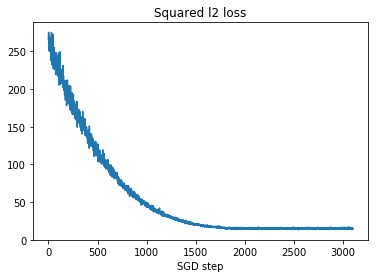

In [17]:
plt.plot(loss_evals)
plt.title("Squared l2 loss")
plt.xlabel("SGD step")
plt.show()